In [4]:
from IPython.display import clear_output
!pip install tashaphyne fasttext keras
!pip install arabic-reshaper python-bidi
clear_output()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import word_tokenize
from tashaphyne.stemming import ArabicLightStemmer
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
nltk.download('punkt')
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tqdm import tqdm
import fasttext
from bidi.algorithm import get_display
import arabic_reshaper

In [7]:
dataset=pd.read_csv('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_training_set.csv').drop(columns=['Unnamed: 0'])
testing_set=pd.read_csv('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_testing_set.csv').drop(columns=['Unnamed: 0'])
dataset

Tweet     Class
0     حرصا سلامة المدنين الرجاء الجميع إكسبو دبي رجا...  negative
1     عبدالله زايد وزير خارجية الإمارات يزور الجناح ...  negative
2     بدون مبالغة تنظيم أسبوع المهندس الجامعة أيام ز...  negative
3     جناح المغرب يفوز بجائزة افضل تصميم داخلي إكسبو...  negative
4     نسلط الضوء مرة رواق ممل فارغ إكسبو دبي رواق ال...  negative
...                                                 ...       ...
7495  توقف   اختارت فرقة دبي لاستءناف جولاتها العالم...   neutral
7496  اكسبو دبي يقترب  اخبار الامارات اكسبو دبي   را...   neutral
7497                        مجموعة اصدارات جواز اكسبو     neutral
7498     محمد راشد اثناء حضوري تمرين حصن الاتحاد اكس...   neutral
7499  بهدف تعزيز التعاون دولة الامارات كندا استضافت ...   neutral

[7500 rows x 2 columns]

In [8]:
dataset.dropna(inplace=True)

In [9]:
def stem(text):
  text=str(text)
  stemmer=ArabicLightStemmer()
  tokens=word_tokenize(text)
  tokens
  stemmized=[]
  for t in tokens:
    stem=stemmer.light_stem(t)
    stemmized.append(stem)

  return ' '.join(stemmized)

#all_texts=pd.concat([dataset['Tweet'],testing_set['Tweet']])
all_texts = dataset['Tweet']
all_texts.apply(stem)

0       حرص سلام مدن رجاء جميع إكسب دب رجاء بق مساف اف...
1       عبدالل زايد زير خارج إمار زور جناح سور إكسب دب...
2       دون مبالغ نظيم سبوع مهندس جامع يام زم حس نظيم ...
3       جناح مغرب فوز جائز فضل صميم داخل إكسب دب جناح ...
4       سلط ضوء مرة رواق ممل رغ إكسب دب رواق جزائر اضح...
                              ...                        
7495    وقف اختار رق دب استءناف جول عالم ما سب علاق كس...
7496     كسبو دب قترب خبار امار كسبو دب رادار يوز مرا خبر
7497                                مجموع اصدار جواز كسبو
7498    محمد راشد اثناء حضور مر حص اتحاد كسبو دب مر ظه...
7499    هدف عزيز تعا دول امار ندا استضاف قنصل عام كند ...
Name: Tweet, Length: 7491, dtype: object

In [10]:
ExpoTokenizer=Tokenizer()
ExpoTokenizer.fit_on_texts(all_texts)
# save tokenizer model
#import pickle
#with open('/content/drive/MyDrive/SeniorProject1/models/ExpoTokenizer.pickle', 'wb') as handle:
#    pickle.dump(ExpoTokenizer,handle)

# load tokenizer model
#with open('/content/drive/MyDrive/SeniorProject1/models/ExpoTokenizer.pickle', 'rb') as handle:
#    ExpoTokenizer = pickle.load(handle)
print("Number of total vocabulary of train and test =",len(ExpoTokenizer.word_index))

Number of total vocabulary of train and test = 25291


In [11]:
onehotencoder=OneHotEncoder().fit(np.array(dataset['Class']).reshape(-1,1))

In [12]:
sents_len=[]
for text in dataset['Tweet']:
  tokens=word_tokenize(text)
  sents_len.append(len(tokens))


#highest 2 sequence len
sorted(sents_len,reverse=True)[:2]

[44, 44]

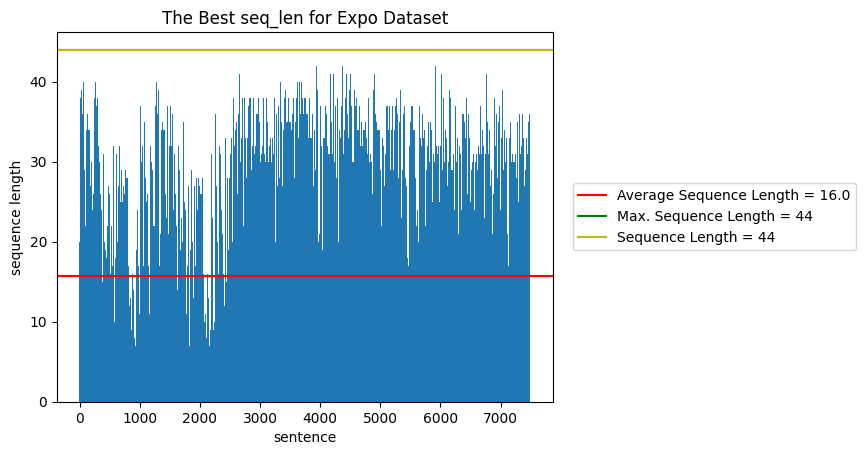

In [13]:
plt.bar(range(len(sents_len)),sents_len,width=10)
plt.ylabel('sequence length')
plt.xlabel('sentence')
plt.axhline(y=np.mean(sents_len), color='r',label=f'Average Sequence Length = {np.mean(sents_len).round()}')
plt.axhline(y=max(sents_len), color='g',label=f'Max. Sequence Length = {max(sents_len)}')
plt.axhline(y=44, color='y',label='Sequence Length = 44')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title('The Best seq_len for Expo Dataset')
plt.show()

### Dataset Construction

In [14]:
class ExpoDataset(Dataset):
  def __init__(self,df,tokenizer,onehotencoder,max_len=44):
    self.text=df['Tweet'].apply(self.stem)
    self.tokenizer=tokenizer
    #self.tokenizer.fit_on_texts(self.text)
    self.text=self.tokenizer.texts_to_sequences(self.text)
    self.text=pad_sequences(self.text,maxlen=max_len)
    self.df=df['Class']
    self.df=onehotencoder.fit_transform(np.array(self.df).reshape(-1,1)).toarray()

  def stem(self, text):
    stemmer=ArabicLightStemmer()
    tokens=word_tokenize(text)
    tokens
    stemmized=[]
    for t in tokens:
      stem=stemmer.light_stem(t)
      stemmized.append(stem)

    return ' '.join(stemmized)

  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    text=self.text[idx]
    label=self.df[idx]
    return text,label


In [15]:
expo_dataset=ExpoDataset(dataset,ExpoTokenizer,onehotencoder,44)
expo_dataset[0]

(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,  2340,  5381,
         2937, 23758,  2937, 24406,  1182,   271,  3643,  2111],
       dtype=int32),
 array([1., 0., 0.]))

In [16]:
len(expo_dataset.tokenizer.word_index)

25291

In [17]:
seed = torch.Generator().manual_seed(42)
train_set,val_set=torch.utils.data.random_split(expo_dataset,[0.85,0.15], generator=seed)
len(train_set),len(val_set)

(6368, 1123)

In [18]:
full_dataloader = DataLoader(expo_dataset, batch_size=64, shuffle=True)
train_loader=DataLoader(train_set,batch_size=64,shuffle=True)
val_loader=DataLoader(val_set,batch_size=64,shuffle=False)

In [19]:
test_loader=DataLoader(ExpoDataset(testing_set,ExpoTokenizer,onehotencoder),batch_size=64,shuffle=False)

# Models

# FastText Embeddings

In [20]:
#Load the Arabic Fasttext model
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz
!gunzip cc.ar.300.bin.gz

--2024-10-16 04:01:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.78, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500982519 (4.2G) [application/octet-stream]
Saving to: ‘cc.ar.300.bin.gz’

cc.ar.300.bin.gz    100%[===================>]   4.19G   156MB/s    in 39s     

2024-10-16 04:02:08 (111 MB/s) - ‘cc.ar.300.bin.gz’ saved [4500982519/4500982519]



In [21]:
# Extract the Model Embeddings
#model = fasttext.load_model("cc.ar.300.bin")
#fasttext_weights=np.zeros((len(expo_dataset.tokenizer.word_index)+1,model.get_dimension()))
#for word, index in tqdm(expo_dataset.tokenizer.word_index.items()):
#    fasttext_weights[index]=model.get_word_vector(word)

#np.save('/content/drive/MyDrive/SeniorProject1/models/fasttext_embeddings.npy',fasttext_weights)

In [22]:
#np.save('/content/drive/MyDrive/SeniorProject1/models/fasttext_embeddings.npy',fasttext_weights)

In [23]:
# Re-Load the fasttext_weights (you can find it in the project google drive)
fasttext_weights=np.load('/content/drive/MyDrive/SeniorProject1/models/fasttext_embeddings.npy')

In [24]:
print('The embedding shape = ',fasttext_weights.shape)

The embedding shape =  (25292, 300)


### DL models

In [25]:
class LSTM(nn.Module):
  def __init__(self,fasttext_weights,hidden_size1,hidden_size2,freeze_embedding=True,droprate=0.5,num_layers=1,num_classes=3,dider=True):
    super(LSTM,self).__init__()
    self.embedding=nn.Embedding.from_pretrained(torch.FloatTensor(fasttext_weights),freeze=freeze_embedding)
    self.lstm=nn.LSTM(self.embedding.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

    #torch.nn.init.xavier_uniform_(self.fc1.weight)
    #torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self,x):
    x=self.embedding(x)
    x,h=self.lstm(x)
    x=self.fc1(x[:,-1,:])
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x

In [26]:
def visualize(text_ids,weights,predictions,labels):

  positives_weights = weights[labels == 2]
  negatives_weights = weights[labels == 0]
  neutrals_weights = weights[labels == 1]

  positives_text_ids = text_ids[labels == 2]
  negatives_text_ids = text_ids[labels == 0]
  neutrals_text_ids = text_ids[labels == 1]

  # Randomly selecting indices for each class
  positive_indices = np.random.choice(np.arange(len(positives_weights)), size=1)
  negative_indices = np.random.choice(np.arange(len(negatives_weights)), size=1)
  neutral_indices = np.random.choice(np.arange(len(neutrals_weights)), size=1)

  fig, axs = plt.subplots(3, figsize=(10, 6))
  #axs = [axs]  # Ensure axs is iterable if there's only one plot
  #print('axs=',type(axs[0]),axs[0])
  # Function to plot heatmaps for a given class
  def plot_heatmaps(indecies, text_ids_, weights_, ax_row):
      for index in indecies:
          num_paddings=sum(text_ids_[index]==0)
          text = " ".join(ExpoTokenizer.sequences_to_texts([text_ids_[index]])).split(' ')
          reshaped_text = [arabic_reshaper.reshape(token) for token in text]
          bidi_text = (['[PAD]']*num_paddings)+[get_display(token) for token in reshaped_text]
          correct_weight = weights_[index]

          # Create the heatmap for the current index
          heatmap = axs[ax_row].imshow([correct_weight], cmap='YlGnBu', aspect='auto')

          # Set the tokens as x-ticks
          axs[ax_row].set_xticks(np.arange(len(bidi_text)))
          axs[ax_row].set_xticklabels(bidi_text, rotation=90)

          # Remove y-ticks
          axs[ax_row].set_yticks([])
      plt.tight_layout()
      return heatmap

  # Plot heatmaps for positive, negative, and neutral predictions
  heatmap=plot_heatmaps(negative_indices, negatives_text_ids, negatives_weights, 0)  # Row 0 for negative
  heatmap=plot_heatmaps(neutral_indices, neutrals_text_ids, neutrals_weights, 1)  # Row 1 for neutral
  heatmap=plot_heatmaps(positive_indices, positives_text_ids, positives_weights, 2)     # Row 2 for positive

  # Set overall titles for each row
  axs[0].set_ylabel('Negative', rotation=0, labelpad=50, fontsize=12)
  axs[1].set_ylabel('Neutral', rotation=0, labelpad=50, fontsize=12)
  axs[2].set_ylabel('Positive', rotation=0, labelpad=50, fontsize=12)

  # Create a single color bar for the entire figure
  cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.8])  # [left, bottom, width, height]
  plt.colorbar(heatmap, cax=cbar_ax)

  plt.suptitle('Attention Weights', fontsize=16, x=0.5, y=1.02)  # Adjust the y-position for the title
  #plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
  plt.show()

In [27]:
#helper function to automate the loss and accuracy plots
def plot_loss_accuracy(train_total_loss,val_total_loss,train_accuracies,val_accuracies):
  plt.subplots(figsize=(12,4))
  plt.subplot(121)
  plt.plot(train_total_loss,label='train')
  if len(val_total_loss)!=0:
    plt.plot(val_total_loss,label='val')
  plt.title('Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(122)
  plt.plot(train_accuracies,label='train')
  if len(val_accuracies)!=0:
    plt.plot(val_accuracies,label='val')
  plt.title('Accuracies')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [28]:
# Test on the test_loader
def test_and_report(model,test_loader,model_name,attention_added=False):
  model.eval()
  predictions=[]
  labels=[]
  test_total_dataitem=0
  test_correct=0
  input_ids_list=[]
  attention_weights=[]
  correct_answers=[]
  all_labels=[]
  with torch.no_grad():
      for batch in test_loader:
          text,label=batch[0].to(device),batch[1].to(device)
          output=model(text)
          if attention_added:
            attention_weights.extend(output[1].cpu().numpy())
            output=output[0]

          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          test_total_dataitem += label.size(0)
          test_correct += (predicted == label.argmax(axis=1)).sum()
          predictions.extend(predicted.cpu().numpy())
          labels.extend(label.argmax(axis=1).cpu().numpy())
          input_ids_list.extend(text.cpu().numpy())
          all_labels.extend(label.argmax(axis=1).cpu().numpy())
          correct_answers.extend((predicted == label.argmax(axis=1)).cpu().numpy())


  test_accuracy = test_correct/test_total_dataitem
  print(f'Test correct = {test_correct}\n')
  print(f'Test total dataitem = {test_total_dataitem}\n')
  print(f'Test Accuracy = {test_accuracy}\n')
  print(classification_report(labels,predictions,target_names=['negative','neutral','positive']))
  fig,ax=plt.subplots(figsize=(5, 5))
  ConfusionMatrixDisplay.from_predictions(labels,predictions,display_labels=['negative','neutral','positive'],normalize='pred',cmap=plt.cm.Blues, xticks_rotation='vertical',ax=ax)
  plt.title(f'Confusion Matrix of {model_name}')
  plt.show()
  if attention_added:
    visualize(np.array(input_ids_list),np.array(attention_weights),correct_answers,np.array(all_labels))

In [29]:
#helper function to automate the training loop
def train(model,epochs,optimizer,criterion,train_loader,val_loader=None,attention_added=False):
  train_total_loss=[]
  val_total_loss=[]
  train_accuracies=[]
  val_accuracies=[]
  for epoch in range(epochs):
    train_losses=0
    val_losses=0
    train_total_dataitem=0
    train_correct=0
    tqdm_par=tqdm(train_loader,desc=f'Epoch {epoch+1}')
    #tqdm_par.set_description(f'Epoch {epoch+1}')
    model.train() #training mode
    for batch in tqdm_par:
      text,label=batch[0].to(device),batch[1].to(device)
      output=model(text)
      if attention_added:
        output=output[0]
      train_loss=criterion(output,label)
      optimizer.zero_grad()
      train_losses+=train_loss.item()
      train_loss.backward()
      optimizer.step()
      # Compute the accuracy
      y_pred=F.softmax(output,dim=1)
      predicted = y_pred.argmax(axis=1)
      train_total_dataitem += label.size(0)
      train_correct += (predicted == label.argmax(axis=1)).sum()
    train_accuracy = train_correct / train_total_dataitem

    if val_loader:
      model.eval() #evaluation mode
      with torch.no_grad():
        val_total_dataitem=0
        val_correct=0
        for batch in val_loader:
          text,label=batch[0].to(device),batch[1].to(device)
          output=model(text)
          if attention_added:
            output=output[0]
          val_loss=criterion(output,label)
          val_losses+=val_loss.item()
          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          val_total_dataitem += label.size(0)
          val_correct += (predicted == label.argmax(axis=1)).sum()
        val_accuracy = val_correct/val_total_dataitem

    tqdm_par.refresh()
    train_total_loss.append(train_losses/len(train_loader))
    train_accuracies.append(train_accuracy.cpu())
    if val_loader:
      val_total_loss.append(val_losses/len(val_loader))
      val_accuracies.append(val_accuracy.cpu())
      print(f'loss = {train_losses/len(train_loader)}, val_loss ={val_losses/len(val_loader)}, accuracy = {train_accuracy}, val_accuracy = {val_accuracy}')
    else:
      print(f'loss = {train_losses/len(train_loader)}, accuracy = {train_accuracy}')

  plot_loss_accuracy(train_total_loss,val_total_loss,train_accuracies,val_accuracies)

You're on a cuda


Epoch 1: 100%|██████████| 100/100 [00:02<00:00, 45.55it/s]


loss = 1.0966571769304574, val_loss =1.0953031516619145, accuracy = 0.3484610617160797, val_accuracy = 0.3383793532848358


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 218.37it/s]


loss = 1.0898106894735247, val_loss =1.0850100766276083, accuracy = 0.42383792996406555, val_accuracy = 0.5004452466964722


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 210.53it/s]


loss = 1.0591746167326346, val_loss =1.0154985769200953, accuracy = 0.5023555159568787, val_accuracy = 0.5512021780014038


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 213.35it/s]


loss = 0.9730475029593799, val_loss =0.9520517244203283, accuracy = 0.5698806643486023, val_accuracy = 0.5529831051826477


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 197.27it/s]


loss = 0.9041515481413808, val_loss =0.8807475418841009, accuracy = 0.6097675561904907, val_accuracy = 0.6251113414764404


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 170.00it/s]


loss = 0.862318171228544, val_loss =0.8446401666311201, accuracy = 0.6361494660377502, val_accuracy = 0.6438112258911133


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 163.90it/s]


loss = 0.8270821676697233, val_loss =0.819252893832394, accuracy = 0.64777010679245, val_accuracy = 0.6464826464653015


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 161.46it/s]


loss = 0.7993214011850068, val_loss =0.7995090443908888, accuracy = 0.660804033279419, val_accuracy = 0.6544969081878662


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 162.46it/s]


loss = 0.7736143583116063, val_loss =0.7833038891264652, accuracy = 0.6802763938903809, val_accuracy = 0.6571683287620544


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 155.86it/s]
<ipython-input-27-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7517038256646629, val_loss =0.7919306484075072, accuracy = 0.6853014826774597, val_accuracy = 0.641139805316925


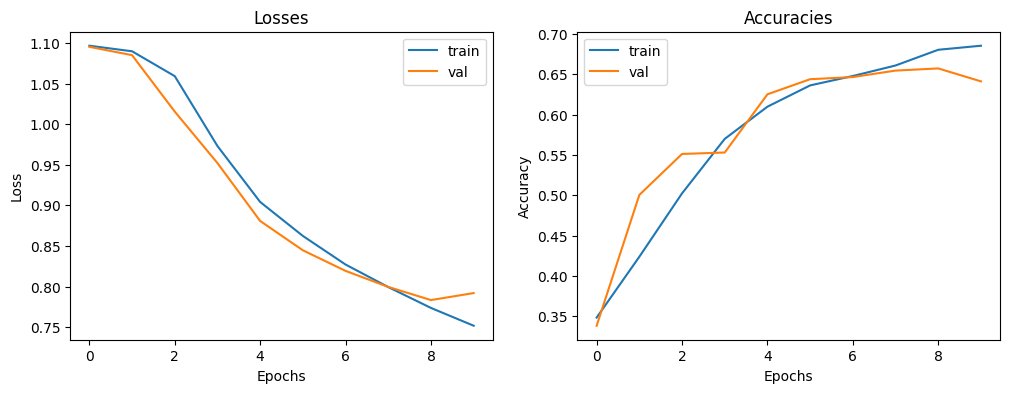

Test correct = 463

Test total dataitem = 750

Test Accuracy = 0.6173333525657654

              precision    recall  f1-score   support

    negative       0.63      0.69      0.66       250
     neutral       0.56      0.76      0.64       250
    positive       0.73      0.40      0.52       250

    accuracy                           0.62       750
   macro avg       0.64      0.62      0.61       750
weighted avg       0.64      0.62      0.61       750



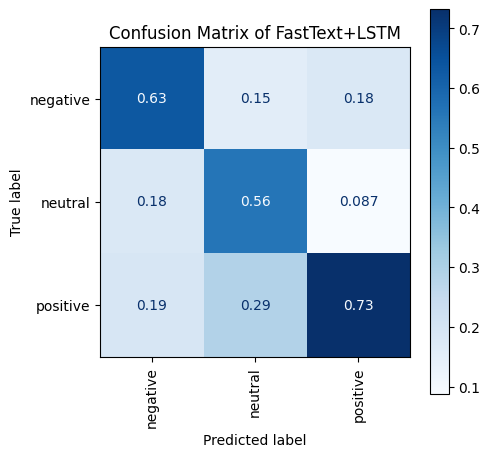

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You're on a {device}")
#hyperparameter
hidden_size1=128
hidden_size2=64
num_layers=1
bidirectional=True
freeze_embedding=True
droprate=0.5
learning_rate=0.0001
epoch=10
model=LSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
optimizer=optim.Adam(model.parameters(),lr=learning_rate) # play around this also
criterion=nn.CrossEntropyLoss()
train(model,epoch,optimizer,criterion,train_loader,val_loader)
model_name='FastText+LSTM'
test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 159.00it/s]


loss = 1.0992013662029059, val_loss =1.0941118815499875, accuracy = 0.3476758897304535, val_accuracy = 0.3713268041610718


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 211.42it/s]


loss = 1.0908057861682028, val_loss =1.0842781719899486, accuracy = 0.4205401837825775, val_accuracy = 0.5040071606636047


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 209.01it/s]


loss = 1.0576495965151116, val_loss =1.0116218165309716, accuracy = 0.5039258599281311, val_accuracy = 0.529830813407898


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 217.85it/s]


loss = 0.9540148165886058, val_loss =0.9164031798566972, accuracy = 0.5734924674034119, val_accuracy = 0.585930585861206


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 211.27it/s]


loss = 0.893840993779595, val_loss =0.874288858861352, accuracy = 0.6092965006828308, val_accuracy = 0.6188780069351196


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 218.75it/s]


loss = 0.8560533352950006, val_loss =0.8494109677681182, accuracy = 0.6278266310691833, val_accuracy = 0.634906530380249


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 210.29it/s]


loss = 0.8243245628243312, val_loss =0.8310147906378251, accuracy = 0.6509107947349548, val_accuracy = 0.6384683847427368


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 222.75it/s]


loss = 0.8033226397066028, val_loss =0.8265685013699575, accuracy = 0.6604899168014526, val_accuracy = 0.6447017192840576


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 210.14it/s]


loss = 0.7860785049109836, val_loss =0.7974768411794988, accuracy = 0.6699120402336121, val_accuracy = 0.6553874015808105


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 197.47it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7648956333215756, val_loss =0.7913895080531282, accuracy = 0.6766645908355713, val_accuracy = 0.6544969081878662


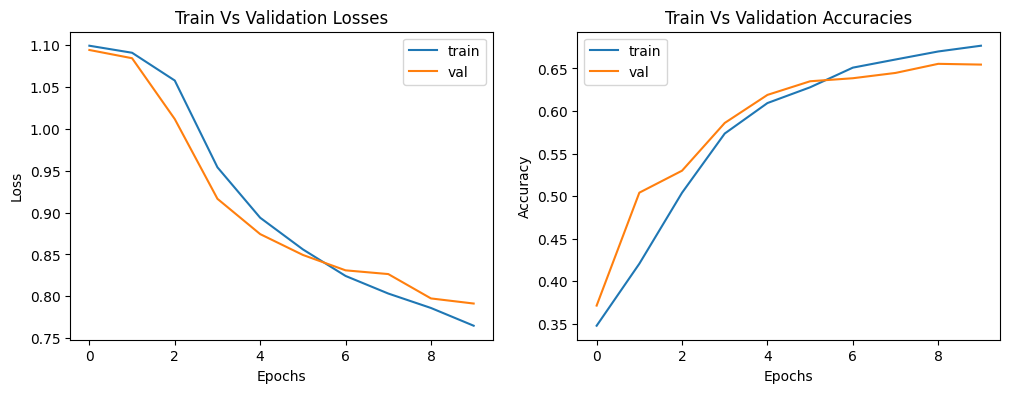

bidirectional = True
Test correct = 465

Test total dataitem = 750

Test Accuracy = 0.6200000047683716

              precision    recall  f1-score   support

    negative       0.63      0.71      0.67       250
     neutral       0.59      0.71      0.64       250
    positive       0.66      0.44      0.53       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.61       750
weighted avg       0.63      0.62      0.61       750



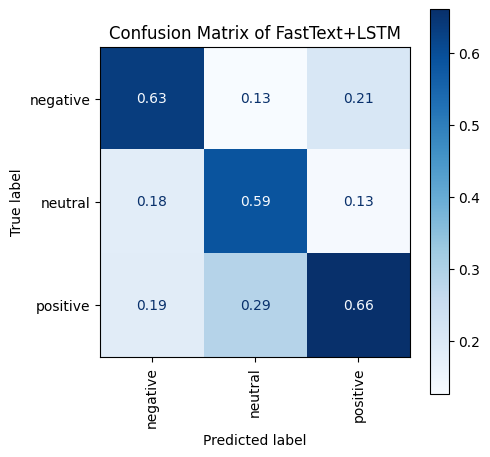

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 210.64it/s]


loss = 1.0966094321757556, val_loss =1.0948607619940525, accuracy = 0.3676193356513977, val_accuracy = 0.47195014357566833


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 213.92it/s]


loss = 1.0904190194513648, val_loss =1.0860220557403943, accuracy = 0.42305275797843933, val_accuracy = 0.4933214783668518


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 189.93it/s]


loss = 1.0615964584914037, val_loss =1.008763919701238, accuracy = 0.5067524909973145, val_accuracy = 0.5440783500671387


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 191.45it/s]


loss = 0.9626900656806537, val_loss =0.9173759475684844, accuracy = 0.5701947212219238, val_accuracy = 0.593944787979126


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 196.47it/s]


loss = 0.8929432364966852, val_loss =0.8721068789723277, accuracy = 0.6129083037376404, val_accuracy = 0.6153161525726318


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 201.40it/s]


loss = 0.8600469422336755, val_loss =0.8509873902117501, accuracy = 0.6290829181671143, val_accuracy = 0.6313446164131165


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 266.88it/s]


loss = 0.8314192778542201, val_loss =0.828337774367676, accuracy = 0.6499685645103455, val_accuracy = 0.6366874575614929


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 284.02it/s]


loss = 0.8103617592124647, val_loss =0.8151310890056988, accuracy = 0.6551507711410522, val_accuracy = 0.6322351098060608


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 264.79it/s]


loss = 0.7848139667998112, val_loss =0.789249323341175, accuracy = 0.6714823842048645, val_accuracy = 0.6509349942207336


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 270.31it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7762243723841675, val_loss =0.7774960092550222, accuracy = 0.6727386713027954, val_accuracy = 0.6553874015808105


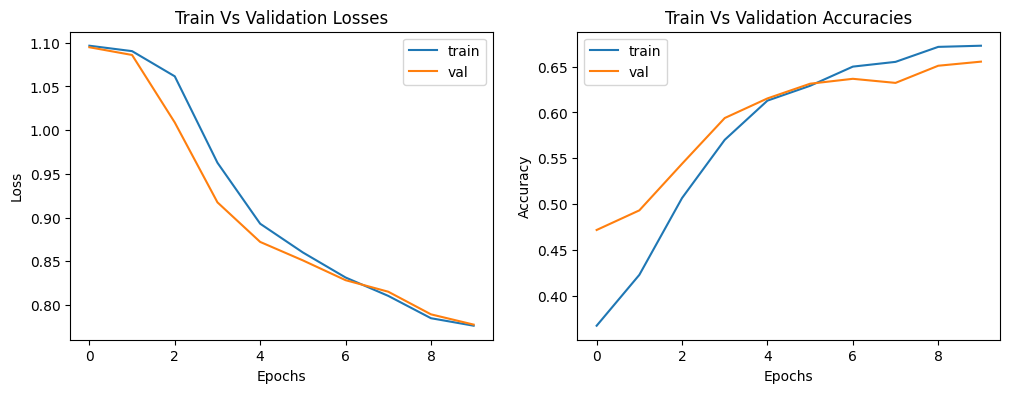

bidirectional = False
Test correct = 457

Test total dataitem = 750

Test Accuracy = 0.609333336353302

              precision    recall  f1-score   support

    negative       0.63      0.67      0.65       250
     neutral       0.59      0.63      0.61       250
    positive       0.61      0.53      0.56       250

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



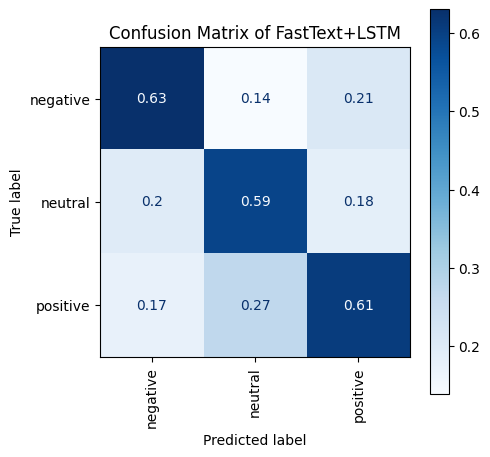

In [ ]:
#Experiment 1
#hyperparameter
bidirectional_options=[True,False]
for bidirectional1 in bidirectional_options:
  model=LSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional1).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+LSTM'
  print(f'bidirectional = {bidirectional1}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 213.74it/s]


loss = 1.0999226025305688, val_loss =1.093369556280474, accuracy = 0.35474246740341187, val_accuracy = 0.4710596799850464


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 209.94it/s]


loss = 1.0898053262475877, val_loss =1.077536648401015, accuracy = 0.40562185645103455, val_accuracy = 0.44612646102905273


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 214.68it/s]


loss = 1.039385848203674, val_loss =0.9965105740353466, accuracy = 0.4813128113746643, val_accuracy = 0.5654497146606445


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 204.72it/s]


loss = 0.9696610510605388, val_loss =0.9397119092104573, accuracy = 0.551350474357605, val_accuracy = 0.5992876291275024


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 213.69it/s]


loss = 0.9062323388177902, val_loss =0.8894610030240275, accuracy = 0.5995603203773499, val_accuracy = 0.5930543541908264


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 211.52it/s]


loss = 0.8507382957148366, val_loss =0.8437458927671071, accuracy = 0.6317524909973145, val_accuracy = 0.6162065863609314


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 213.56it/s]


loss = 0.8089590999676147, val_loss =0.814382268899926, accuracy = 0.6573492288589478, val_accuracy = 0.6375779509544373


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 212.73it/s]


loss = 0.7865197138371149, val_loss =0.7993634118529458, accuracy = 0.665986180305481, val_accuracy = 0.6393588781356812


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 213.42it/s]


loss = 0.7650842095275584, val_loss =0.8050244848497512, accuracy = 0.6765075325965881, val_accuracy = 0.6402493715286255


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 215.64it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7454766231842223, val_loss =0.7738376309950135, accuracy = 0.6862437129020691, val_accuracy = 0.6464826464653015


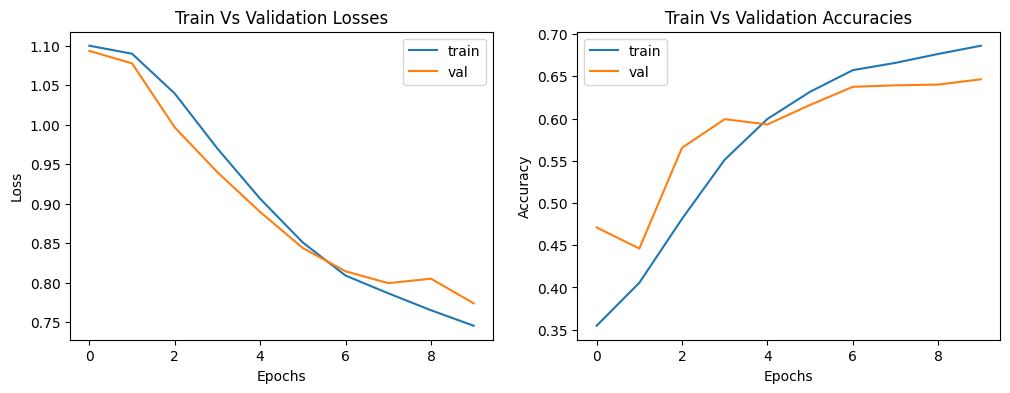

lstm_layers = 1
Test correct = 467

Test total dataitem = 750

Test Accuracy = 0.6226666569709778

              precision    recall  f1-score   support

    negative       0.59      0.75      0.66       250
     neutral       0.64      0.60      0.62       250
    positive       0.65      0.51      0.57       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.62       750
weighted avg       0.63      0.62      0.62       750



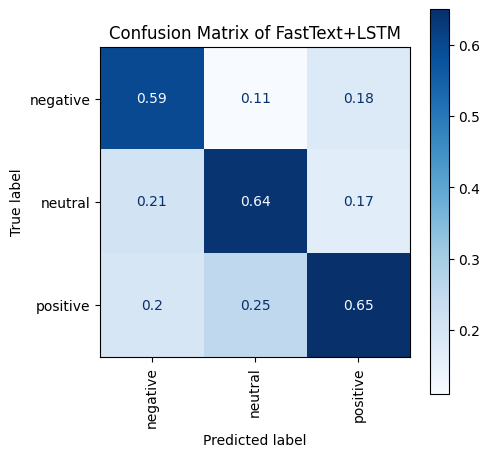

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 134.39it/s]


loss = 1.0998145383782685, val_loss =1.0953683729209596, accuracy = 0.3341708481311798, val_accuracy = 0.34728407859802246


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 135.66it/s]


loss = 1.0843834094144404, val_loss =1.0394400096572345, accuracy = 0.41645729541778564, val_accuracy = 0.4835262894630432


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 111.00it/s]


loss = 0.9638013569742907, val_loss =0.8935577622455884, accuracy = 0.5138190984725952, val_accuracy = 0.6108637452125549


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 101.27it/s]


loss = 0.8907147784082917, val_loss =0.8710014520708236, accuracy = 0.567682147026062, val_accuracy = 0.6046304702758789


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 74.20it/s]


loss = 0.8500155451108004, val_loss =0.8177089696193839, accuracy = 0.603486180305481, val_accuracy = 0.6491540670394897


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 51.22it/s]


loss = 0.811217062265714, val_loss =0.7956184786859908, accuracy = 0.6378768682479858, val_accuracy = 0.6438112258911133


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 53.38it/s]


loss = 0.7650005201873864, val_loss =0.7578764396424901, accuracy = 0.6673994660377502, val_accuracy = 0.6794301271438599


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 56.34it/s]


loss = 0.7400702920842014, val_loss =0.7486907265886354, accuracy = 0.6857725977897644, val_accuracy = 0.6651825904846191


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 75.19it/s]


loss = 0.717599232952416, val_loss =0.7789280687358104, accuracy = 0.6958228349685669, val_accuracy = 0.6571683287620544


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 86.86it/s]


loss = 0.6988663188541796, val_loss =0.7337534420679614, accuracy = 0.7052449584007263, val_accuracy = 0.6723063588142395


<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


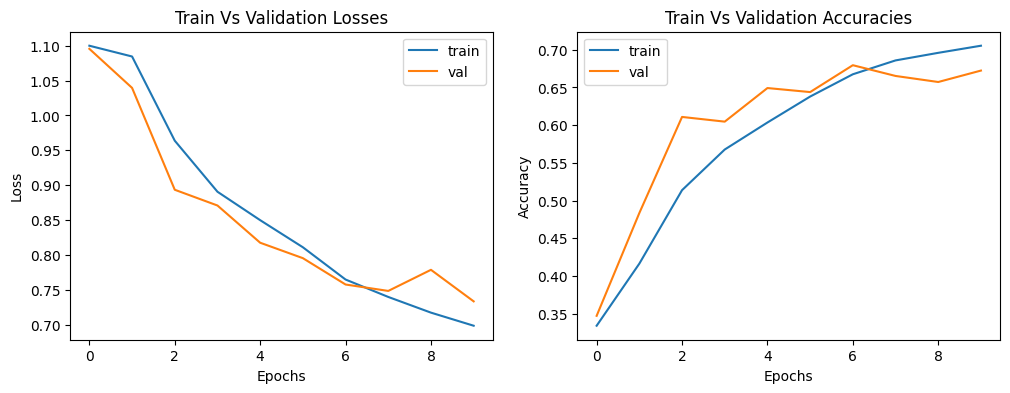

lstm_layers = 2
Test correct = 459

Test total dataitem = 750

Test Accuracy = 0.6119999885559082

              precision    recall  f1-score   support

    negative       0.62      0.70      0.66       250
     neutral       0.59      0.67      0.63       250
    positive       0.63      0.47      0.54       250

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



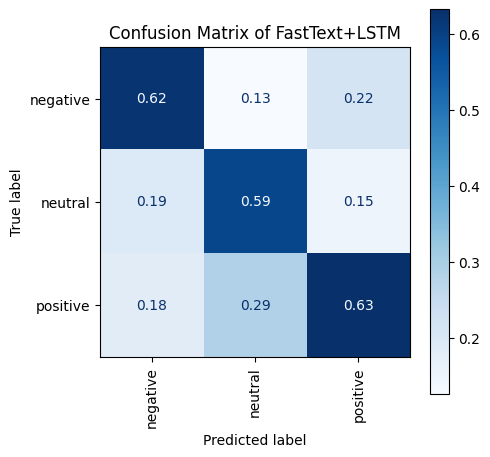

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 62.40it/s]


loss = 1.1013256809860468, val_loss =1.1004212160727809, accuracy = 0.3377826511859894, val_accuracy = 0.31700801849365234


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.76it/s]


loss = 1.0879813444893807, val_loss =1.0364931531287433, accuracy = 0.38520729541778564, val_accuracy = 0.49421194195747375


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 85.78it/s]


loss = 0.9715415180154378, val_loss =0.8852330509682245, accuracy = 0.5449120402336121, val_accuracy = 0.5868210196495056


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 77.49it/s]


loss = 0.8506155616129399, val_loss =0.8128438090994244, accuracy = 0.6304962038993835, val_accuracy = 0.6500445604324341


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 76.70it/s]


loss = 0.7987067719106562, val_loss =0.7850299253474943, accuracy = 0.6634736061096191, val_accuracy = 0.6536064147949219


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 86.21it/s]


loss = 0.7636257595296775, val_loss =0.7758181860987355, accuracy = 0.682317852973938, val_accuracy = 0.6598397493362427


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 93.52it/s]


loss = 0.7406013563991292, val_loss =0.7541427842792241, accuracy = 0.6918969750404358, val_accuracy = 0.6767587065696716


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 93.17it/s]


loss = 0.7179870507743908, val_loss =0.7371274512797956, accuracy = 0.705716073513031, val_accuracy = 0.6740872859954834


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 93.57it/s]


loss = 0.7057124771798772, val_loss =0.7425249709750966, accuracy = 0.7162374258041382, val_accuracy = 0.6678539514541626


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 91.66it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6958661602293068, val_loss =0.721847596499304, accuracy = 0.7167085409164429, val_accuracy = 0.6785396337509155


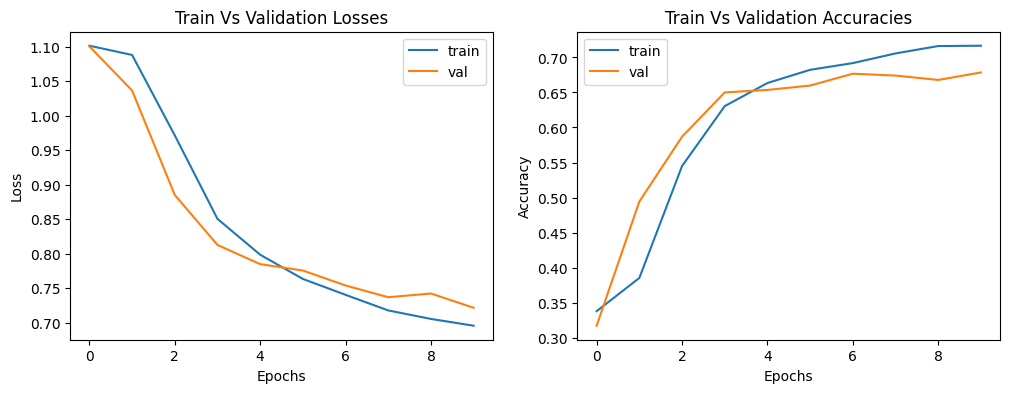

lstm_layers = 3
Test correct = 467

Test total dataitem = 750

Test Accuracy = 0.6226666569709778

              precision    recall  f1-score   support

    negative       0.64      0.68      0.66       250
     neutral       0.61      0.63      0.62       250
    positive       0.62      0.56      0.59       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750



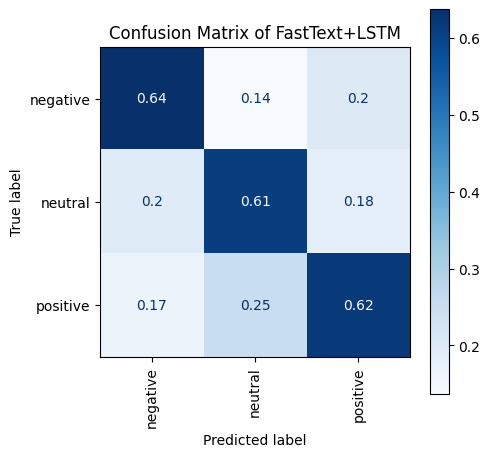

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 71.45it/s]


loss = 1.09893195877783, val_loss =1.097059080468875, accuracy = 0.33479899168014526, val_accuracy = 0.3535173833370209


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 71.25it/s]


loss = 1.0664637745544314, val_loss =1.0101645648767728, accuracy = 0.41221731901168823, val_accuracy = 0.5040071606636047


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 66.88it/s]


loss = 0.9563318104832433, val_loss =0.8919455527394479, accuracy = 0.5332914590835571, val_accuracy = 0.5592163801193237


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 64.62it/s]


loss = 0.8989590142836096, val_loss =0.8767684772326094, accuracy = 0.5615577697753906, val_accuracy = 0.5485307574272156


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 62.72it/s]


loss = 0.8630148065471439, val_loss =0.8609795953309726, accuracy = 0.5901381969451904, val_accuracy = 0.5627782940864563


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 70.73it/s]


loss = 0.836692022800562, val_loss =0.817292246956467, accuracy = 0.6066268682479858, val_accuracy = 0.5975067019462585


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 70.43it/s]


loss = 0.8020184487078222, val_loss =0.7955737446323924, accuracy = 0.632851779460907, val_accuracy = 0.6233303546905518


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 69.55it/s]


loss = 0.7615628890987136, val_loss =0.7619324547532459, accuracy = 0.6719534993171692, val_accuracy = 0.6714158654212952


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 70.24it/s]


loss = 0.7286779030374965, val_loss =0.7524067615271576, accuracy = 0.6884422302246094, val_accuracy = 0.6705253720283508


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 69.94it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.70451064844945, val_loss =0.7485757729218301, accuracy = 0.7085427045822144, val_accuracy = 0.6536064147949219


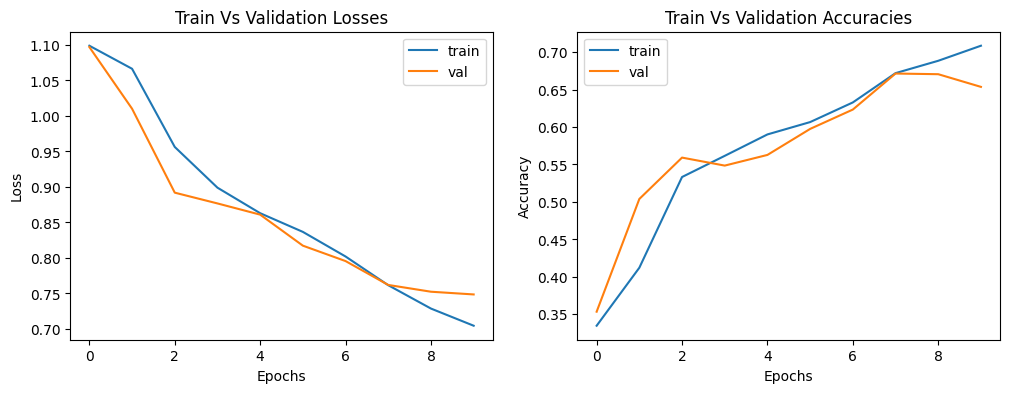

lstm_layers = 4
Test correct = 465

Test total dataitem = 750

Test Accuracy = 0.6200000047683716

              precision    recall  f1-score   support

    negative       0.69      0.64      0.66       250
     neutral       0.56      0.73      0.63       250
    positive       0.64      0.49      0.56       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.62       750
weighted avg       0.63      0.62      0.62       750



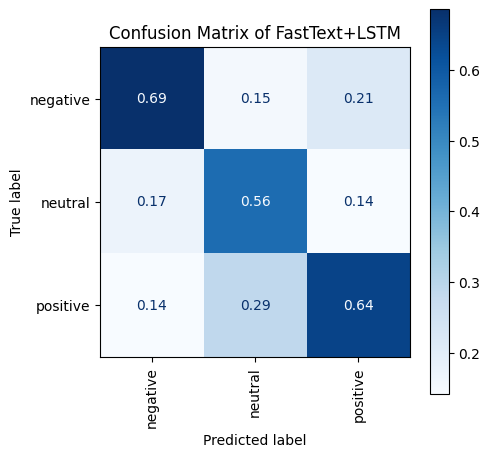

In [ ]:
bidirectional=True
lstm_layers=[1,2,3,4]
for lstm_layer in lstm_layers:
  model=LSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,lstm_layer,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+LSTM'
  print(f'lstm_layers = {lstm_layer}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 116.28it/s]


loss = 1.099920431142673, val_loss =1.095948954909626, accuracy = 0.33699747920036316, val_accuracy = 0.34728407859802246


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 128.75it/s]


loss = 1.0945633729174733, val_loss =1.0924908833193874, accuracy = 0.35615578293800354, val_accuracy = 0.37043634057044983


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 122.91it/s]


loss = 1.0903950377739966, val_loss =1.086677146979445, accuracy = 0.38944724202156067, val_accuracy = 0.44078361988067627


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 122.16it/s]


loss = 1.0803100312687457, val_loss =1.0737379333802632, accuracy = 0.4382851719856262, val_accuracy = 0.480854868888855


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 113.17it/s]


loss = 1.0556764950044453, val_loss =1.0375638044927091, accuracy = 0.49324747920036316, val_accuracy = 0.49866431951522827


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 102.55it/s]


loss = 1.0024157161265612, val_loss =0.9858727549527964, accuracy = 0.5356469750404358, val_accuracy = 0.49599289894104004


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 94.76it/s]


loss = 0.9520880805235357, val_loss =0.9327116289065176, accuracy = 0.5675251483917236, val_accuracy = 0.5565449595451355


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 134.32it/s]


loss = 0.9074906118540094, val_loss =0.8911836432803066, accuracy = 0.5973618030548096, val_accuracy = 0.6108637452125549


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 255.19it/s]


loss = 0.863856459290837, val_loss =0.86020040434253, accuracy = 0.6245288848876953, val_accuracy = 0.6046304702758789


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 250.38it/s]


loss = 0.8376811851531966, val_loss =0.8345442845585889, accuracy = 0.6385050415992737, val_accuracy = 0.6286731958389282


<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


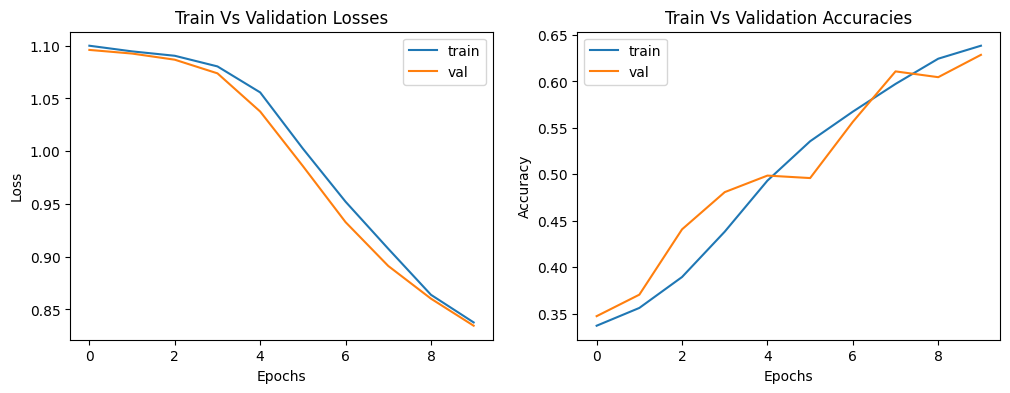

lstm_hidden = 32
Test correct = 448

Test total dataitem = 750

Test Accuracy = 0.5973333120346069

              precision    recall  f1-score   support

    negative       0.58      0.72      0.64       250
     neutral       0.59      0.63      0.61       250
    positive       0.64      0.44      0.52       250

    accuracy                           0.60       750
   macro avg       0.60      0.60      0.59       750
weighted avg       0.60      0.60      0.59       750



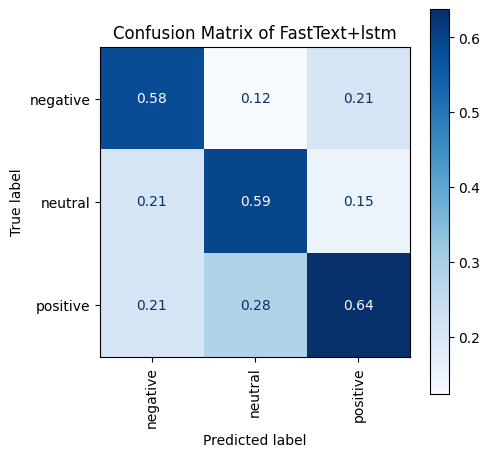

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 236.10it/s]


loss = 1.0980734043195843, val_loss =1.0951714404222985, accuracy = 0.3434359133243561, val_accuracy = 0.3517364263534546


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 238.19it/s]


loss = 1.093931092377752, val_loss =1.0905593960176385, accuracy = 0.38599246740341187, val_accuracy = 0.44434550404548645


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 252.71it/s]


loss = 1.0851611441932618, val_loss =1.077909427193836, accuracy = 0.4375, val_accuracy = 0.5182546973228455


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 251.83it/s]


loss = 1.051995489136316, val_loss =1.0131112381801128, accuracy = 0.5061243772506714, val_accuracy = 0.47640249133110046


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 250.26it/s]


loss = 0.9879625882301479, val_loss =0.9525970794230937, accuracy = 0.5219849348068237, val_accuracy = 0.5440783500671387


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 254.37it/s]


loss = 0.9318928605201654, val_loss =0.90729529721485, accuracy = 0.5706658363342285, val_accuracy = 0.5805877447128296


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 246.21it/s]


loss = 0.8939195960783399, val_loss =0.8664615676997022, accuracy = 0.5929648280143738, val_accuracy = 0.6046304702758789


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 257.74it/s]


loss = 0.853698805529275, val_loss =0.8319420050999652, accuracy = 0.6248429417610168, val_accuracy = 0.6162065863609314


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 241.71it/s]


loss = 0.8148237171032815, val_loss =0.8135749465534611, accuracy = 0.64777010679245, val_accuracy = 0.6313446164131165


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 254.75it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7982950208606053, val_loss =0.7999486177212685, accuracy = 0.6584484577178955, val_accuracy = 0.6491540670394897


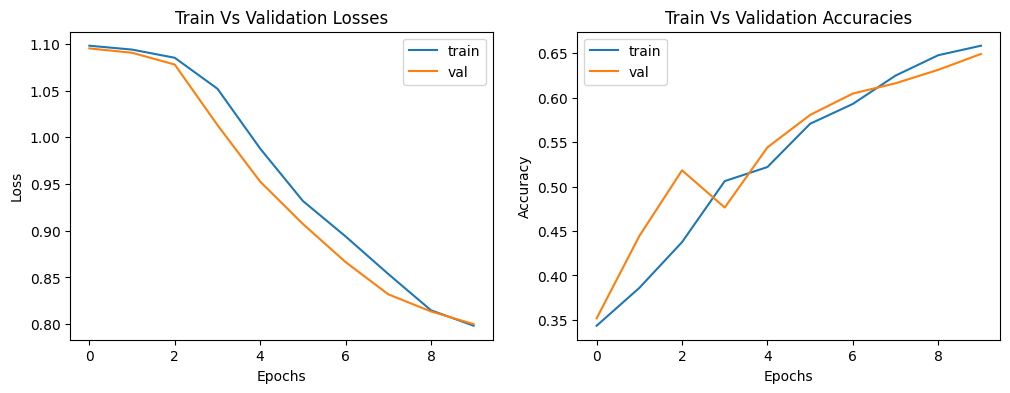

lstm_hidden = 64
Test correct = 448

Test total dataitem = 750

Test Accuracy = 0.5973333120346069

              precision    recall  f1-score   support

    negative       0.66      0.57      0.61       250
     neutral       0.56      0.73      0.63       250
    positive       0.59      0.49      0.54       250

    accuracy                           0.60       750
   macro avg       0.60      0.60      0.59       750
weighted avg       0.60      0.60      0.59       750



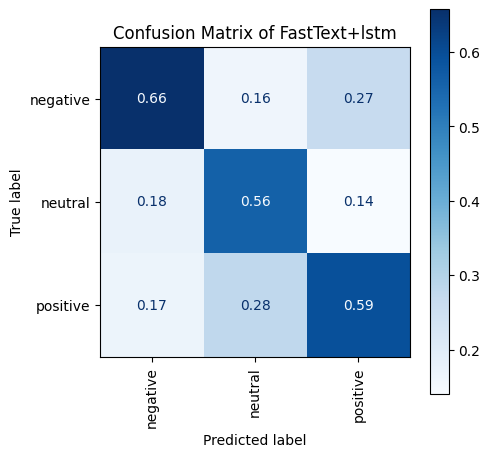

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 190.31it/s]


loss = 1.0984883146174251, val_loss =1.0971013760992459, accuracy = 0.35050252079963684, val_accuracy = 0.3401602804660797


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 157.30it/s]


loss = 1.091233893111348, val_loss =1.0871085647005765, accuracy = 0.40734922885894775, val_accuracy = 0.463935911655426


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 112.03it/s]


loss = 1.0607719631213695, val_loss =1.0160020912657417, accuracy = 0.4901067912578583, val_accuracy = 0.49421194195747375


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 132.82it/s]


loss = 0.9651256493898108, val_loss =0.937504541853975, accuracy = 0.5599874258041382, val_accuracy = 0.5636687874794006


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 98.87it/s]


loss = 0.8976126780468622, val_loss =0.8687113987941605, accuracy = 0.6129083037376404, val_accuracy = 0.6162065863609314


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 81.40it/s]


loss = 0.8533547925751919, val_loss =0.8506537604188207, accuracy = 0.6323806643486023, val_accuracy = 0.6251113414764404


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 113.26it/s]


loss = 0.8214826165592239, val_loss =0.8265175361634373, accuracy = 0.6469849348068237, val_accuracy = 0.634906530380249


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 152.75it/s]


loss = 0.8020631332435005, val_loss =0.8037822185876957, accuracy = 0.6579774022102356, val_accuracy = 0.6420302987098694


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 159.28it/s]


loss = 0.7768199260866094, val_loss =0.7729524401757526, accuracy = 0.6705402135848999, val_accuracy = 0.651825487613678


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 209.37it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7508832473770781, val_loss =0.7799385712037162, accuracy = 0.6826319098472595, val_accuracy = 0.6482635736465454


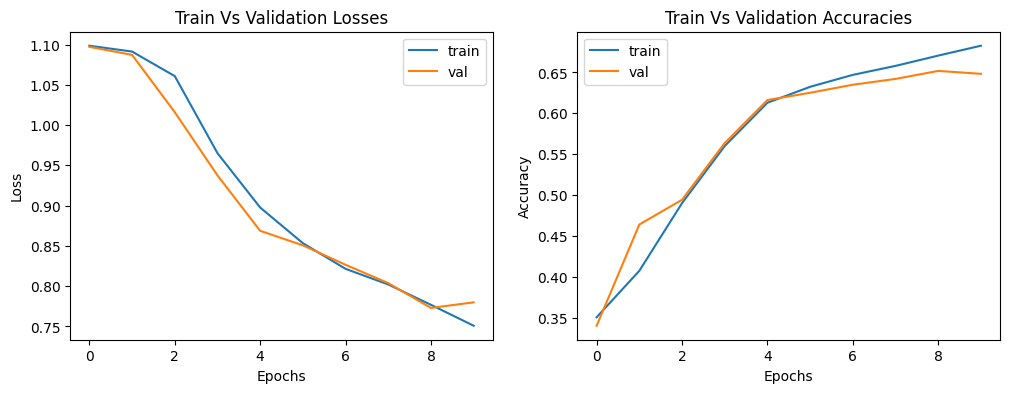

lstm_hidden = 128
Test correct = 464

Test total dataitem = 750

Test Accuracy = 0.6186666488647461

              precision    recall  f1-score   support

    negative       0.59      0.74      0.66       250
     neutral       0.61      0.64      0.63       250
    positive       0.67      0.48      0.56       250

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.61       750
weighted avg       0.63      0.62      0.61       750



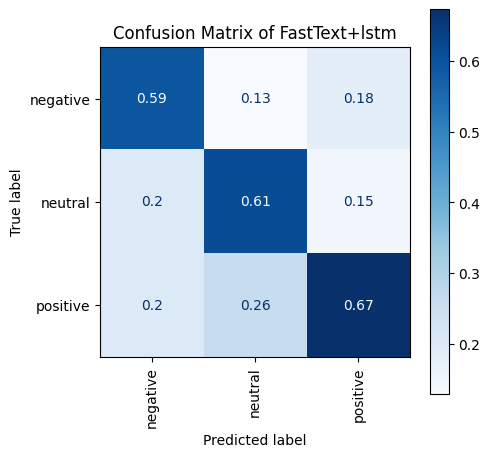

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 115.93it/s]


loss = 1.0966979203000664, val_loss =1.0925390767436178, accuracy = 0.35128769278526306, val_accuracy = 0.4113980531692505


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 118.28it/s]


loss = 1.0768376558553427, val_loss =1.035674062916743, accuracy = 0.4718906879425049, val_accuracy = 0.5155832767486572


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 117.60it/s]


loss = 1.0096904640522553, val_loss =0.9507076369644705, accuracy = 0.5419284105300903, val_accuracy = 0.5779163241386414


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 117.36it/s]


loss = 0.9115310016333024, val_loss =0.8719209512146393, accuracy = 0.6031721234321594, val_accuracy = 0.6242208480834961


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 117.30it/s]


loss = 0.8562534318859253, val_loss =0.8536751315498443, accuracy = 0.6345791220664978, val_accuracy = 0.6170970797538757


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 116.70it/s]


loss = 0.819881640251142, val_loss =0.8051899813783829, accuracy = 0.651695966720581, val_accuracy = 0.6429207921028137


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 115.82it/s]


loss = 0.7815037963499981, val_loss =0.7830950637333445, accuracy = 0.6735238432884216, val_accuracy = 0.6473731398582458


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 116.42it/s]


loss = 0.7603717176698137, val_loss =0.7699720387596504, accuracy = 0.6807475090026855, val_accuracy = 0.6562778353691101


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 116.21it/s]


loss = 0.7352668090860197, val_loss =0.7500692081012525, accuracy = 0.6931532621383667, val_accuracy = 0.6642920970916748


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 108.09it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7168686854214047, val_loss =0.7322400576279173, accuracy = 0.6964510083198547, val_accuracy = 0.6749777793884277


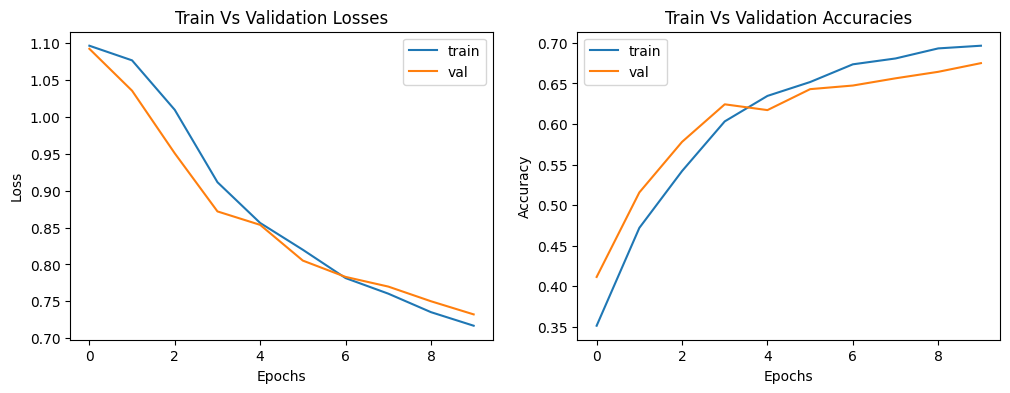

lstm_hidden = 256
Test correct = 470

Test total dataitem = 750

Test Accuracy = 0.6266666650772095

              precision    recall  f1-score   support

    negative       0.64      0.70      0.67       250
     neutral       0.61      0.67      0.63       250
    positive       0.64      0.51      0.57       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.62       750
weighted avg       0.63      0.63      0.62       750



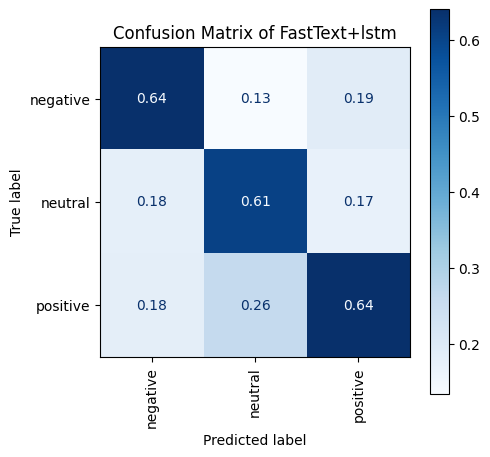

In [ ]:
bidirectional=True
num_layers=1
lstm_hidden_size=[32,64,128,256]
for lstm_hidden in lstm_hidden_size:
  model=LSTM(fasttext_weights,lstm_hidden,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+lstm'
  print(f'lstm_hidden = {lstm_hidden}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 63.02it/s]


loss = 1.098620481286198, val_loss =1.09788442858687, accuracy = 0.3407663404941559, val_accuracy = 0.36242207884788513


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 100.59it/s]


loss = 1.0898306967597455, val_loss =1.0592125297538817, accuracy = 0.4144158363342285, val_accuracy = 0.42831701040267944


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 107.93it/s]


loss = 1.047141290686559, val_loss =1.0118396488454429, accuracy = 0.4974874258041382, val_accuracy = 0.5520926117897034


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 116.65it/s]


loss = 0.9995554737118073, val_loss =0.9487886666952233, accuracy = 0.53972989320755, val_accuracy = 0.5886019468307495


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 116.78it/s]


loss = 0.9458203172829235, val_loss =0.9150048123084985, accuracy = 0.5808731317520142, val_accuracy = 0.5983971357345581


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 115.60it/s]


loss = 0.9059693500546564, val_loss =0.8764164199923269, accuracy = 0.6083542704582214, val_accuracy = 0.6179875731468201


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 115.03it/s]


loss = 0.8811630733047786, val_loss =0.852981925672031, accuracy = 0.6195037364959717, val_accuracy = 0.6313446164131165


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 115.55it/s]


loss = 0.8628309078594611, val_loss =0.8417895154504564, accuracy = 0.629554033279419, val_accuracy = 0.6304541826248169


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 115.07it/s]


loss = 0.8358260217135103, val_loss =0.8124737633972443, accuracy = 0.6490263938903809, val_accuracy = 0.6420302987098694


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 116.30it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.8153572784925928, val_loss =0.7997686544972812, accuracy = 0.6534233689308167, val_accuracy = 0.6491540670394897


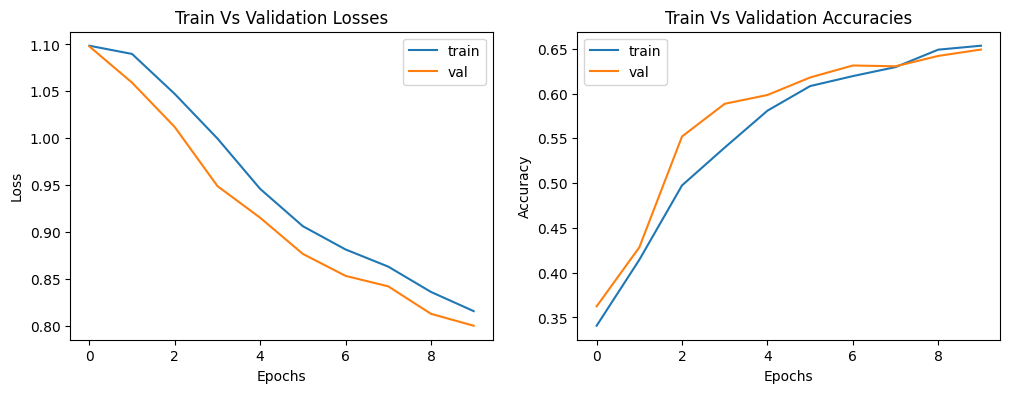

fc_hidden = 16
Test correct = 456

Test total dataitem = 750

Test Accuracy = 0.6079999804496765

              precision    recall  f1-score   support

    negative       0.64      0.63      0.63       250
     neutral       0.57      0.68      0.62       250
    positive       0.62      0.52      0.56       250

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



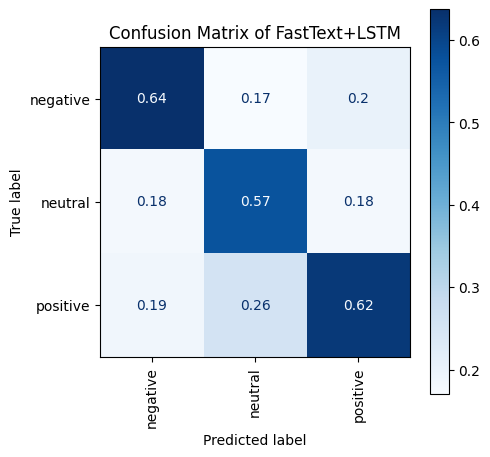

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 110.31it/s]


loss = 1.0990835408400743, val_loss =1.0921075275626093, accuracy = 0.3329145610332489, val_accuracy = 0.3481745421886444


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 104.81it/s]


loss = 1.0773386486433447, val_loss =1.0496169141493739, accuracy = 0.40954774618148804, val_accuracy = 0.5093499422073364


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 107.36it/s]


loss = 1.007823591598426, val_loss =0.9493242001885341, accuracy = 0.5318781137466431, val_accuracy = 0.5565449595451355


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 99.53it/s]


loss = 0.9319999523422302, val_loss =0.8903037220080723, accuracy = 0.5714510083198547, val_accuracy = 0.6375779509544373


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 112.04it/s]


loss = 0.8659966242503288, val_loss =0.8422174680028259, accuracy = 0.6281406879425049, val_accuracy = 0.6464826464653015


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 113.28it/s]


loss = 0.8334301288436836, val_loss =0.8129318817011413, accuracy = 0.641331672668457, val_accuracy = 0.6509349942207336


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 113.45it/s]


loss = 0.8038430132611575, val_loss =0.7847994634609748, accuracy = 0.6567211151123047, val_accuracy = 0.6625111699104309


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 114.54it/s]


loss = 0.7711940713903311, val_loss =0.7711674069152478, accuracy = 0.669283926486969, val_accuracy = 0.6723063588142395


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 114.18it/s]


loss = 0.7643692595247057, val_loss =0.7786786838914734, accuracy = 0.6761934757232666, val_accuracy = 0.6536064147949219


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 110.76it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7362915657793553, val_loss =0.7510817957471094, accuracy = 0.6936243772506714, val_accuracy = 0.6714158654212952


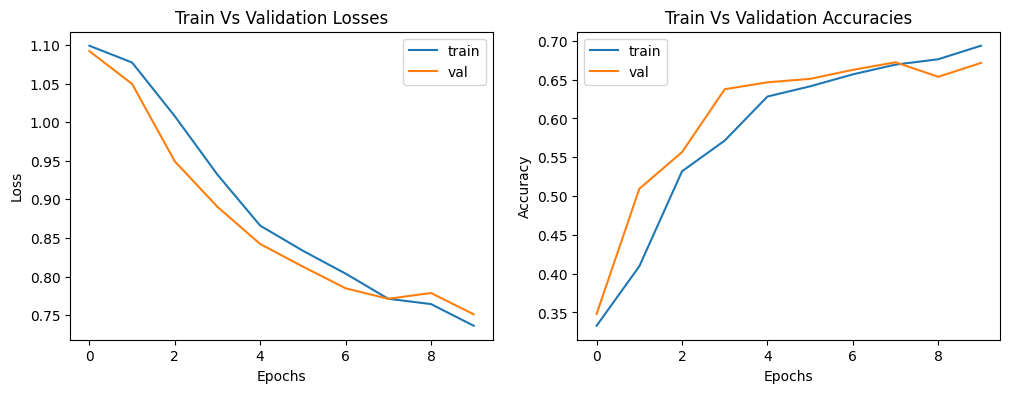

fc_hidden = 32
Test correct = 453

Test total dataitem = 750

Test Accuracy = 0.6039999723434448

              precision    recall  f1-score   support

    negative       0.64      0.63      0.64       250
     neutral       0.56      0.72      0.63       250
    positive       0.63      0.46      0.53       250

    accuracy                           0.60       750
   macro avg       0.61      0.60      0.60       750
weighted avg       0.61      0.60      0.60       750



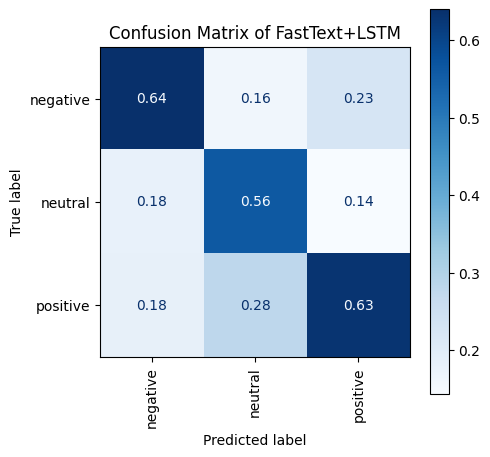

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 97.96it/s]


loss = 1.0971618039999158, val_loss =1.0931101057146277, accuracy = 0.3545854091644287, val_accuracy = 0.36242207884788513


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 94.26it/s]


loss = 1.07180112942704, val_loss =1.0252236389229814, accuracy = 0.4665515124797821, val_accuracy = 0.48441675305366516


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 102.72it/s]


loss = 0.985073913110391, val_loss =0.9361330279343141, accuracy = 0.5675251483917236, val_accuracy = 0.5930543541908264


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 104.14it/s]


loss = 0.9181883181948797, val_loss =0.8929529868093105, accuracy = 0.6044284105300903, val_accuracy = 0.6073018908500671


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 89.33it/s]


loss = 0.8641035682573965, val_loss =0.841637208806129, accuracy = 0.6265703439712524, val_accuracy = 0.6464826464653015


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 71.88it/s]


loss = 0.8242131097276615, val_loss =0.8113205455753829, accuracy = 0.6501256227493286, val_accuracy = 0.6509349942207336


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 73.00it/s]


loss = 0.7845787542106154, val_loss =0.7891473835821672, accuracy = 0.664101779460907, val_accuracy = 0.6527159810066223


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 98.91it/s]


loss = 0.7621357194080656, val_loss =0.762136394086147, accuracy = 0.6754083037376404, val_accuracy = 0.6678539514541626


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 100.28it/s]


loss = 0.7417041099246808, val_loss =0.7684039604572357, accuracy = 0.67902010679245, val_accuracy = 0.6544969081878662


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 111.96it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7210786270453309, val_loss =0.7381870761081541, accuracy = 0.6948806643486023, val_accuracy = 0.6749777793884277


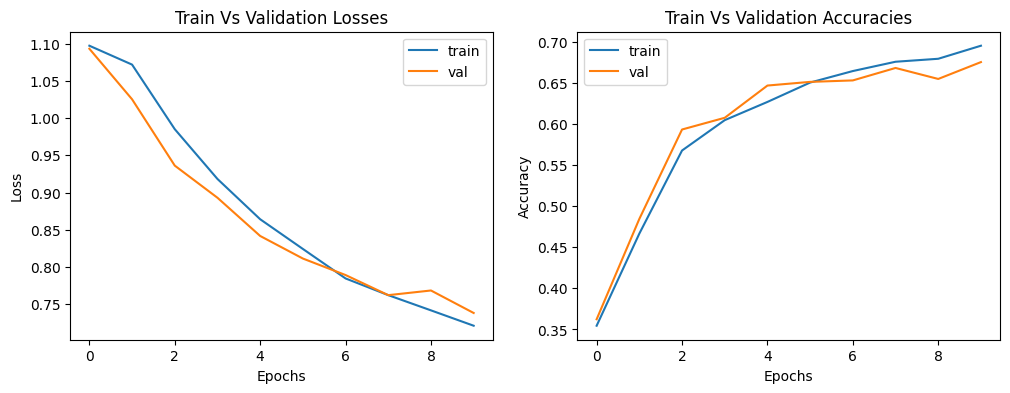

fc_hidden = 64
Test correct = 462

Test total dataitem = 750

Test Accuracy = 0.6159999966621399

              precision    recall  f1-score   support

    negative       0.67      0.60      0.63       250
     neutral       0.58      0.73      0.64       250
    positive       0.62      0.52      0.57       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.61       750
weighted avg       0.62      0.62      0.61       750



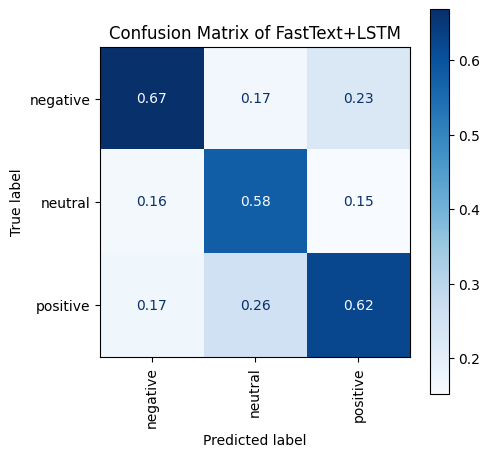

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 112.56it/s]


loss = 1.0953342435136437, val_loss =1.0912614274252619, accuracy = 0.4111180901527405, val_accuracy = 0.47016918659210205


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 112.19it/s]


loss = 1.0664424727018922, val_loss =1.0233024084763158, accuracy = 0.5036118030548096, val_accuracy = 0.496883362531662


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 111.86it/s]


loss = 0.9470753899565898, val_loss =0.8991760703103086, accuracy = 0.5810301303863525, val_accuracy = 0.6162065863609314


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 112.17it/s]


loss = 0.864711763956584, val_loss =0.8488065696999594, accuracy = 0.6267274022102356, val_accuracy = 0.6420302987098694


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 111.89it/s]


loss = 0.8073729920086044, val_loss =0.8230478220032104, accuracy = 0.6584484577178955, val_accuracy = 0.6179875731468201


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 111.90it/s]


loss = 0.7750999456010687, val_loss =0.784951375455444, accuracy = 0.6636306643486023, val_accuracy = 0.6616206765174866


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 103.19it/s]


loss = 0.7398202716703417, val_loss =0.7567271974917117, accuracy = 0.6832600235939026, val_accuracy = 0.6491540670394897


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 107.52it/s]


loss = 0.7180334036284103, val_loss =0.7436652908576348, accuracy = 0.6947236061096191, val_accuracy = 0.6607301831245422


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 101.11it/s]


loss = 0.6987024862405906, val_loss =0.7318847114983775, accuracy = 0.7028894424438477, val_accuracy = 0.6794301271438599


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 103.28it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.678219034575335, val_loss =0.7397177990345101, accuracy = 0.7148241400718689, val_accuracy = 0.6598397493362427


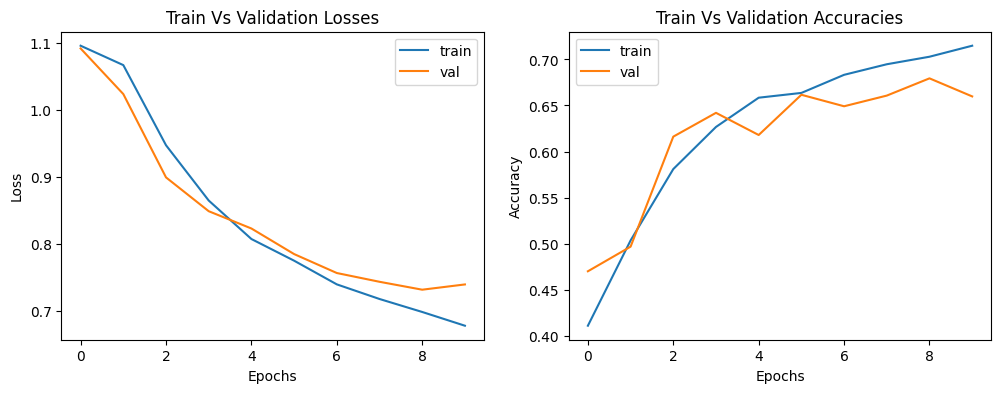

fc_hidden = 128
Test correct = 464

Test total dataitem = 750

Test Accuracy = 0.6186666488647461

              precision    recall  f1-score   support

    negative       0.60      0.75      0.67       250
     neutral       0.62      0.60      0.61       250
    positive       0.64      0.51      0.57       250

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.61       750
weighted avg       0.62      0.62      0.61       750



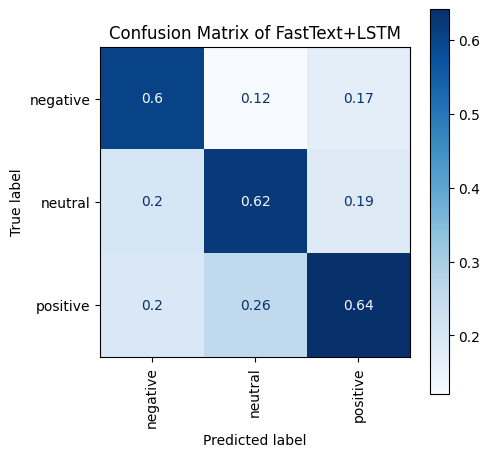

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 113.28it/s]


loss = 1.0939547456800938, val_loss =1.0871461711750026, accuracy = 0.3723303973674774, val_accuracy = 0.47195014357566833


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 112.12it/s]


loss = 1.044126248494722, val_loss =0.9688340173605534, accuracy = 0.5133479833602905, val_accuracy = 0.5556545257568359


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 111.66it/s]


loss = 0.8945938956184546, val_loss =0.8505688673982467, accuracy = 0.6092965006828308, val_accuracy = 0.6153161525726318


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 112.22it/s]


loss = 0.810074327959519, val_loss =0.8004790303983822, accuracy = 0.6513819098472595, val_accuracy = 0.6482635736465454


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 112.46it/s]


loss = 0.77359357661986, val_loss =0.8146289238347746, accuracy = 0.6683416962623596, val_accuracy = 0.6402493715286255


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 112.48it/s]


loss = 0.738282923071647, val_loss =0.7526737250492997, accuracy = 0.6835741400718689, val_accuracy = 0.6731967926025391


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 112.10it/s]


loss = 0.7072952385326562, val_loss =0.7474724171744056, accuracy = 0.7022613286972046, val_accuracy = 0.6678539514541626


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 113.18it/s]


loss = 0.6933642598206734, val_loss =0.7293333636265108, accuracy = 0.7052449584007263, val_accuracy = 0.6821015477180481


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 112.23it/s]


loss = 0.6652353468957335, val_loss =0.7209769185491077, accuracy = 0.7163944840431213, val_accuracy = 0.6945681571960449


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 106.67it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.651222002053164, val_loss =0.7196094403383223, accuracy = 0.7237750887870789, val_accuracy = 0.6856634020805359


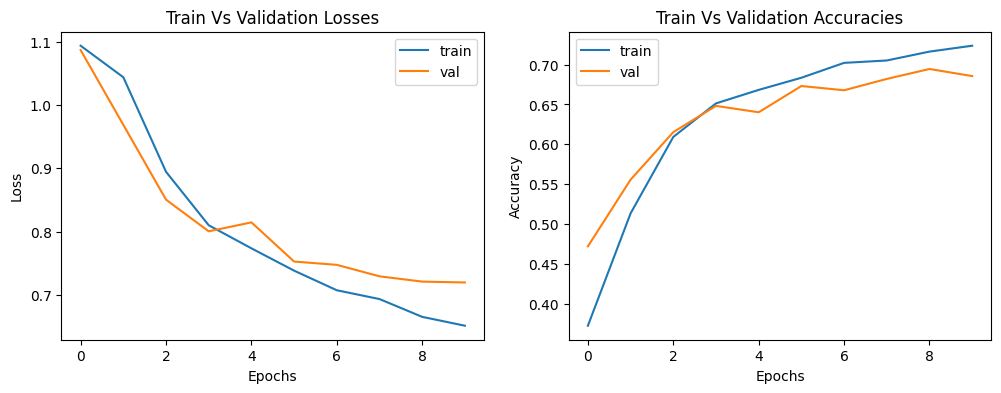

fc_hidden = 256
Test correct = 478

Test total dataitem = 750

Test Accuracy = 0.637333333492279

              precision    recall  f1-score   support

    negative       0.64      0.71      0.67       250
     neutral       0.62      0.68      0.65       250
    positive       0.66      0.53      0.59       250

    accuracy                           0.64       750
   macro avg       0.64      0.64      0.63       750
weighted avg       0.64      0.64      0.63       750



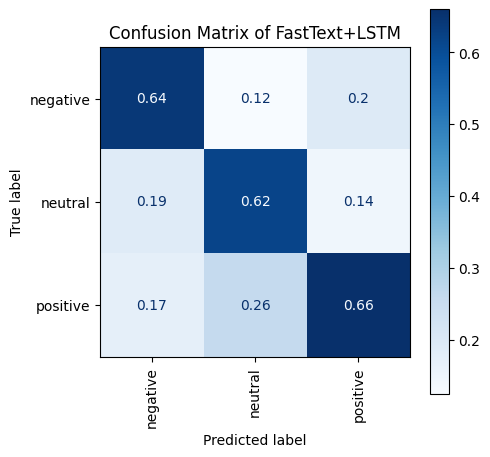

In [ ]:
bidirectional=True
num_layers=1
hidden_size1=256
fc_hidden_size=[16,32,64,128,256]
for fc_hidden in fc_hidden_size:
  model=LSTM(fasttext_weights,hidden_size1,fc_hidden,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+LSTM'
  print(f'fc_hidden = {fc_hidden}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 103.25it/s]


loss = 1.0926118421088904, val_loss =1.0812107942628837, accuracy = 0.4200690984725952, val_accuracy = 0.5182546973228455


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 114.56it/s]


loss = 1.0054436007956975, val_loss =0.9298479191326935, accuracy = 0.5524497628211975, val_accuracy = 0.5716829895973206


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 115.80it/s]


loss = 0.8563279044353113, val_loss =0.8541802799923249, accuracy = 0.6337939500808716, val_accuracy = 0.6251113414764404


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 115.05it/s]


loss = 0.7883790809431229, val_loss =0.7907217130401275, accuracy = 0.661432147026062, val_accuracy = 0.6544969081878662


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 115.38it/s]


loss = 0.7460275361156892, val_loss =0.7674714718809622, accuracy = 0.682945966720581, val_accuracy = 0.6634016036987305


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 111.09it/s]


loss = 0.7150536036828089, val_loss =0.7756088001882139, accuracy = 0.7000628113746643, val_accuracy = 0.6536064147949219


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 107.97it/s]


loss = 0.6924461534036709, val_loss =0.7338310689835265, accuracy = 0.7035175561904907, val_accuracy = 0.6794301271438599


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 106.45it/s]


loss = 0.6722428650660845, val_loss =0.7413575356741878, accuracy = 0.7173366546630859, val_accuracy = 0.6767587065696716


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 102.17it/s]


loss = 0.6515276528373579, val_loss =0.7176750160739925, accuracy = 0.7229899168014526, val_accuracy = 0.677649199962616


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 107.30it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6358695619938635, val_loss =0.7089104412623147, accuracy = 0.7288002371788025, val_accuracy = 0.6865538954734802


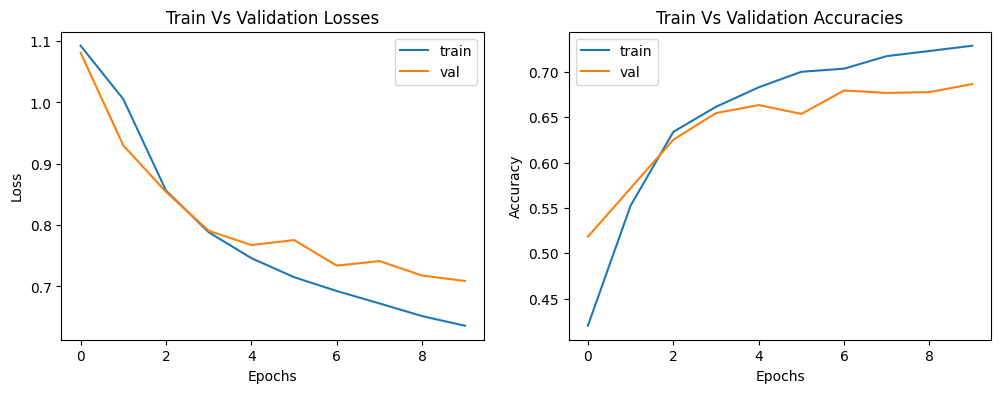

drop_rate = 0.1
Test correct = 477

Test total dataitem = 750

Test Accuracy = 0.6359999775886536

              precision    recall  f1-score   support

    negative       0.69      0.63      0.66       250
     neutral       0.63      0.66      0.64       250
    positive       0.60      0.62      0.61       250

    accuracy                           0.64       750
   macro avg       0.64      0.64      0.64       750
weighted avg       0.64      0.64      0.64       750



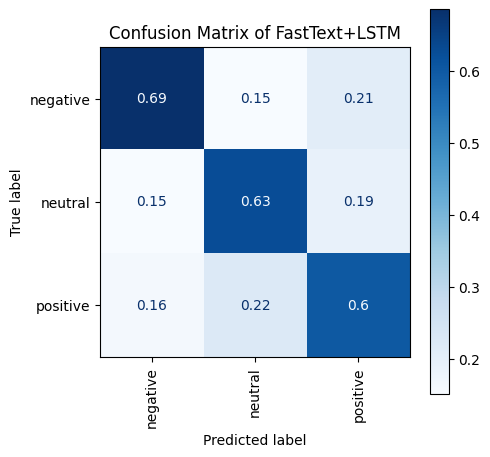

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 113.66it/s]


loss = 1.0932132750656456, val_loss =1.0850735838643262, accuracy = 0.40436556935310364, val_accuracy = 0.4674977958202362


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 114.85it/s]


loss = 1.0203869837225648, val_loss =0.9393309856979786, accuracy = 0.5524497628211975, val_accuracy = 0.577025830745697


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 114.56it/s]


loss = 0.8758107844786719, val_loss =0.8487054787678523, accuracy = 0.623115599155426, val_accuracy = 0.6331255435943604


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 114.42it/s]


loss = 0.7968996839813189, val_loss =0.8222236255235094, accuracy = 0.6612750887870789, val_accuracy = 0.6420302987098694


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 113.94it/s]


loss = 0.7562771575925944, val_loss =0.7792841930866301, accuracy = 0.676350474357605, val_accuracy = 0.6553874015808105


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 114.63it/s]


loss = 0.7274384050210029, val_loss =0.7536161986182423, accuracy = 0.6909547448158264, val_accuracy = 0.6571683287620544


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 114.72it/s]


loss = 0.7025390306758709, val_loss =0.741940201587146, accuracy = 0.7013190984725952, val_accuracy = 0.666963517665863


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 107.70it/s]


loss = 0.6813270681150879, val_loss =0.7294466329287734, accuracy = 0.7127826809883118, val_accuracy = 0.6767587065696716


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 73.15it/s]


loss = 0.6640043287697199, val_loss =0.7239464522280532, accuracy = 0.7163944840431213, val_accuracy = 0.6785396337509155


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 57.65it/s]


loss = 0.6462765748541642, val_loss =0.7190087879071951, accuracy = 0.7305276393890381, val_accuracy = 0.6740872859954834


<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


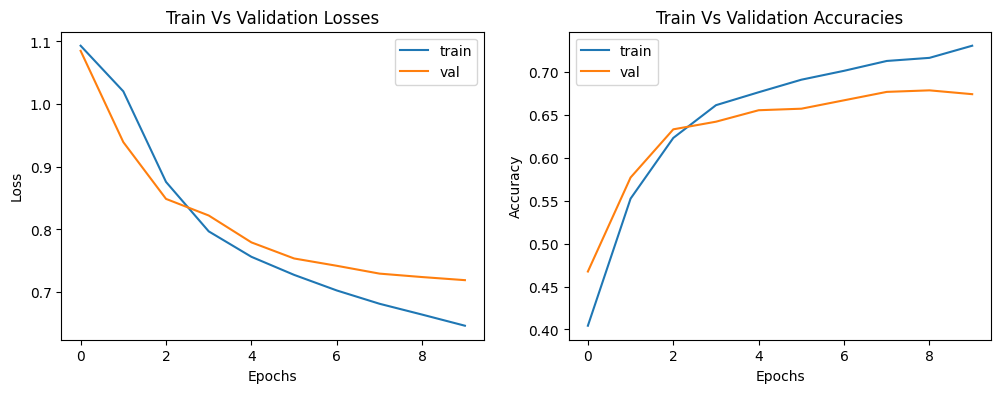

drop_rate = 0.2
Test correct = 478

Test total dataitem = 750

Test Accuracy = 0.637333333492279

              precision    recall  f1-score   support

    negative       0.65      0.70      0.67       250
     neutral       0.62      0.68      0.65       250
    positive       0.65      0.53      0.58       250

    accuracy                           0.64       750
   macro avg       0.64      0.64      0.64       750
weighted avg       0.64      0.64      0.64       750



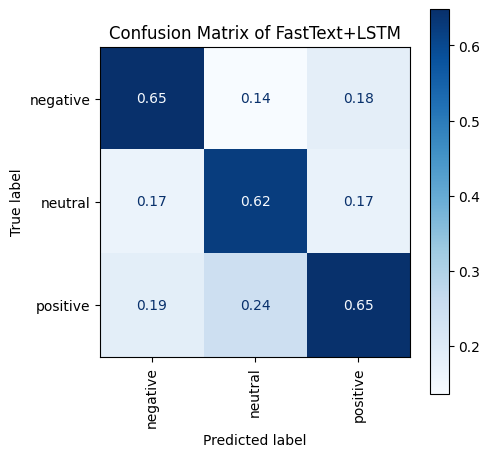

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 62.90it/s]


loss = 1.094532405603677, val_loss =1.0866042302729237, accuracy = 0.38002511858940125, val_accuracy = 0.4853072166442871


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 100.31it/s]


loss = 1.037053286182927, val_loss =0.9883741135723771, accuracy = 0.5262248516082764, val_accuracy = 0.4888691008090973


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 97.97it/s]


loss = 0.8700682660499297, val_loss =0.8384414056236791, accuracy = 0.6218593120574951, val_accuracy = 0.6242208480834961


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 99.70it/s]


loss = 0.797357182700398, val_loss =0.7938078372292073, accuracy = 0.6567211151123047, val_accuracy = 0.6500445604324341


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 103.90it/s]


loss = 0.757977772086615, val_loss =0.7686558687068533, accuracy = 0.6727386713027954, val_accuracy = 0.6642920970916748


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 112.21it/s]


loss = 0.730292246141189, val_loss =0.7590550503043766, accuracy = 0.6857725977897644, val_accuracy = 0.6616206765174866


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 114.01it/s]


loss = 0.7042100118004054, val_loss =0.7495780742954392, accuracy = 0.6984924674034119, val_accuracy = 0.6687444448471069


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 113.48it/s]


loss = 0.6888744330300187, val_loss =0.7402500705106326, accuracy = 0.7055590152740479, val_accuracy = 0.683882474899292


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 113.40it/s]


loss = 0.6680267442816148, val_loss =0.7180527044849038, accuracy = 0.7137248516082764, val_accuracy = 0.6918967366218567


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 61.92it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6531058839977549, val_loss =0.7159085811737087, accuracy = 0.7222047448158264, val_accuracy = 0.6954585909843445


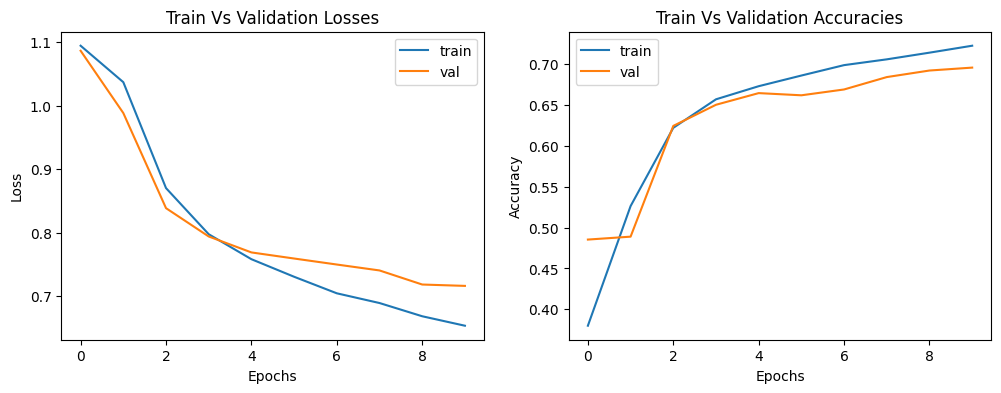

drop_rate = 0.3
Test correct = 476

Test total dataitem = 750

Test Accuracy = 0.6346666812896729

              precision    recall  f1-score   support

    negative       0.68      0.64      0.66       250
     neutral       0.65      0.62      0.64       250
    positive       0.58      0.64      0.61       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.64       750
weighted avg       0.64      0.63      0.64       750



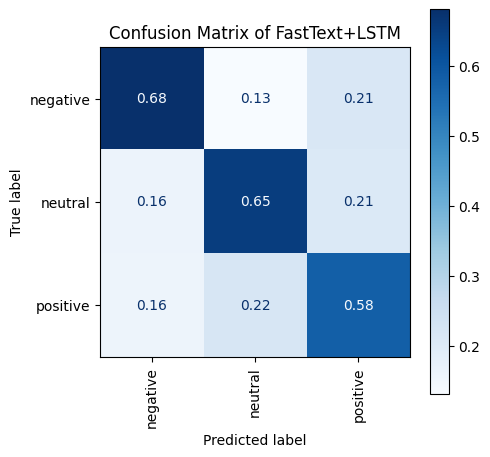

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 106.17it/s]


loss = 1.0939119227603078, val_loss =1.086045640977543, accuracy = 0.4015389382839203, val_accuracy = 0.5209261178970337


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 102.25it/s]


loss = 1.0383032174641267, val_loss =0.9599837043196968, accuracy = 0.534547746181488, val_accuracy = 0.5805877447128296


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 103.10it/s]


loss = 0.8773946056736167, val_loss =0.8499254297981564, accuracy = 0.6191896796226501, val_accuracy = 0.619768500328064


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 113.33it/s]


loss = 0.7992064171803213, val_loss =0.8164313083936807, accuracy = 0.6576632857322693, val_accuracy = 0.6286731958389282


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 111.79it/s]


loss = 0.7663694703199871, val_loss =0.7691552892277879, accuracy = 0.6717965006828308, val_accuracy = 0.6509349942207336


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 113.06it/s]


loss = 0.7274747854314318, val_loss =0.7580626310214506, accuracy = 0.6914258599281311, val_accuracy = 0.6598397493362427


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 112.84it/s]


loss = 0.7074642540643526, val_loss =0.7416533982846943, accuracy = 0.697236180305481, val_accuracy = 0.6767587065696716


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 112.43it/s]


loss = 0.6878258830977961, val_loss =0.7288704860325789, accuracy = 0.7086997628211975, val_accuracy = 0.6803205609321594


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 113.09it/s]


loss = 0.6652772039388491, val_loss =0.7453831413618813, accuracy = 0.7174937129020691, val_accuracy = 0.6616206765174866


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 111.28it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6462440053138345, val_loss =0.7075434843209107, accuracy = 0.7237750887870789, val_accuracy = 0.6856634020805359


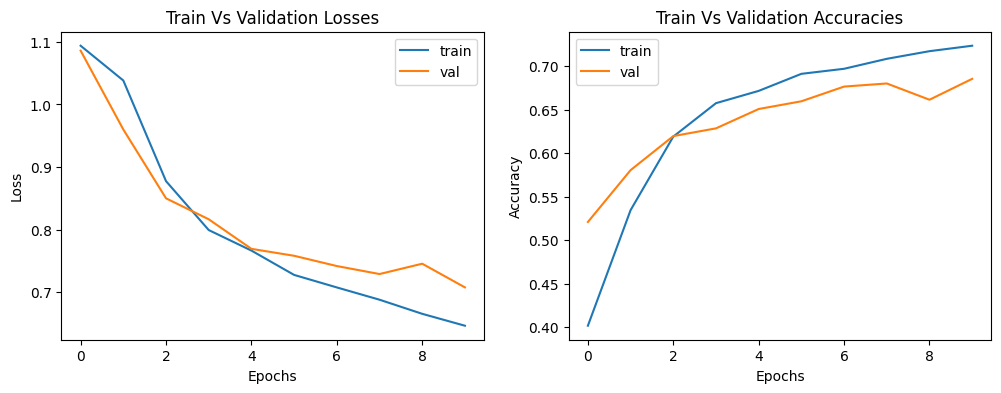

drop_rate = 0.4
Test correct = 472

Test total dataitem = 750

Test Accuracy = 0.6293333172798157

              precision    recall  f1-score   support

    negative       0.67      0.66      0.66       250
     neutral       0.61      0.66      0.64       250
    positive       0.61      0.57      0.59       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.63       750
weighted avg       0.63      0.63      0.63       750



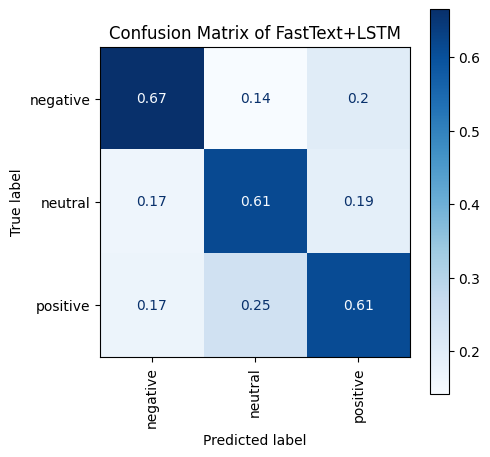

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 114.15it/s]


loss = 1.0944518192950636, val_loss =1.0881121827200766, accuracy = 0.40782034397125244, val_accuracy = 0.506678581237793


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 113.84it/s]


loss = 1.0519059450761414, val_loss =0.9690556942387336, accuracy = 0.5196294188499451, val_accuracy = 0.5494211912155151


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 106.50it/s]


loss = 0.9069337809814897, val_loss =0.8956903888954363, accuracy = 0.6048994660377502, val_accuracy = 0.5779163241386414


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 106.33it/s]


loss = 0.8250426573504228, val_loss =0.8130710120238724, accuracy = 0.6463567614555359, val_accuracy = 0.6331255435943604


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 102.93it/s]


loss = 0.7736497634703846, val_loss =0.7753209812625539, accuracy = 0.6724246144294739, val_accuracy = 0.6473731398582458


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 102.39it/s]


loss = 0.7430908628163706, val_loss =0.7510319875194303, accuracy = 0.6827889084815979, val_accuracy = 0.6731967926025391


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 109.18it/s]


loss = 0.7197350093306705, val_loss =0.7386098534868483, accuracy = 0.6923680901527405, val_accuracy = 0.6767587065696716


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 112.45it/s]


loss = 0.6923304546945497, val_loss =0.7304643116391537, accuracy = 0.7086997628211975, val_accuracy = 0.6731967926025391


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 112.41it/s]


loss = 0.6739314940143504, val_loss =0.7258995805022659, accuracy = 0.7165514826774597, val_accuracy = 0.6803205609321594


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 112.22it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6612362617305143, val_loss =0.7198766646649823, accuracy = 0.7162374258041382, val_accuracy = 0.6803205609321594


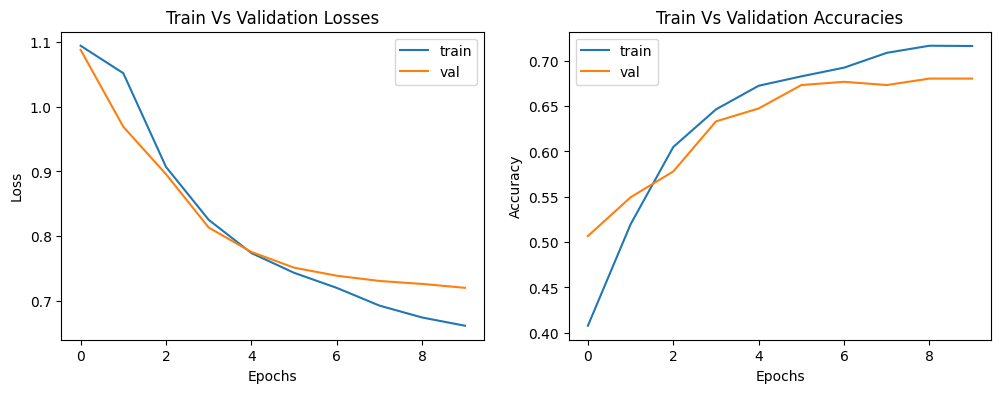

drop_rate = 0.5
Test correct = 477

Test total dataitem = 750

Test Accuracy = 0.6359999775886536

              precision    recall  f1-score   support

    negative       0.64      0.73      0.68       250
     neutral       0.60      0.70      0.65       250
    positive       0.68      0.48      0.57       250

    accuracy                           0.64       750
   macro avg       0.64      0.64      0.63       750
weighted avg       0.64      0.64      0.63       750



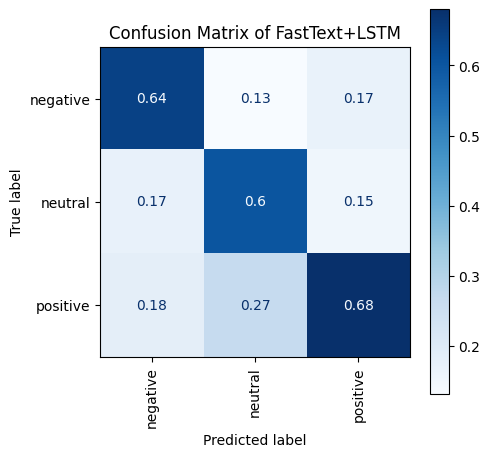

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 107.38it/s]


loss = 1.0953390535339713, val_loss =1.0909354739600703, accuracy = 0.37782663106918335, val_accuracy = 0.464826375246048


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 104.91it/s]


loss = 1.063760011086706, val_loss =0.9896601643524178, accuracy = 0.5216708779335022, val_accuracy = 0.5396260023117065


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 103.70it/s]


loss = 0.9315447165464866, val_loss =0.8841712858035443, accuracy = 0.5917085409164429, val_accuracy = 0.6135351657867432


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 99.96it/s]


loss = 0.8392320368627406, val_loss =0.8340302430577891, accuracy = 0.6429020166397095, val_accuracy = 0.6357969641685486


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 101.66it/s]


loss = 0.7825355052050145, val_loss =0.7919005622703624, accuracy = 0.6672424674034119, val_accuracy = 0.6384683847427368


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 106.99it/s]


loss = 0.7575942344000578, val_loss =0.7674738899385649, accuracy = 0.6727386713027954, val_accuracy = 0.6634016036987305


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 102.45it/s]


loss = 0.729341135750692, val_loss =0.7509607787121486, accuracy = 0.6912688612937927, val_accuracy = 0.6642920970916748


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 101.99it/s]


loss = 0.7045122856987382, val_loss =0.7481627313510779, accuracy = 0.7086997628211975, val_accuracy = 0.6660730242729187


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 99.71it/s]


loss = 0.690144658365507, val_loss =0.7258982512488266, accuracy = 0.7094849348068237, val_accuracy = 0.6892253160476685


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 91.34it/s]


loss = 0.6710222116157183, val_loss =0.7299207181828804, accuracy = 0.716865599155426, val_accuracy = 0.677649199962616


<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


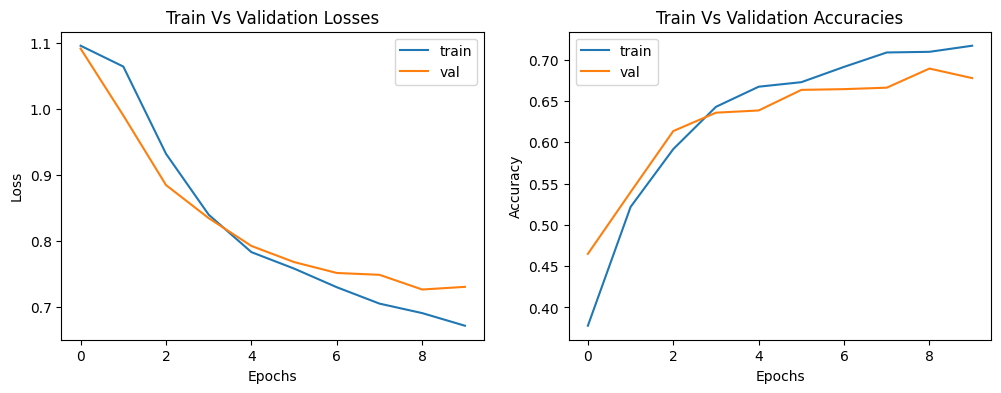

drop_rate = 0.6
Test correct = 470

Test total dataitem = 750

Test Accuracy = 0.6266666650772095

              precision    recall  f1-score   support

    negative       0.66      0.67      0.66       250
     neutral       0.57      0.74      0.64       250
    positive       0.69      0.47      0.56       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.62       750
weighted avg       0.64      0.63      0.62       750



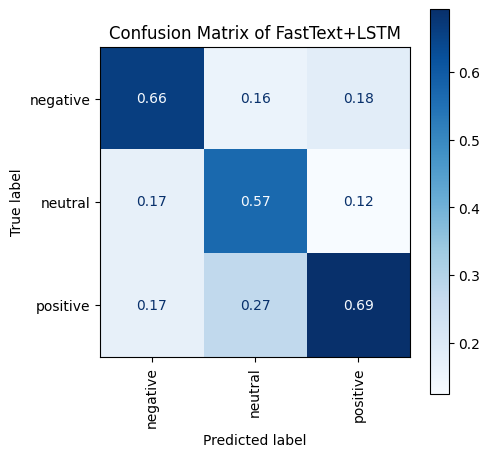

In [ ]:
bidirectional=True
num_layers=1
hidden_size1=256
hidden_size2=256
drop_rates=[0.1,0.2,0.3,0.4,0.5,0.6]
for drop_rate in drop_rates:
  model=LSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,drop_rate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+LSTM'
  print(f'drop_rate = {drop_rate}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:00<00:00, 104.09it/s]


loss = 1.0946472798194735, val_loss =1.088237239853553, accuracy = 0.3622801601886749, val_accuracy = 0.4577026069164276


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 114.58it/s]


loss = 1.0482576234312728, val_loss =0.9771889554998202, accuracy = 0.5191583037376404, val_accuracy = 0.538735568523407


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 115.55it/s]


loss = 0.9131851623122202, val_loss =0.856902172189023, accuracy = 0.6056846380233765, val_accuracy = 0.6206589937210083


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 115.59it/s]


loss = 0.8205562045232364, val_loss =0.8271514875254647, accuracy = 0.6429020166397095, val_accuracy = 0.6206589937210083


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 115.65it/s]


loss = 0.7735866155076837, val_loss =0.7844742687127904, accuracy = 0.6680276393890381, val_accuracy = 0.6553874015808105


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 114.57it/s]


loss = 0.7362807934304283, val_loss =0.7639569929802082, accuracy = 0.6827889084815979, val_accuracy = 0.6509349942207336


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 114.29it/s]


loss = 0.714208313851559, val_loss =0.7443098556135074, accuracy = 0.695351779460907, val_accuracy = 0.6785396337509155


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 108.02it/s]


loss = 0.6990102547511315, val_loss =0.763349686578283, accuracy = 0.7008479833602905, val_accuracy = 0.658058762550354


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 105.92it/s]


loss = 0.6732469542083754, val_loss =0.7145194150134846, accuracy = 0.715452253818512, val_accuracy = 0.6803205609321594


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 89.60it/s]


loss = 0.6602231437695627, val_loss =0.7247951918684362, accuracy = 0.7179648280143738, val_accuracy = 0.6767587065696716


<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


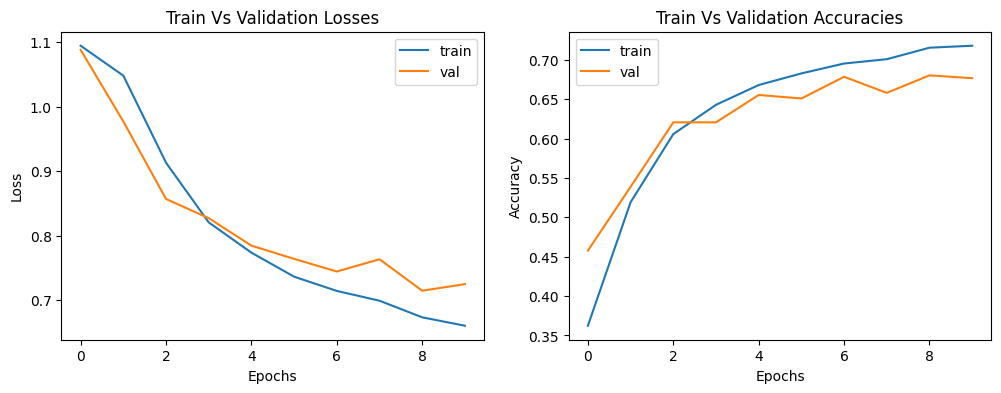

freeze_embedding = True
Test correct = 469

Test total dataitem = 750

Test Accuracy = 0.625333309173584

              precision    recall  f1-score   support

    negative       0.62      0.68      0.65       250
     neutral       0.67      0.58      0.62       250
    positive       0.60      0.61      0.60       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.62       750
weighted avg       0.63      0.63      0.62       750



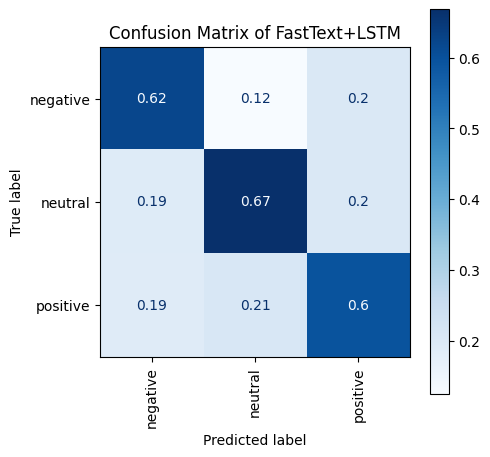

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 79.74it/s]


loss = 1.0941429723240435, val_loss =1.0869826752411587, accuracy = 0.3872487246990204, val_accuracy = 0.49777382612228394


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 59.92it/s]


loss = 1.0129398041241802, val_loss =0.8972102258753564, accuracy = 0.5405150651931763, val_accuracy = 0.6170970797538757


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.51it/s]


loss = 0.7693493454970303, val_loss =0.7314221995546957, accuracy = 0.6780778765678406, val_accuracy = 0.6865538954734802


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 86.06it/s]


loss = 0.6264079410858221, val_loss =0.6428440663615985, accuracy = 0.7404208183288574, val_accuracy = 0.7399821877479553


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 62.60it/s]


loss = 0.5414857912978231, val_loss =0.6104824560595912, accuracy = 0.7817211151123047, val_accuracy = 0.7435441017150879


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 87.83it/s]


loss = 0.47597129316345105, val_loss =0.6044080083675216, accuracy = 0.8087311387062073, val_accuracy = 0.7471059560775757


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 86.94it/s]


loss = 0.4345255003374331, val_loss =0.6089973490501106, accuracy = 0.8261620402336121, val_accuracy = 0.7488869428634644


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 85.28it/s]


loss = 0.39721834349257434, val_loss =0.6101733462596364, accuracy = 0.8409233689308167, val_accuracy = 0.7515583634376526


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 82.54it/s]


loss = 0.3628411733998758, val_loss =0.587359758655989, accuracy = 0.8577260971069336, val_accuracy = 0.756901204586029


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 83.39it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.3458090217435787, val_loss =0.6429406485869004, accuracy = 0.8680904507637024, val_accuracy = 0.7435441017150879


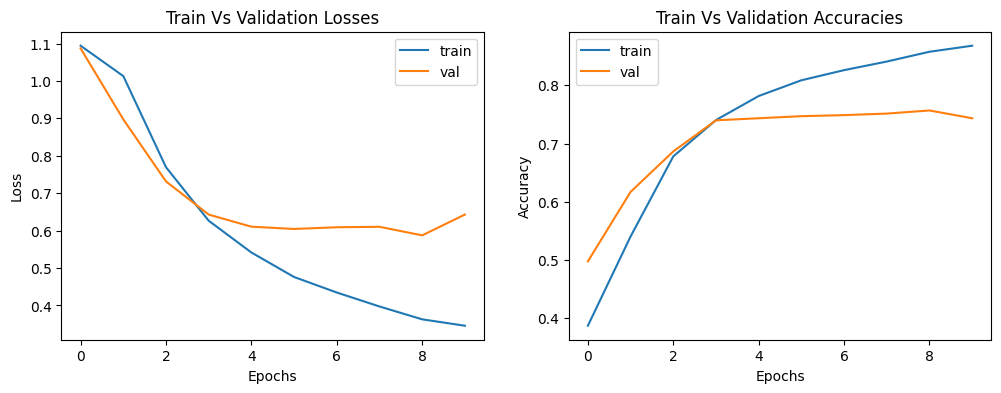

freeze_embedding = False
Test correct = 483

Test total dataitem = 750

Test Accuracy = 0.6439999938011169

              precision    recall  f1-score   support

    negative       0.70      0.60      0.65       250
     neutral       0.57      0.78      0.66       250
    positive       0.71      0.54      0.62       250

    accuracy                           0.64       750
   macro avg       0.66      0.64      0.64       750
weighted avg       0.66      0.64      0.64       750



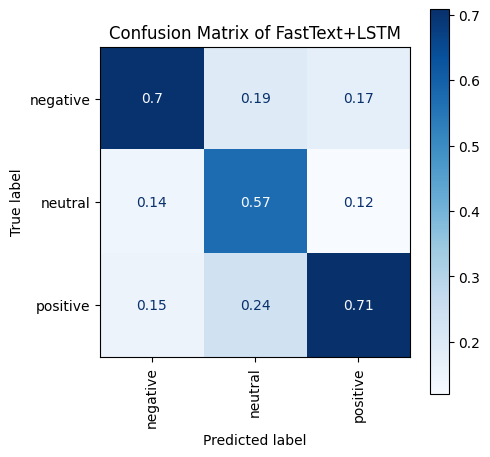

In [ ]:
bidirectional=True
num_layers=1
hidden_size1=256
hidden_size2=256
droprate=0.5
freeze_options=[True,False]
for freeze in freeze_options:
  model=LSTM(fasttext_weights,hidden_size1,hidden_size2,freeze,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+LSTM'
  print(f'freeze_embedding = {freeze}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 83.23it/s]


loss = 2.7426778028484513, val_loss =1.1588838039918952, accuracy = 0.3280464708805084, val_accuracy = 0.33659839630126953


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.02it/s]


loss = 1.1217904054736063, val_loss =1.1214751774148364, accuracy = 0.33699747920036316, val_accuracy = 0.3437221944332123


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 84.95it/s]


loss = 1.1130385213405092, val_loss =1.1020589178546318, accuracy = 0.33699747920036316, val_accuracy = 0.3339269757270813


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 89.73it/s]


loss = 1.1366219886816498, val_loss =1.1033391505567587, accuracy = 0.34375, val_accuracy = 0.3196794390678406


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 90.25it/s]


loss = 1.116407662497385, val_loss =1.097081126051368, accuracy = 0.34390702843666077, val_accuracy = 0.3339269757270813


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 90.43it/s]


loss = 1.1239693416522984, val_loss =1.1020427343066013, accuracy = 0.3393530249595642, val_accuracy = 0.3463935852050781


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 89.91it/s]


loss = 1.1148411869527015, val_loss =1.11008220107132, accuracy = 0.3333856761455536, val_accuracy = 0.31700801849365234


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 90.18it/s]


loss = 1.101557365147455, val_loss =1.1004057808631351, accuracy = 0.33746859431266785, val_accuracy = 0.3463935852050781


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 90.09it/s]


loss = 1.1110170118394307, val_loss =1.1060378600044976, accuracy = 0.33228641748428345, val_accuracy = 0.3357079327106476


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 89.18it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 1.1227636241240215, val_loss =1.410750761064366, accuracy = 0.33055904507637024, val_accuracy = 0.34906500577926636


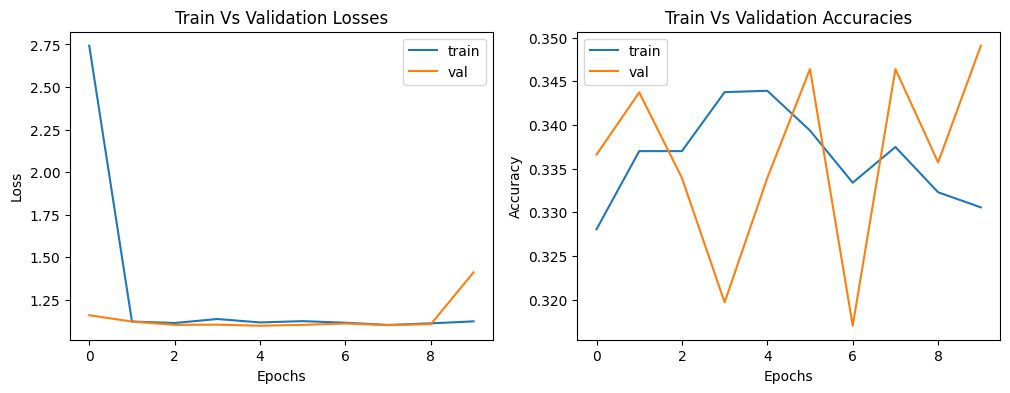

learning_rate = 0.1
Test correct = 240

Test total dataitem = 750

Test Accuracy = 0.3199999928474426

              precision    recall  f1-score   support

    negative       0.31      0.06      0.11       250
     neutral       0.10      0.00      0.01       250
    positive       0.32      0.89      0.48       250

    accuracy                           0.32       750
   macro avg       0.24      0.32      0.20       750
weighted avg       0.24      0.32      0.20       750



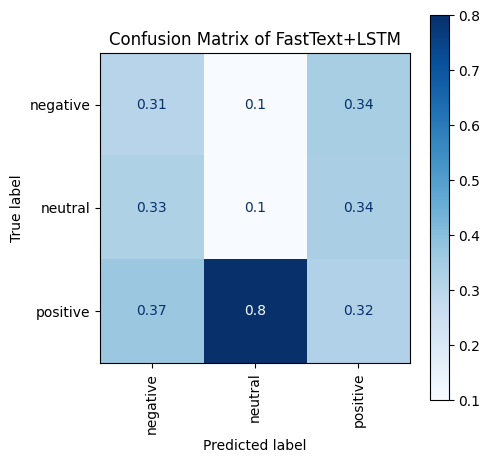

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 87.44it/s]


loss = 0.8445311168714136, val_loss =0.6683452315230228, accuracy = 0.6162060499191284, val_accuracy = 0.7043633460998535


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 84.33it/s]


loss = 0.5154436685760214, val_loss =0.7024688511571073, accuracy = 0.7939698696136475, val_accuracy = 0.7373107671737671


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 83.30it/s]


loss = 0.3689721333568244, val_loss =0.6848634102173905, accuracy = 0.8563128113746643, val_accuracy = 0.7301869988441467


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 84.88it/s]


loss = 0.2829504828144232, val_loss =0.8594033840085271, accuracy = 0.8885050415992737, val_accuracy = 0.7373107671737671


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 86.31it/s]


loss = 0.23673819017059652, val_loss =0.9844999648853574, accuracy = 0.9056218266487122, val_accuracy = 0.7373107671737671


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 87.12it/s]


loss = 0.2155457894466165, val_loss =1.207265004665467, accuracy = 0.9170854091644287, val_accuracy = 0.7426536083221436


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 87.14it/s]


loss = 0.17732642986368422, val_loss =1.4135531584932481, accuracy = 0.9313756227493286, val_accuracy = 0.7346394062042236


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 87.01it/s]


loss = 0.18601353828319336, val_loss =1.6438614814235644, accuracy = 0.9285489916801453, val_accuracy = 0.7177203893661499


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 87.24it/s]


loss = 0.19356025391749843, val_loss =1.525685506595248, accuracy = 0.9287060499191284, val_accuracy = 0.7203918099403381


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 87.30it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.20015551055679898, val_loss =1.7050288849113275, accuracy = 0.9261934757232666, val_accuracy = 0.7052537798881531


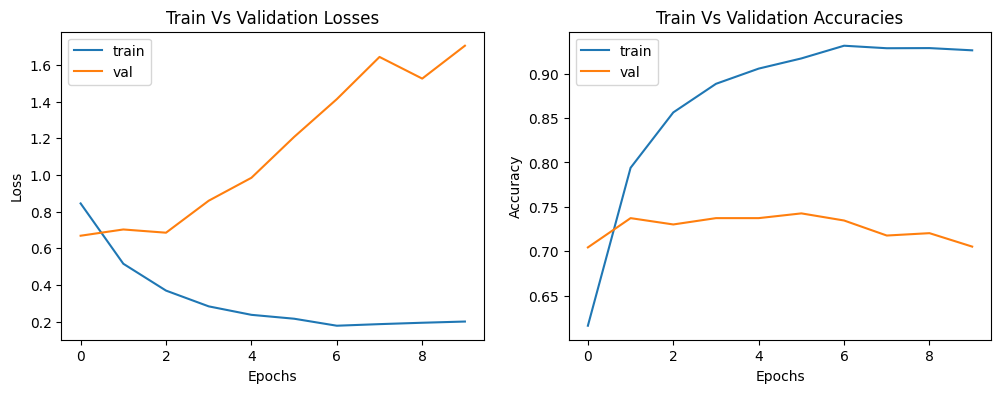

learning_rate = 0.01
Test correct = 441

Test total dataitem = 750

Test Accuracy = 0.5879999995231628

              precision    recall  f1-score   support

    negative       0.70      0.48      0.57       250
     neutral       0.54      0.67      0.60       250
    positive       0.57      0.61      0.59       250

    accuracy                           0.59       750
   macro avg       0.60      0.59      0.59       750
weighted avg       0.60      0.59      0.59       750



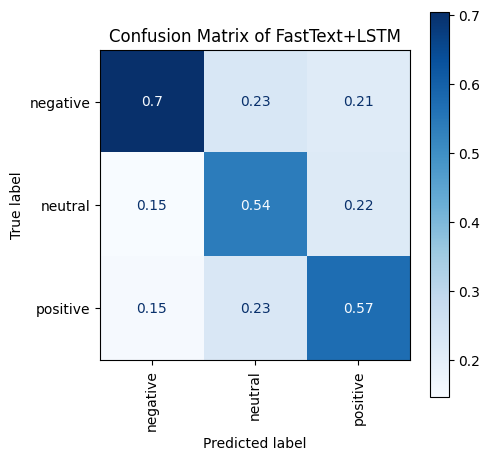

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 87.67it/s]


loss = 0.8521334403433184, val_loss =0.6422053007904507, accuracy = 0.5957914590835571, val_accuracy = 0.7132680416107178


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.03it/s]


loss = 0.5100716756516138, val_loss =0.6594920578339757, accuracy = 0.7922424674034119, val_accuracy = 0.7150489687919617


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 85.18it/s]


loss = 0.38647753968561327, val_loss =0.5993046933663682, accuracy = 0.84375, val_accuracy = 0.7542297840118408


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 83.21it/s]


loss = 0.3059693444039876, val_loss =0.6508690556651042, accuracy = 0.8836369514465332, val_accuracy = 0.7488869428634644


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 85.64it/s]


loss = 0.26136912602526524, val_loss =0.743000852190896, accuracy = 0.8982412219047546, val_accuracy = 0.7533392906188965


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 87.01it/s]


loss = 0.21389915359712058, val_loss =0.813301793072918, accuracy = 0.916614294052124, val_accuracy = 0.7346394062042236


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 88.05it/s]


loss = 0.1894323923435682, val_loss =0.8905746779115723, accuracy = 0.9221105575561523, val_accuracy = 0.7373107671737671


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 88.62it/s]


loss = 0.15947471246077075, val_loss =1.0213985266733152, accuracy = 0.934202253818512, val_accuracy = 0.7301869988441467


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 88.17it/s]


loss = 0.13301060099496545, val_loss =1.0475753975183235, accuracy = 0.9455087780952454, val_accuracy = 0.7284060716629028


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 88.32it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.11190450307025443, val_loss =1.257371878885193, accuracy = 0.953831672668457, val_accuracy = 0.7284060716629028


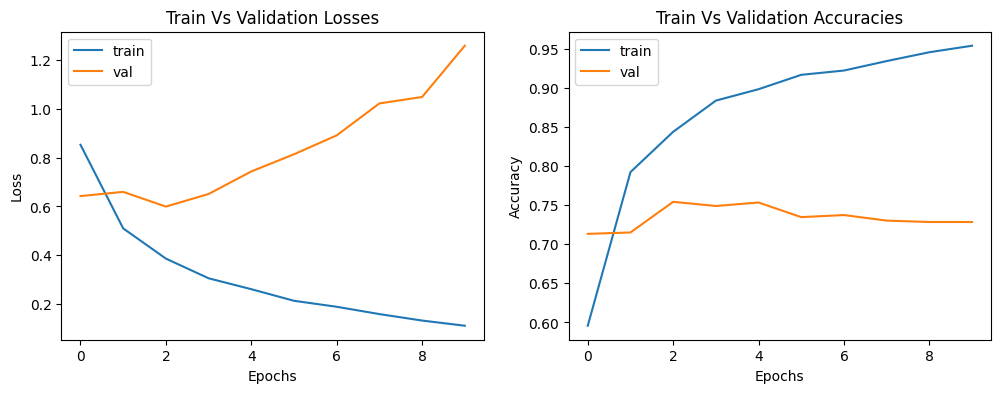

learning_rate = 0.001
Test correct = 478

Test total dataitem = 750

Test Accuracy = 0.637333333492279

              precision    recall  f1-score   support

    negative       0.75      0.52      0.61       250
     neutral       0.58      0.75      0.66       250
    positive       0.63      0.64      0.64       250

    accuracy                           0.64       750
   macro avg       0.65      0.64      0.64       750
weighted avg       0.65      0.64      0.64       750



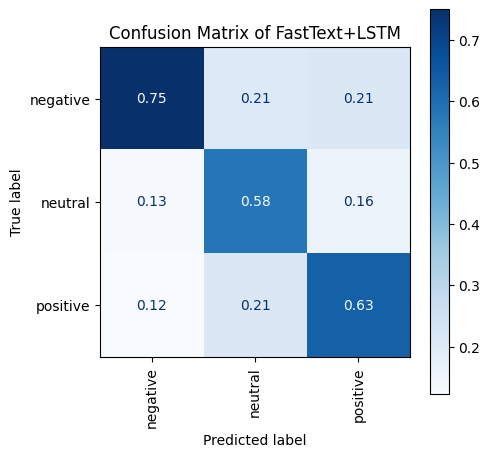

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 87.95it/s]


loss = 0.8026310637775146, val_loss =0.6591801089250127, accuracy = 0.6281406879425049, val_accuracy = 0.7203918099403381


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.73it/s]


loss = 0.4870955438484683, val_loss =0.5737688758897317, accuracy = 0.8024497628211975, val_accuracy = 0.7542297840118408


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.51it/s]


loss = 0.3563959081646799, val_loss =0.6926310327310922, accuracy = 0.860081672668457, val_accuracy = 0.7399821877479553


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 83.94it/s]


loss = 0.2826571627035892, val_loss =0.7372639776745469, accuracy = 0.8864635825157166, val_accuracy = 0.7497773766517639


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 85.73it/s]


loss = 0.222194054949759, val_loss =0.7821770801303223, accuracy = 0.9090766310691833, val_accuracy = 0.7453250288963318


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 84.06it/s]


loss = 0.17775109601080463, val_loss =0.9116343468350269, accuracy = 0.9271356463432312, val_accuracy = 0.7230632305145264


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 85.96it/s]


loss = 0.14387301387530793, val_loss =1.005930230040742, accuracy = 0.9400125741958618, val_accuracy = 0.7426536083221436


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 88.72it/s]


loss = 0.1336679913687337, val_loss =1.144219751028382, accuracy = 0.9451947212219238, val_accuracy = 0.7435441017150879


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 88.61it/s]


loss = 0.11647568231479388, val_loss =1.2473110542740806, accuracy = 0.9499057531356812, val_accuracy = 0.7346394062042236


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 88.42it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.09995850236117333, val_loss =1.347683366354653, accuracy = 0.9569723606109619, val_accuracy = 0.7471059560775757


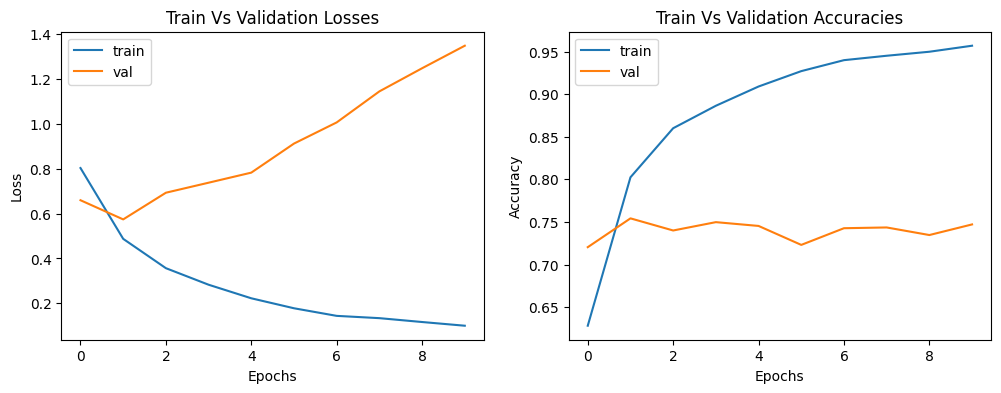

learning_rate = 0.002
Test correct = 457

Test total dataitem = 750

Test Accuracy = 0.609333336353302

              precision    recall  f1-score   support

    negative       0.70      0.52      0.60       250
     neutral       0.55      0.67      0.60       250
    positive       0.61      0.64      0.62       250

    accuracy                           0.61       750
   macro avg       0.62      0.61      0.61       750
weighted avg       0.62      0.61      0.61       750



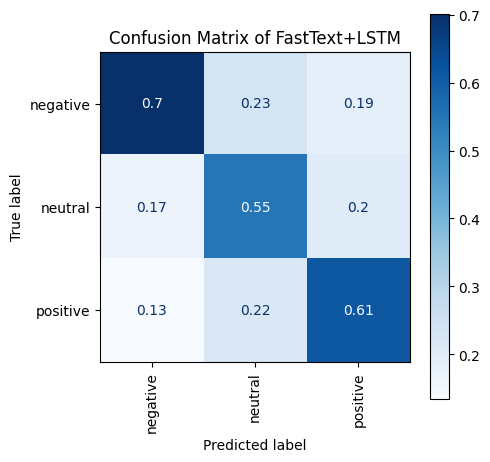

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 88.73it/s]


loss = 0.8075195549634964, val_loss =0.6672827550069621, accuracy = 0.6284547448158264, val_accuracy = 0.715939462184906


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.72it/s]


loss = 0.4970463177690123, val_loss =0.6472217521592671, accuracy = 0.8044912219047546, val_accuracy = 0.715939462184906


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.64it/s]


loss = 0.3580610361735823, val_loss =0.6426246766529653, accuracy = 0.8523869514465332, val_accuracy = 0.7577916383743286


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 88.41it/s]


loss = 0.26346630229417933, val_loss =0.7787925184165655, accuracy = 0.8933731317520142, val_accuracy = 0.7408726811408997


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 86.94it/s]


loss = 0.21790724862531313, val_loss =0.8950905845679835, accuracy = 0.9087625741958618, val_accuracy = 0.7399821877479553


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 85.16it/s]


loss = 0.169781767283419, val_loss =1.0245240952540782, accuracy = 0.9291771054267883, val_accuracy = 0.741763174533844


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 85.36it/s]


loss = 0.1442421121345434, val_loss =1.1851966975492034, accuracy = 0.9382851719856262, val_accuracy = 0.7382012605667114


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 85.62it/s]


loss = 0.13024087091954256, val_loss =1.1903824889369972, accuracy = 0.9440954923629761, val_accuracy = 0.7266251444816589


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 88.11it/s]


loss = 0.10962652338044565, val_loss =1.3786030475678595, accuracy = 0.9541457295417786, val_accuracy = 0.7364203333854675


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 87.69it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.09766387194944529, val_loss =1.48934446144204, accuracy = 0.9601130485534668, val_accuracy = 0.7364203333854675


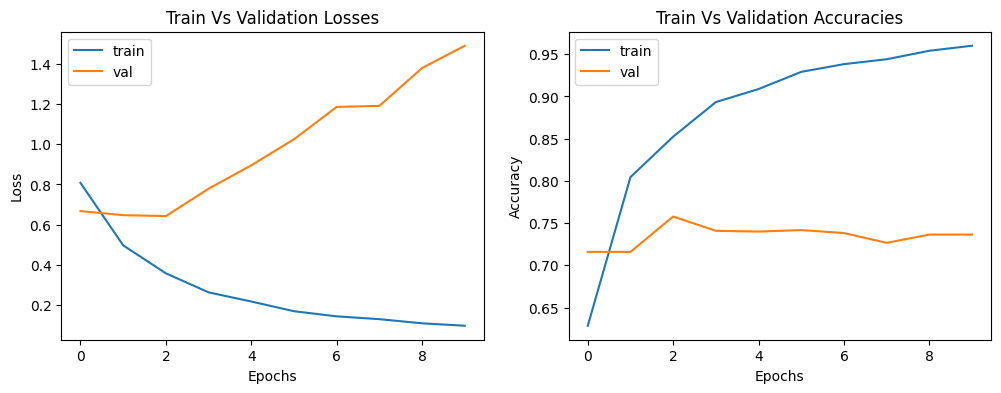

learning_rate = 0.003
Test correct = 469

Test total dataitem = 750

Test Accuracy = 0.625333309173584

              precision    recall  f1-score   support

    negative       0.79      0.50      0.61       250
     neutral       0.59      0.69      0.64       250
    positive       0.57      0.69      0.63       250

    accuracy                           0.63       750
   macro avg       0.65      0.63      0.62       750
weighted avg       0.65      0.63      0.62       750



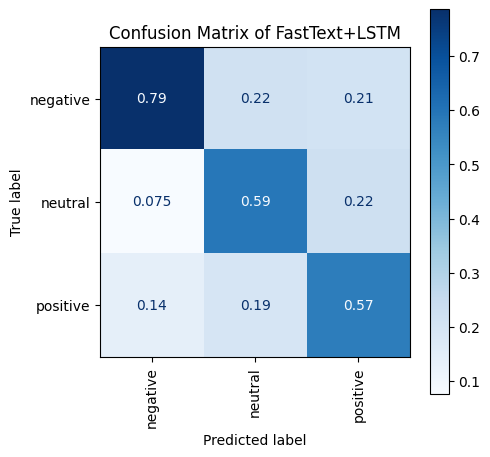

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 88.84it/s]


loss = 1.0943085280619562, val_loss =1.0861840501767657, accuracy = 0.41127511858940125, val_accuracy = 0.561887800693512


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.74it/s]


loss = 1.0067168965144082, val_loss =0.857117553818823, accuracy = 0.5587311387062073, val_accuracy = 0.6206589937210083


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.31it/s]


loss = 0.7445532975756214, val_loss =0.7151928518685531, accuracy = 0.6918969750404358, val_accuracy = 0.6803205609321594


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 88.29it/s]


loss = 0.609580216337306, val_loss =0.6425148279746223, accuracy = 0.7520414590835571, val_accuracy = 0.7266251444816589


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 89.19it/s]


loss = 0.5304667398389897, val_loss =0.5986986756895502, accuracy = 0.7848618030548096, val_accuracy = 0.7444345951080322


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 86.18it/s]


loss = 0.4715295896395987, val_loss =0.5859927232286132, accuracy = 0.8095163106918335, val_accuracy = 0.7506678700447083


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 85.99it/s]


loss = 0.4303847368505721, val_loss =0.571287541759042, accuracy = 0.8305590152740479, val_accuracy = 0.7720391750335693


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 83.96it/s]


loss = 0.39159086806224475, val_loss =0.5754723651842042, accuracy = 0.8511306643486023, val_accuracy = 0.7666963934898376


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 83.58it/s]


loss = 0.3628341366190243, val_loss =0.5788079518227526, accuracy = 0.8577260971069336, val_accuracy = 0.7720391750335693


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 88.65it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.3366441583132692, val_loss =0.6238443143893434, accuracy = 0.8682474493980408, val_accuracy = 0.7658059000968933


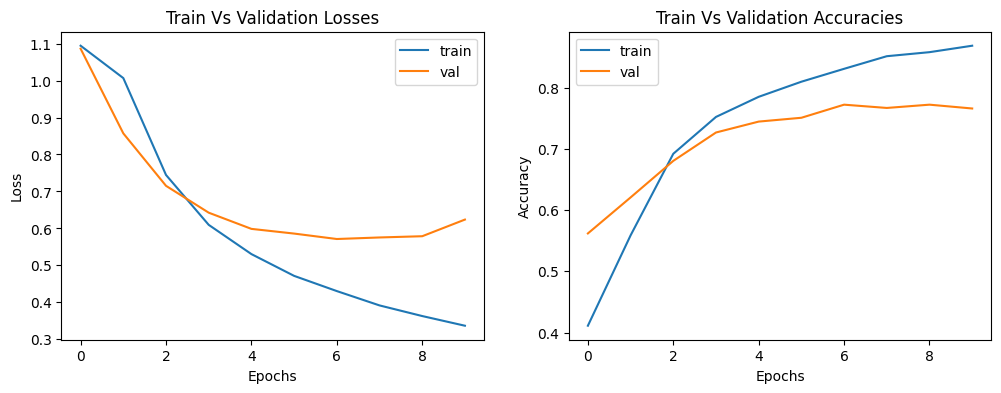

learning_rate = 0.0001
Test correct = 493

Test total dataitem = 750

Test Accuracy = 0.6573333144187927

              precision    recall  f1-score   support

    negative       0.71      0.63      0.67       250
     neutral       0.60      0.74      0.66       250
    positive       0.68      0.60      0.64       250

    accuracy                           0.66       750
   macro avg       0.67      0.66      0.66       750
weighted avg       0.67      0.66      0.66       750



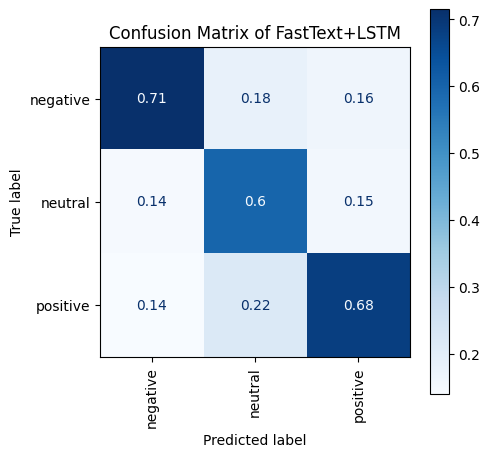

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 87.84it/s]


loss = 1.0710643373033963, val_loss =0.9427563112831512, accuracy = 0.4613693356513977, val_accuracy = 0.58771151304245


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.42it/s]


loss = 0.7740353133276767, val_loss =0.6882816283674892, accuracy = 0.6769786477088928, val_accuracy = 0.7088156938552856


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.11it/s]


loss = 0.5704710922847062, val_loss =0.6098888325505507, accuracy = 0.7646042704582214, val_accuracy = 0.7524487972259521


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 88.31it/s]


loss = 0.4671027292166332, val_loss =0.5912739665034826, accuracy = 0.8112437129020691, val_accuracy = 0.7515583634376526


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 88.65it/s]


loss = 0.3985009711744226, val_loss =0.580120224196873, accuracy = 0.8451632857322693, val_accuracy = 0.7604630589485168


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 64.65it/s]


loss = 0.3498640079623207, val_loss =0.5815617642141518, accuracy = 0.8630653023719788, val_accuracy = 0.7702582478523254


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 73.53it/s]


loss = 0.31347477616344377, val_loss =0.6378673742608139, accuracy = 0.876884400844574, val_accuracy = 0.7693678140640259


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 84.60it/s]


loss = 0.2917415716517271, val_loss =0.6276880617663859, accuracy = 0.8859924674034119, val_accuracy = 0.7702582478523254


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 83.11it/s]


loss = 0.25980100425195274, val_loss =0.6860740537521728, accuracy = 0.9005967378616333, val_accuracy = 0.7640249729156494


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 87.53it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.23990946581410175, val_loss =0.6889359611797012, accuracy = 0.9073492288589478, val_accuracy = 0.7675868272781372


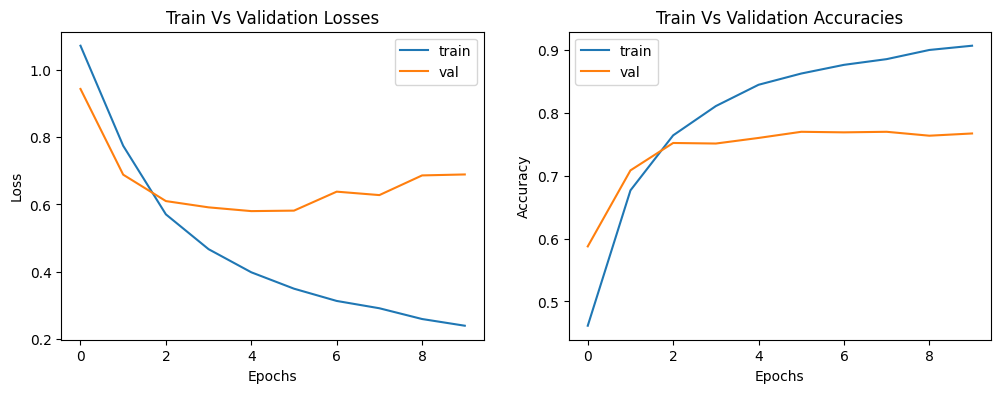

learning_rate = 0.0002
Test correct = 473

Test total dataitem = 750

Test Accuracy = 0.6306666731834412

              precision    recall  f1-score   support

    negative       0.73      0.53      0.61       250
     neutral       0.58      0.70      0.64       250
    positive       0.61      0.66      0.64       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



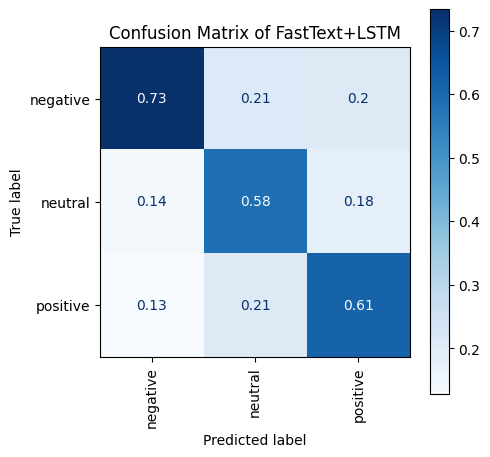

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 88.06it/s]


loss = 1.0244921941589564, val_loss =0.8296086902959302, accuracy = 0.48319724202156067, val_accuracy = 0.6295636892318726


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 87.94it/s]


loss = 0.6643193364703802, val_loss =0.6348180979468828, accuracy = 0.7209484577178955, val_accuracy = 0.7390917539596558


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.04it/s]


loss = 0.5018989505473528, val_loss =0.5889161895383856, accuracy = 0.7978957295417786, val_accuracy = 0.7533392906188965


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 88.20it/s]


loss = 0.412993147259359, val_loss =0.5652733827400546, accuracy = 0.8362122774124146, val_accuracy = 0.7613535523414612


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 88.00it/s]


loss = 0.3511445416481314, val_loss =0.6087445459711911, accuracy = 0.861966073513031, val_accuracy = 0.7684773206710815


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 87.51it/s]


loss = 0.30010018714364095, val_loss =0.6373391402944585, accuracy = 0.8852072954177856, val_accuracy = 0.7658059000968933


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 86.22it/s]


loss = 0.2733687098166257, val_loss =0.6743864235392555, accuracy = 0.8947864174842834, val_accuracy = 0.7560107111930847


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 83.70it/s]


loss = 0.23837001885727063, val_loss =0.6975917116077989, accuracy = 0.9060929417610168, val_accuracy = 0.7497773766517639


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 82.70it/s]


loss = 0.21816702606573568, val_loss =0.7511345303312746, accuracy = 0.9158291220664978, val_accuracy = 0.74799644947052


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 70.72it/s]


loss = 0.19121110335821048, val_loss =0.8288606180267055, accuracy = 0.9258793592453003, val_accuracy = 0.7506678700447083


<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


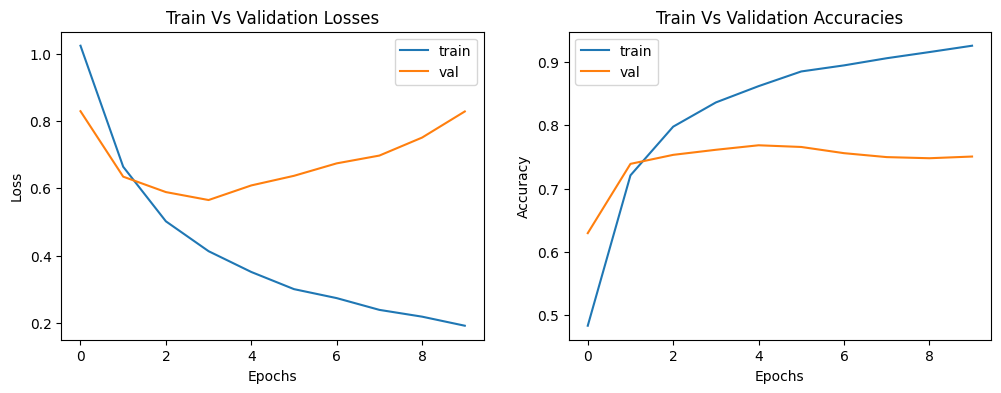

learning_rate = 0.0003
Test correct = 484

Test total dataitem = 750

Test Accuracy = 0.6453333497047424

              precision    recall  f1-score   support

    negative       0.74      0.56      0.64       250
     neutral       0.60      0.71      0.65       250
    positive       0.63      0.67      0.65       250

    accuracy                           0.65       750
   macro avg       0.66      0.65      0.64       750
weighted avg       0.66      0.65      0.64       750



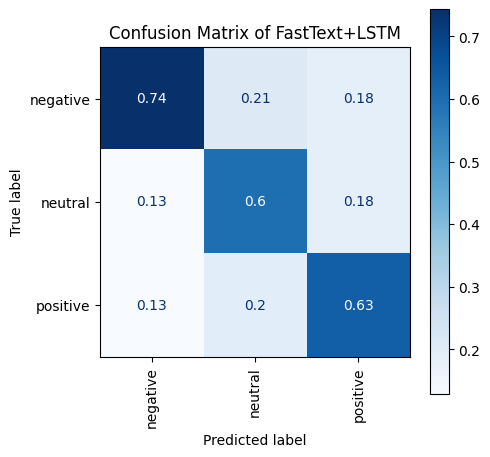

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 55.52it/s]


loss = 1.0988910598121584, val_loss =1.0981872829268613, accuracy = 0.329773873090744, val_accuracy = 0.34728407859802246


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 73.46it/s]


loss = 1.097921697460115, val_loss =1.0973491581984693, accuracy = 0.3368404507637024, val_accuracy = 0.3481745421886444


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 71.01it/s]


loss = 1.096949229631573, val_loss =1.0964389267481036, accuracy = 0.3589824140071869, val_accuracy = 0.3561887741088867


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 78.90it/s]


loss = 1.0954517583176493, val_loss =1.0953740696674066, accuracy = 0.3745288848876953, val_accuracy = 0.4016028642654419


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 54.90it/s]


loss = 1.0944823804683983, val_loss =1.0940874231151407, accuracy = 0.3910175859928131, val_accuracy = 0.42030277848243713


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 66.11it/s]


loss = 1.0930314942076802, val_loss =1.09243267828096, accuracy = 0.41771355271339417, val_accuracy = 0.4470169246196747


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 53.66it/s]


loss = 1.0902977112308145, val_loss =1.0901279612961743, accuracy = 0.45995602011680603, val_accuracy = 0.4897595942020416


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 59.17it/s]


loss = 1.0875132935028524, val_loss =1.0869111542856054, accuracy = 0.4962311387062073, val_accuracy = 0.5200356245040894


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 83.99it/s]


loss = 1.083138786405325, val_loss =1.0819819694754504, accuracy = 0.5268530249595642, val_accuracy = 0.5458593368530273


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 87.78it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 1.0764872231986373, val_loss =1.073907888036162, accuracy = 0.5557475090026855, val_accuracy = 0.5351736545562744


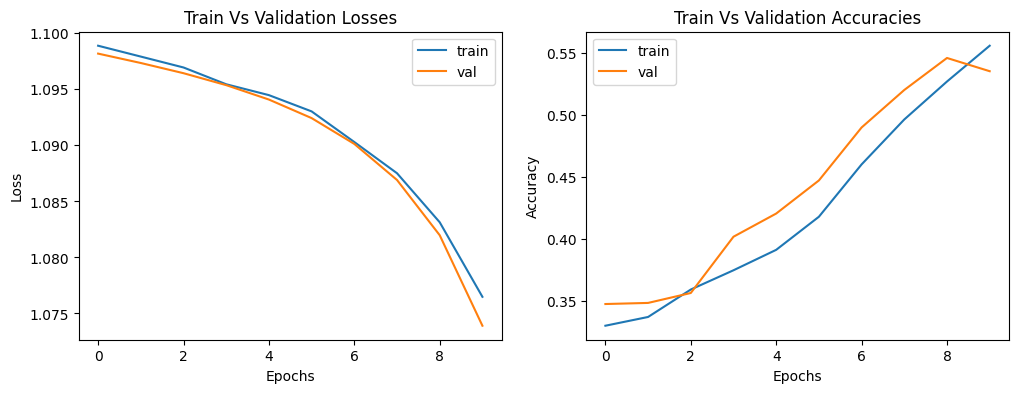

learning_rate = 1e-05
Test correct = 407

Test total dataitem = 750

Test Accuracy = 0.5426666736602783

              precision    recall  f1-score   support

    negative       0.50      0.74      0.60       250
     neutral       0.55      0.56      0.55       250
    positive       0.65      0.33      0.44       250

    accuracy                           0.54       750
   macro avg       0.57      0.54      0.53       750
weighted avg       0.57      0.54      0.53       750



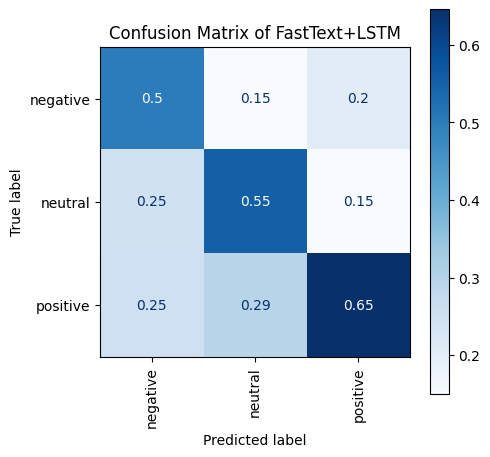

In [ ]:
bidirectional=True
num_layers=1
hidden_size1=256
hidden_size2=256
droprate=0.5
freeze_embedding=False
learning_rates=[0.1,0.01,0.001,0.002,0.003,0.0001,0.0002,0.0003,0.00001]
for learning_rate1 in learning_rates:
  model=LSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate1)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+LSTM'
  print(f'learning_rate = {learning_rate1}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 78.96it/s]


loss = 1.0940327558014542, val_loss =1.0858179704138329, accuracy = 0.3867776393890381, val_accuracy = 0.45235976576805115


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.14it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 1.0088984277832787, val_loss =0.8631295078515355, accuracy = 0.5450690984725952, val_accuracy = 0.6206589937210083


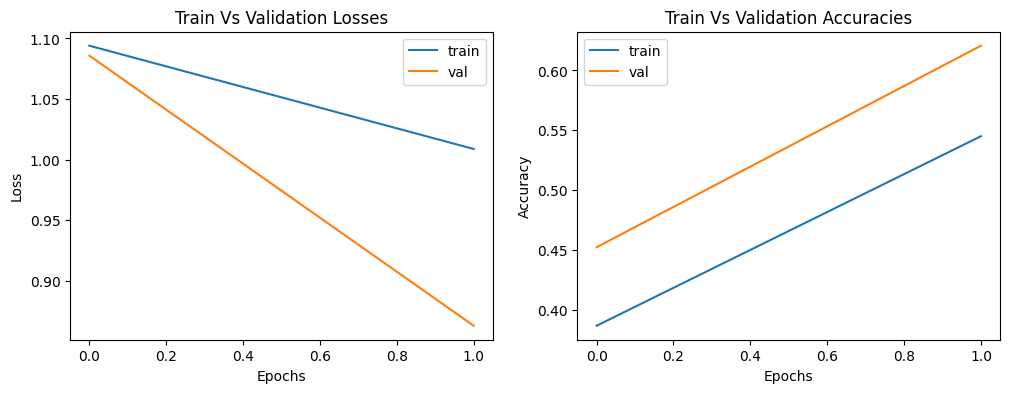

num_epochs = 2
Test correct = 434

Test total dataitem = 750

Test Accuracy = 0.5786666870117188

              precision    recall  f1-score   support

    negative       0.59      0.75      0.66       250
     neutral       0.58      0.58      0.58       250
    positive       0.57      0.41      0.47       250

    accuracy                           0.58       750
   macro avg       0.58      0.58      0.57       750
weighted avg       0.58      0.58      0.57       750



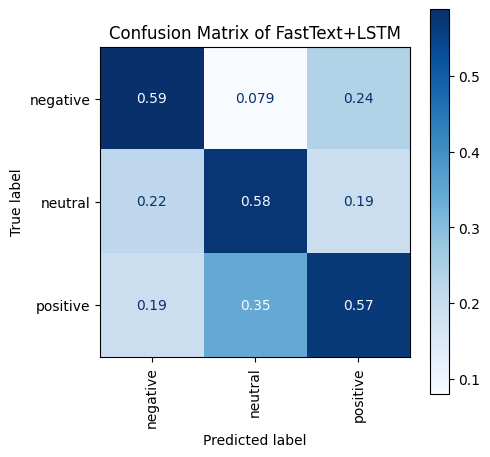

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 79.69it/s]


loss = 1.0932338622305542, val_loss =1.0826061103463411, accuracy = 0.3870916962623596, val_accuracy = 0.5138023495674133


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 79.49it/s]


loss = 0.9918817324790871, val_loss =0.862757299361854, accuracy = 0.5632851719856262, val_accuracy = 0.6064113974571228


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 86.46it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.7390140503447037, val_loss =0.709485060484532, accuracy = 0.6892274022102356, val_accuracy = 0.6883348226547241


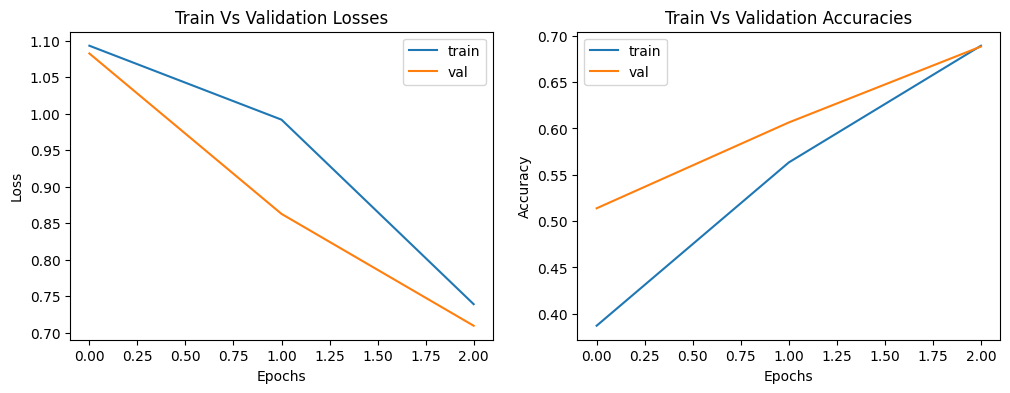

num_epochs = 3
Test correct = 469

Test total dataitem = 750

Test Accuracy = 0.625333309173584

              precision    recall  f1-score   support

    negative       0.66      0.73      0.69       250
     neutral       0.58      0.74      0.65       250
    positive       0.66      0.41      0.50       250

    accuracy                           0.63       750
   macro avg       0.63      0.63      0.62       750
weighted avg       0.63      0.63      0.62       750



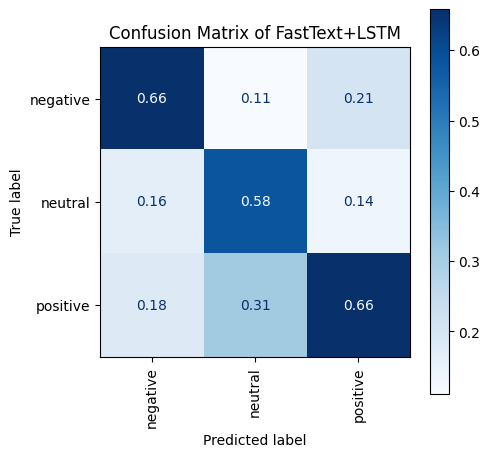

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 72.95it/s]


loss = 1.0938241976406424, val_loss =1.0854032731585441, accuracy = 0.39384421706199646, val_accuracy = 0.5414069890975952


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 79.98it/s]


loss = 1.008297525725211, val_loss =0.8814387235703642, accuracy = 0.5482097864151001, val_accuracy = 0.6001781225204468


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 71.24it/s]


loss = 0.7657997102931404, val_loss =0.7085897141860995, accuracy = 0.6738379597663879, val_accuracy = 0.6963490843772888


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 77.51it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.6272559472665443, val_loss =0.6633716584436462, accuracy = 0.7404208183288574, val_accuracy = 0.7266251444816589


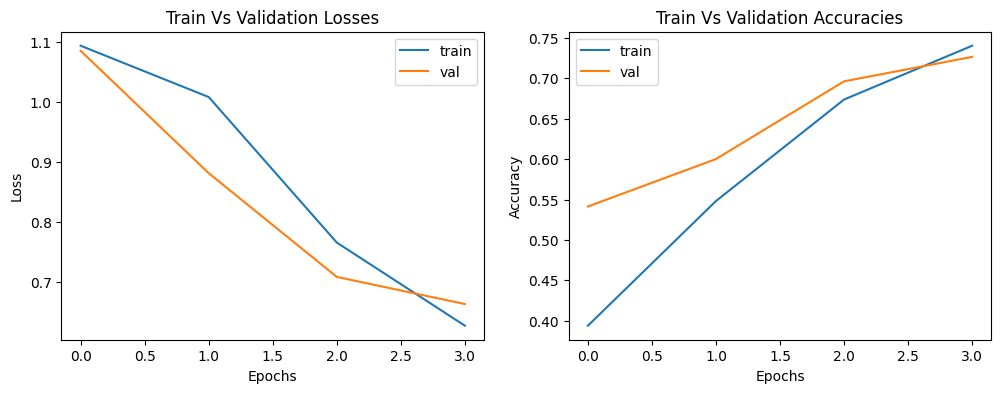

num_epochs = 4
Test correct = 487

Test total dataitem = 750

Test Accuracy = 0.6493332982063293

              precision    recall  f1-score   support

    negative       0.68      0.71      0.70       250
     neutral       0.70      0.58      0.63       250
    positive       0.58      0.66      0.62       250

    accuracy                           0.65       750
   macro avg       0.65      0.65      0.65       750
weighted avg       0.65      0.65      0.65       750



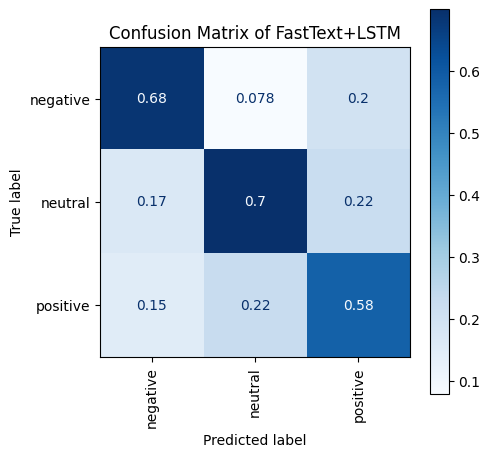

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 88.18it/s]


loss = 1.09420408481732, val_loss =1.0848799733400698, accuracy = 0.4048366844654083, val_accuracy = 0.5200356245040894


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.40it/s]


loss = 1.0071021998254581, val_loss =0.8778161007336283, accuracy = 0.5533919334411621, val_accuracy = 0.6081923842430115


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.26it/s]


loss = 0.7705936458047654, val_loss =0.7239624191715848, accuracy = 0.6809045076370239, val_accuracy = 0.6856634020805359


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 85.82it/s]


loss = 0.6310991927397663, val_loss =0.6369127214392117, accuracy = 0.740263819694519, val_accuracy = 0.7292965650558472


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 58.95it/s]


loss = 0.5458319868474325, val_loss =0.6118834037109789, accuracy = 0.7790514826774597, val_accuracy = 0.7390917539596558


<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


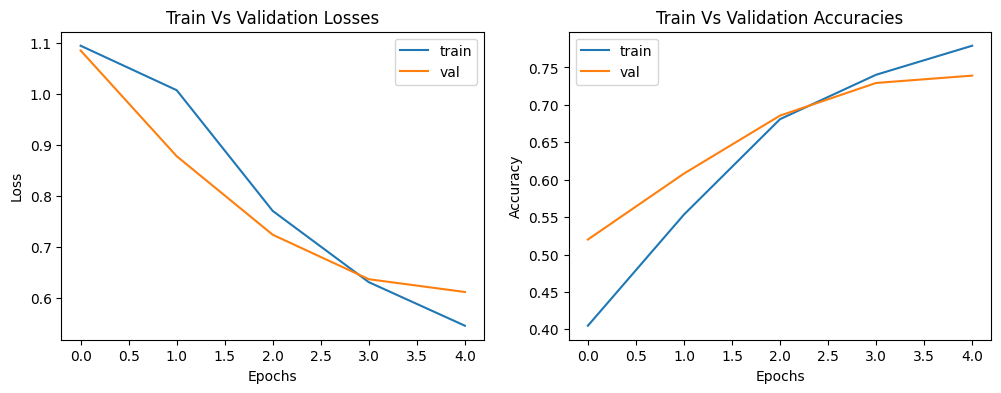

num_epochs = 5
Test correct = 474

Test total dataitem = 750

Test Accuracy = 0.6319999694824219

              precision    recall  f1-score   support

    negative       0.71      0.62      0.66       250
     neutral       0.57      0.76      0.65       250
    positive       0.65      0.52      0.58       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



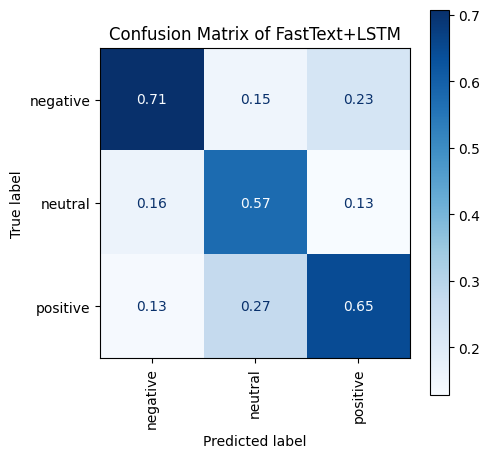

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 66.06it/s]


loss = 1.0947481650300324, val_loss =1.0891696487982123, accuracy = 0.3814384341239929, val_accuracy = 0.46215495467185974


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 81.62it/s]


loss = 1.020081073360052, val_loss =0.9083530634807955, accuracy = 0.5653266310691833, val_accuracy = 0.6179875731468201


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 86.40it/s]


loss = 0.7648197160279233, val_loss =0.71392933978045, accuracy = 0.685615599155426, val_accuracy = 0.6910062432289124


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 87.54it/s]


loss = 0.6226121111102657, val_loss =0.659965378567387, accuracy = 0.7501569986343384, val_accuracy = 0.7186108827590942


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 83.17it/s]


loss = 0.5394469316340564, val_loss =0.6123463108458228, accuracy = 0.7848618030548096, val_accuracy = 0.7426536083221436


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 78.22it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.4746238203363509, val_loss =0.6024659968274158, accuracy = 0.8114007711410522, val_accuracy = 0.7613535523414612


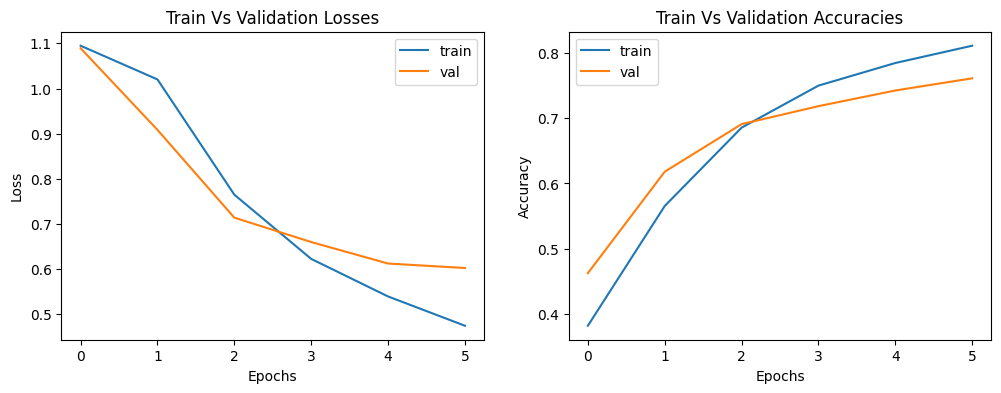

num_epochs = 6
Test correct = 492

Test total dataitem = 750

Test Accuracy = 0.656000018119812

              precision    recall  f1-score   support

    negative       0.71      0.64      0.67       250
     neutral       0.67      0.64      0.65       250
    positive       0.61      0.68      0.64       250

    accuracy                           0.66       750
   macro avg       0.66      0.66      0.66       750
weighted avg       0.66      0.66      0.66       750



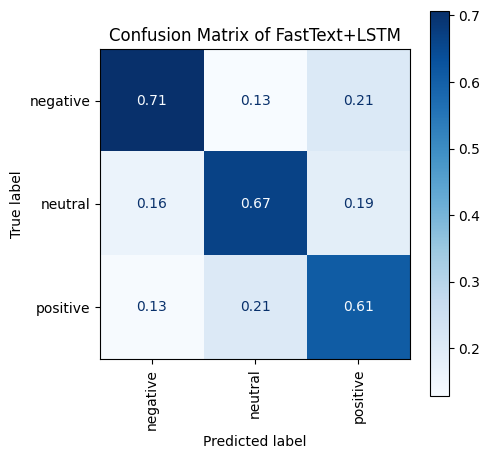

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 57.12it/s]


loss = 1.0936049969960004, val_loss =1.0838779440312276, accuracy = 0.40091079473495483, val_accuracy = 0.5440783500671387


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 62.52it/s]


loss = 0.9953951440041419, val_loss =0.8874653248107597, accuracy = 0.5609296560287476, val_accuracy = 0.6001781225204468


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 64.07it/s]


loss = 0.7378047883164709, val_loss =0.7013543757034414, accuracy = 0.6859296560287476, val_accuracy = 0.699020504951477


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 84.79it/s]


loss = 0.6117097117371486, val_loss =0.6472418062000383, accuracy = 0.7493718266487122, val_accuracy = 0.7088156938552856


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 87.05it/s]


loss = 0.5323984777204817, val_loss =0.6144513366106583, accuracy = 0.7869032621383667, val_accuracy = 0.7346394062042236


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 86.99it/s]


loss = 0.4770758856655391, val_loss =0.5974397666265484, accuracy = 0.809202253818512, val_accuracy = 0.7560107111930847


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 87.54it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.4285619254541484, val_loss =0.6115040125891166, accuracy = 0.8277323842048645, val_accuracy = 0.7595725655555725


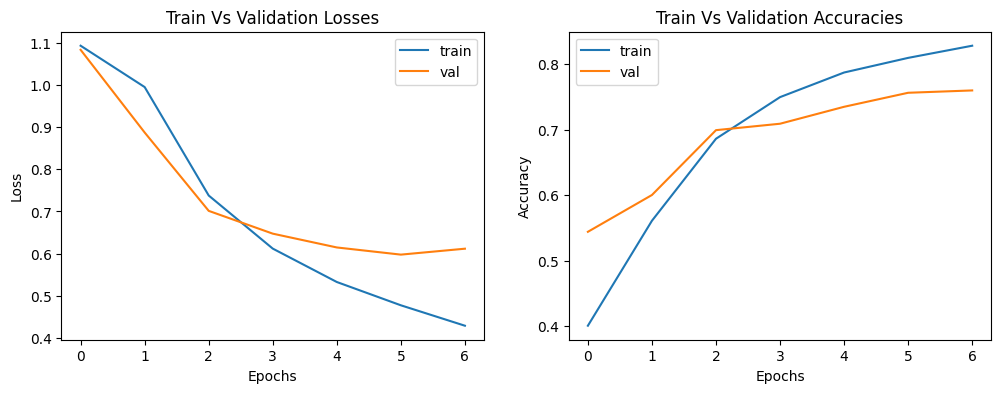

num_epochs = 7
Test correct = 492

Test total dataitem = 750

Test Accuracy = 0.656000018119812

              precision    recall  f1-score   support

    negative       0.73      0.62      0.67       250
     neutral       0.59      0.78      0.67       250
    positive       0.68      0.56      0.62       250

    accuracy                           0.66       750
   macro avg       0.67      0.66      0.65       750
weighted avg       0.67      0.66      0.65       750



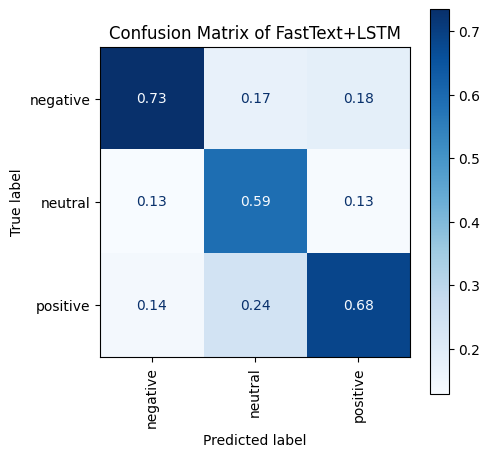

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 87.55it/s]


loss = 1.093546906914562, val_loss =1.0840592345503706, accuracy = 0.42085427045822144, val_accuracy = 0.5031166672706604


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 87.65it/s]


loss = 0.994187457965454, val_loss =0.8758072087367523, accuracy = 0.5654836893081665, val_accuracy = 0.6126447319984436


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.11it/s]


loss = 0.7444031847610677, val_loss =0.6968914445224939, accuracy = 0.692682147026062, val_accuracy = 0.7105966210365295


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 86.21it/s]


loss = 0.6078978002834446, val_loss =0.6316818125152037, accuracy = 0.755182147026062, val_accuracy = 0.7346394062042236


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 83.87it/s]


loss = 0.5271273232549015, val_loss =0.6042695283013277, accuracy = 0.7930276393890381, val_accuracy = 0.7426536083221436


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 82.16it/s]


loss = 0.4749962992350305, val_loss =0.607168937979323, accuracy = 0.8137562870979309, val_accuracy = 0.7488869428634644


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 83.94it/s]


loss = 0.42544224064535413, val_loss =0.5976455794502453, accuracy = 0.8346419334411621, val_accuracy = 0.7524487972259521


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 87.25it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.39384631548050963, val_loss =0.5963356168410794, accuracy = 0.8421796560287476, val_accuracy = 0.7560107111930847


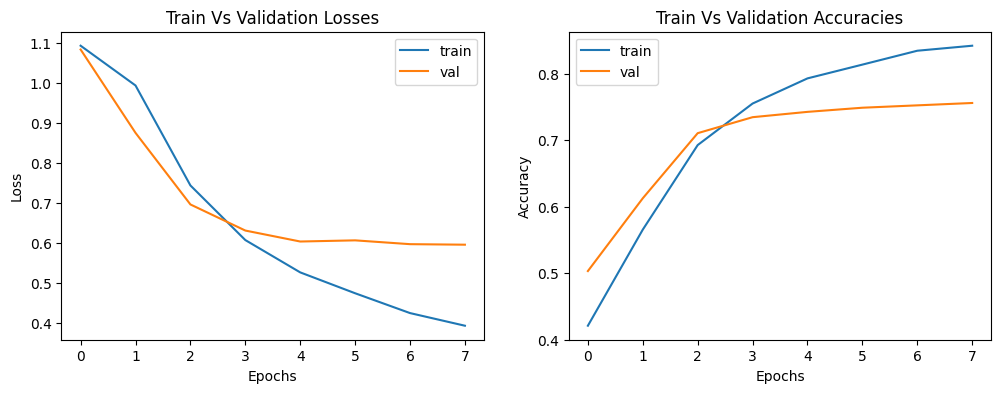

num_epochs = 8
Test correct = 500

Test total dataitem = 750

Test Accuracy = 0.6666666865348816

              precision    recall  f1-score   support

    negative       0.73      0.66      0.69       250
     neutral       0.60      0.73      0.66       250
    positive       0.69      0.61      0.65       250

    accuracy                           0.67       750
   macro avg       0.67      0.67      0.67       750
weighted avg       0.67      0.67      0.67       750



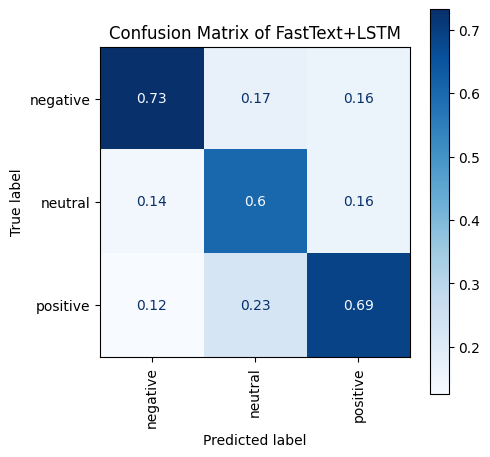

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 82.42it/s]


loss = 1.0938219943549483, val_loss =1.0856678059679412, accuracy = 0.39180275797843933, val_accuracy = 0.529830813407898


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 76.85it/s]


loss = 1.012257449340541, val_loss =0.8731255738747432, accuracy = 0.5489949584007263, val_accuracy = 0.5966162085533142


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 80.69it/s]


loss = 0.750619950776636, val_loss =0.6998061693507239, accuracy = 0.6815326809883118, val_accuracy = 0.6910062432289124


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 81.82it/s]


loss = 0.613259851166722, val_loss =0.6381913479365794, accuracy = 0.7503140568733215, val_accuracy = 0.7301869988441467


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 83.39it/s]


loss = 0.5325748030266504, val_loss =0.6072013385408557, accuracy = 0.7834484577178955, val_accuracy = 0.7471059560775757


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 88.37it/s]


loss = 0.47239438595597877, val_loss =0.5865126361913813, accuracy = 0.8129711151123047, val_accuracy = 0.7551202178001404


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 85.39it/s]


loss = 0.42571294421613837, val_loss =0.5819737003833243, accuracy = 0.8304020166397095, val_accuracy = 0.7631344795227051


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 84.41it/s]


loss = 0.390134512489348, val_loss =0.5873316716695545, accuracy = 0.8476758599281311, val_accuracy = 0.7551202178001404


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 82.48it/s]


loss = 0.36456549343719646, val_loss =0.6070444988785195, accuracy = 0.8564698696136475, val_accuracy = 0.7658059000968933


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 87.50it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.33945998309068465, val_loss =0.5984556064565486, accuracy = 0.870445966720581, val_accuracy = 0.756901204586029


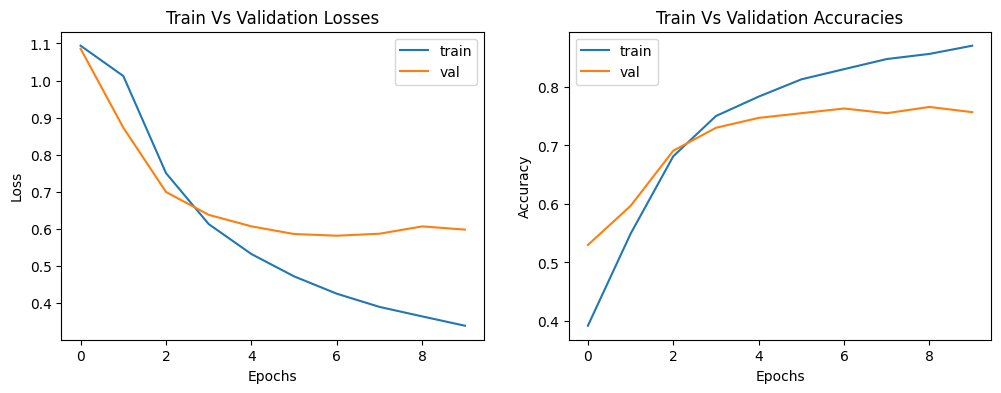

num_epochs = 10
Test correct = 493

Test total dataitem = 750

Test Accuracy = 0.6573333144187927

              precision    recall  f1-score   support

    negative       0.71      0.60      0.65       250
     neutral       0.60      0.72      0.66       250
    positive       0.67      0.65      0.66       250

    accuracy                           0.66       750
   macro avg       0.66      0.66      0.66       750
weighted avg       0.66      0.66      0.66       750



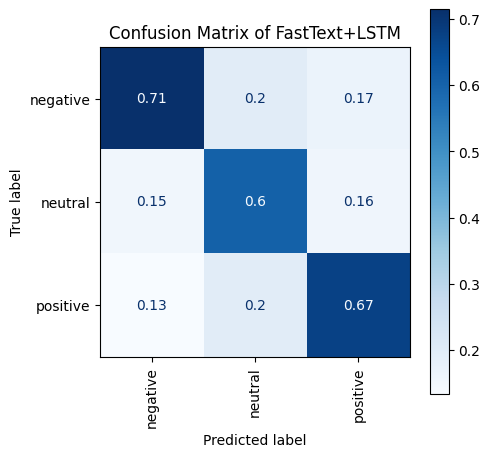

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 88.51it/s]


loss = 1.094232064532116, val_loss =1.0861432167553593, accuracy = 0.40876254439353943, val_accuracy = 0.5218165516853333


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.47it/s]


loss = 1.003673522787867, val_loss =0.8664264515912649, accuracy = 0.5725502371788025, val_accuracy = 0.6322351098060608


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 89.09it/s]


loss = 0.7522447800774534, val_loss =0.7040923541041493, accuracy = 0.6887562870979309, val_accuracy = 0.700801432132721


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 89.12it/s]


loss = 0.6248412423661103, val_loss =0.65843982183204, accuracy = 0.7482725977897644, val_accuracy = 0.7221727967262268


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 88.68it/s]


loss = 0.537559508514446, val_loss =0.6153978687349775, accuracy = 0.7889447212219238, val_accuracy = 0.7346394062042236


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 88.48it/s]


loss = 0.4721460815509458, val_loss =0.5868932733395562, accuracy = 0.8109296560287476, val_accuracy = 0.7533392906188965


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 87.97it/s]


loss = 0.4350022611553145, val_loss =0.5811127632050289, accuracy = 0.8329145908355713, val_accuracy = 0.7462155222892761


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 87.01it/s]


loss = 0.3995649047868284, val_loss =0.6184485258695025, accuracy = 0.8390389084815979, val_accuracy = 0.7497773766517639


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 84.47it/s]


loss = 0.3688109649541439, val_loss =0.5842476423110929, accuracy = 0.8585112690925598, val_accuracy = 0.7613535523414612


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 84.49it/s]


loss = 0.3439236185808513, val_loss =0.6015378906582819, accuracy = 0.8687185645103455, val_accuracy = 0.7560107111930847


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 88.02it/s]


loss = 0.3208080083438162, val_loss =0.6251092604611355, accuracy = 0.8731155395507812, val_accuracy = 0.7658059000968933


Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 89.07it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.29907913252898877, val_loss =0.6041689488176227, accuracy = 0.884736180305481, val_accuracy = 0.780053436756134


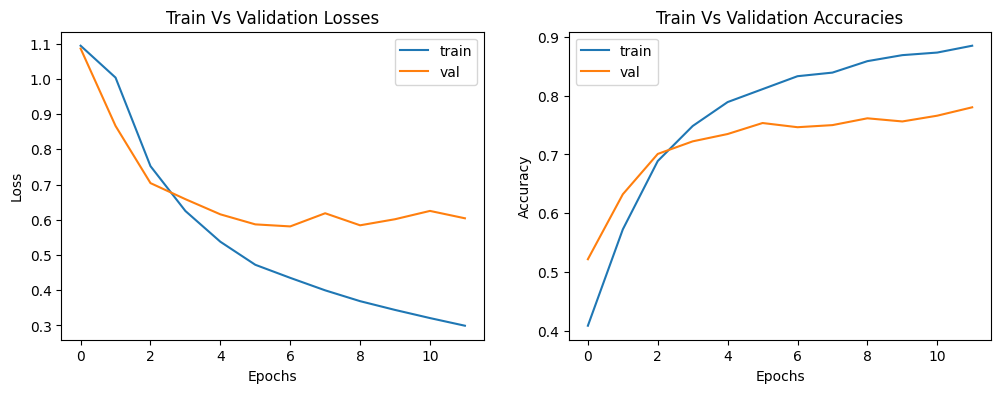

num_epochs = 12
Test correct = 497

Test total dataitem = 750

Test Accuracy = 0.6626666784286499

              precision    recall  f1-score   support

    negative       0.74      0.60      0.66       250
     neutral       0.61      0.73      0.67       250
    positive       0.66      0.66      0.66       250

    accuracy                           0.66       750
   macro avg       0.67      0.66      0.66       750
weighted avg       0.67      0.66      0.66       750



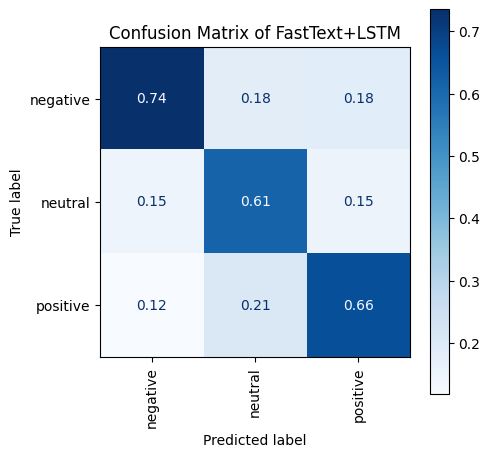

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 88.79it/s]


loss = 1.0935906311683357, val_loss =1.0827309372849645, accuracy = 0.3836369216442108, val_accuracy = 0.4568121135234833


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 88.74it/s]


loss = 1.0026225494709797, val_loss =0.8674701739483262, accuracy = 0.5471105575561523, val_accuracy = 0.6162065863609314


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.94it/s]


loss = 0.7566259625356179, val_loss =0.7275113307344053, accuracy = 0.6812185645103455, val_accuracy = 0.6705253720283508


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 88.33it/s]


loss = 0.6252793340173138, val_loss =0.6413756783949389, accuracy = 0.7418341636657715, val_accuracy = 0.7212823033332825


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 79.02it/s]


loss = 0.5480575559411244, val_loss =0.6017247315484635, accuracy = 0.776695966720581, val_accuracy = 0.7444345951080322


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 71.84it/s]


loss = 0.4762846024949007, val_loss =0.5892476763545876, accuracy = 0.8074748516082764, val_accuracy = 0.7551202178001404


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 60.27it/s]


loss = 0.43226268736008633, val_loss =0.6510491237800835, accuracy = 0.8245916962623596, val_accuracy = 0.7373107671737671


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 60.61it/s]


loss = 0.4003214063083868, val_loss =0.5676501308644862, accuracy = 0.841080367565155, val_accuracy = 0.7604630589485168


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 38.92it/s]


loss = 0.37092468699121967, val_loss =0.5879042589836314, accuracy = 0.8509736061096191, val_accuracy = 0.74799644947052


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 88.18it/s]


loss = 0.34170855222310814, val_loss =0.5935714081106404, accuracy = 0.8680904507637024, val_accuracy = 0.756901204586029


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 88.15it/s]


loss = 0.324968581073685, val_loss =0.6229426266642096, accuracy = 0.8762562870979309, val_accuracy = 0.7711487412452698


Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 88.62it/s]


loss = 0.3072769545689011, val_loss =0.617259790166204, accuracy = 0.8803392052650452, val_accuracy = 0.7631344795227051


Epoch 13: 100%|██████████| 100/100 [00:01<00:00, 87.82it/s]


loss = 0.28292888161543556, val_loss =0.6461207901382178, accuracy = 0.8910175561904907, val_accuracy = 0.7729296684265137


Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 88.33it/s]


loss = 0.27469801411749645, val_loss =0.6048838652754434, accuracy = 0.8914886713027954, val_accuracy = 0.7631344795227051


Epoch 15: 100%|██████████| 100/100 [00:01<00:00, 87.92it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.25662252382639844, val_loss =0.6541624660082898, accuracy = 0.9007537364959717, val_accuracy = 0.7666963934898376


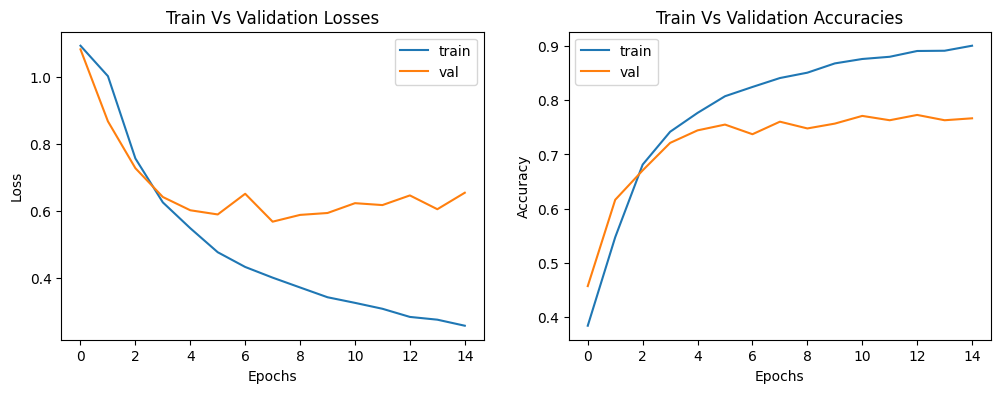

num_epochs = 15
Test correct = 474

Test total dataitem = 750

Test Accuracy = 0.6319999694824219

              precision    recall  f1-score   support

    negative       0.73      0.53      0.61       250
     neutral       0.60      0.71      0.65       250
    positive       0.60      0.66      0.63       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



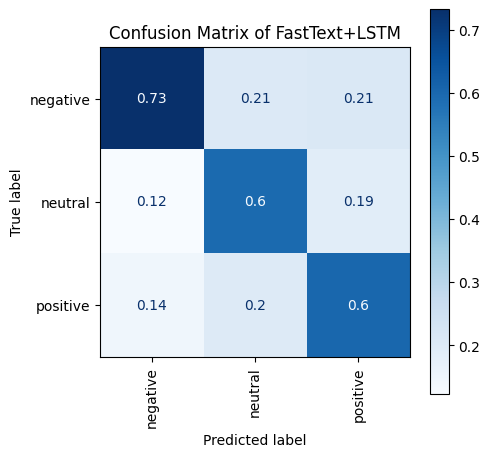

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 88.15it/s]


loss = 1.0937073922436684, val_loss =1.0846397616279622, accuracy = 0.40782034397125244, val_accuracy = 0.47640249133110046


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 85.96it/s]


loss = 0.9971718820766546, val_loss =0.8753483441166786, accuracy = 0.5637562870979309, val_accuracy = 0.6242208480834961


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 82.52it/s]


loss = 0.760724613507482, val_loss =0.7326055628710448, accuracy = 0.6865577697753906, val_accuracy = 0.6723063588142395


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 83.35it/s]


loss = 0.6260894452483262, val_loss =0.6691244090450623, accuracy = 0.7478014826774597, val_accuracy = 0.7123775482177734


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 84.61it/s]


loss = 0.5464452942726621, val_loss =0.6148025305867901, accuracy = 0.7782663106918335, val_accuracy = 0.7444345951080322


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 88.38it/s]


loss = 0.48317840039453924, val_loss =0.590982393886086, accuracy = 0.8074748516082764, val_accuracy = 0.7533392906188965


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 87.88it/s]


loss = 0.44023430994379453, val_loss =0.5798133054134059, accuracy = 0.8250628113746643, val_accuracy = 0.756901204586029


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 87.56it/s]


loss = 0.404594381546631, val_loss =0.5690327372436582, accuracy = 0.8412374258041382, val_accuracy = 0.7604630589485168


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 88.02it/s]


loss = 0.372921194350101, val_loss =0.5794257875849259, accuracy = 0.8569409251213074, val_accuracy = 0.7640249729156494


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 88.09it/s]


loss = 0.340676597323884, val_loss =0.5752111210595635, accuracy = 0.8676193356513977, val_accuracy = 0.7729296684265137


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 88.17it/s]


loss = 0.3211884761320276, val_loss =0.5885027928992355, accuracy = 0.8748429417610168, val_accuracy = 0.7711487412452698


Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 88.21it/s]


loss = 0.29949986093276953, val_loss =0.6033158878408795, accuracy = 0.8842650651931763, val_accuracy = 0.7702582478523254


Epoch 13: 100%|██████████| 100/100 [00:01<00:00, 86.15it/s]


loss = 0.2875011019463694, val_loss =0.6151334343246776, accuracy = 0.8858354091644287, val_accuracy = 0.7684773206710815


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 45.60it/s]


loss = 0.27409996902714495, val_loss =0.6097145525847287, accuracy = 0.8910175561904907, val_accuracy = 0.7631344795227051


Epoch 15: 100%|██████████| 100/100 [00:01<00:00, 50.33it/s]


loss = 0.24858117102481994, val_loss =0.695745503573426, accuracy = 0.9007537364959717, val_accuracy = 0.758682131767273


Epoch 16: 100%|██████████| 100/100 [00:01<00:00, 64.08it/s]


loss = 0.23656822882675566, val_loss =0.720907306763293, accuracy = 0.9101758599281311, val_accuracy = 0.7515583634376526


Epoch 17: 100%|██████████| 100/100 [00:01<00:00, 81.18it/s]


loss = 0.22648155992493588, val_loss =0.7068307152297074, accuracy = 0.9111180901527405, val_accuracy = 0.773820161819458


Epoch 18: 100%|██████████| 100/100 [00:01<00:00, 88.35it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.20875038174749597, val_loss =0.7169722451108393, accuracy = 0.9181846380233765, val_accuracy = 0.7666963934898376


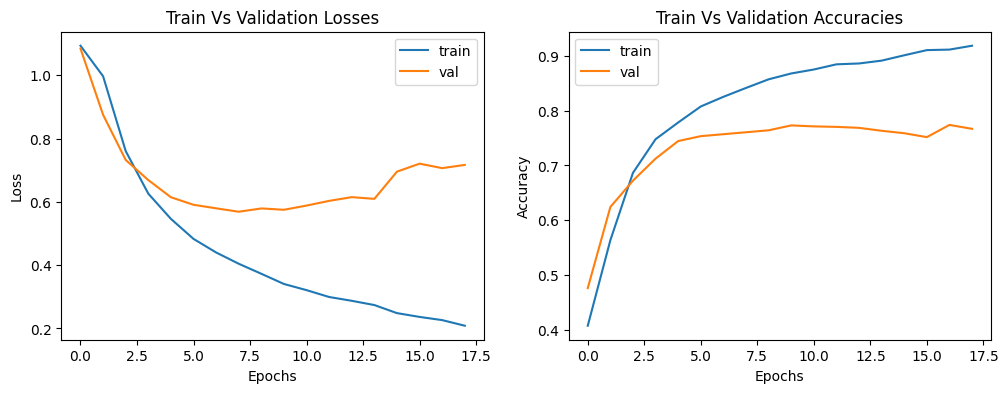

num_epochs = 18
Test correct = 481

Test total dataitem = 750

Test Accuracy = 0.6413333415985107

              precision    recall  f1-score   support

    negative       0.74      0.56      0.64       250
     neutral       0.60      0.69      0.65       250
    positive       0.61      0.67      0.64       250

    accuracy                           0.64       750
   macro avg       0.65      0.64      0.64       750
weighted avg       0.65      0.64      0.64       750



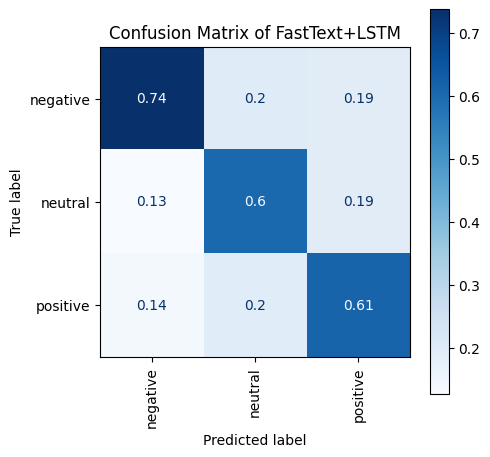

Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 88.28it/s]


loss = 1.093508484037593, val_loss =1.083752677162429, accuracy = 0.3806532621383667, val_accuracy = 0.5093499422073364


Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 87.99it/s]


loss = 0.9915794684912543, val_loss =0.8610390062315486, accuracy = 0.564384400844574, val_accuracy = 0.619768500328064


Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 88.36it/s]


loss = 0.7536436096655598, val_loss =0.6974630189243942, accuracy = 0.6884422302246094, val_accuracy = 0.690115749835968


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 88.17it/s]


loss = 0.6211046176350191, val_loss =0.6434179799136416, accuracy = 0.7430904507637024, val_accuracy = 0.7141585350036621


Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 86.74it/s]


loss = 0.5386274432434865, val_loss =0.5899366375823096, accuracy = 0.7796796560287476, val_accuracy = 0.7444345951080322


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 83.99it/s]


loss = 0.4810308789726878, val_loss =0.583165891517193, accuracy = 0.80402010679245, val_accuracy = 0.7560107111930847


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 84.96it/s]


loss = 0.4342487845238721, val_loss =0.5852000764642873, accuracy = 0.8249057531356812, val_accuracy = 0.7595725655555725


Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 83.54it/s]


loss = 0.4016800117343225, val_loss =0.5665963638189733, accuracy = 0.8387248516082764, val_accuracy = 0.7684773206710815


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 85.33it/s]


loss = 0.3724129649309997, val_loss =0.5744989658094691, accuracy = 0.8561557531356812, val_accuracy = 0.7622439861297607


Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 87.16it/s]


loss = 0.3477001133162346, val_loss =0.571065915250245, accuracy = 0.8655778765678406, val_accuracy = 0.7711487412452698


Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 87.98it/s]


loss = 0.3227007283768463, val_loss =0.5930758000099099, accuracy = 0.8751569986343384, val_accuracy = 0.7782725095748901


Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 88.51it/s]


loss = 0.30046234840823444, val_loss =0.5892642746852178, accuracy = 0.882066547870636, val_accuracy = 0.7684773206710815


Epoch 13: 100%|██████████| 100/100 [00:01<00:00, 88.24it/s]


loss = 0.28507093880685624, val_loss =0.612734941794538, accuracy = 0.8889760971069336, val_accuracy = 0.7756010890007019


Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 87.77it/s]


loss = 0.2663463041470559, val_loss =0.6782225081681098, accuracy = 0.8966708183288574, val_accuracy = 0.7613535523414612


Epoch 15: 100%|██████████| 100/100 [00:01<00:00, 88.42it/s]


loss = 0.2536865853850937, val_loss =0.64005263801924, accuracy = 0.9015389084815979, val_accuracy = 0.7693678140640259


Epoch 16: 100%|██████████| 100/100 [00:01<00:00, 88.15it/s]


loss = 0.2357928726017228, val_loss =0.7357612765706938, accuracy = 0.9103329181671143, val_accuracy = 0.74799644947052


Epoch 17: 100%|██████████| 100/100 [00:01<00:00, 85.79it/s]


loss = 0.23118832176248794, val_loss =0.6939525299570148, accuracy = 0.9093906879425049, val_accuracy = 0.758682131767273


Epoch 18: 100%|██████████| 100/100 [00:01<00:00, 84.28it/s]


loss = 0.21293063300879858, val_loss =0.7715165265688201, accuracy = 0.9175565242767334, val_accuracy = 0.7560107111930847


Epoch 19: 100%|██████████| 100/100 [00:01<00:00, 82.44it/s]


loss = 0.20588260550680332, val_loss =0.7243218789057044, accuracy = 0.9214823842048645, val_accuracy = 0.764915406703949


Epoch 20: 100%|██████████| 100/100 [00:01<00:00, 82.54it/s]
<ipython-input-23-276040982b3b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.1902939708330806, val_loss =0.7570898773787764, accuracy = 0.9276067614555359, val_accuracy = 0.7658059000968933


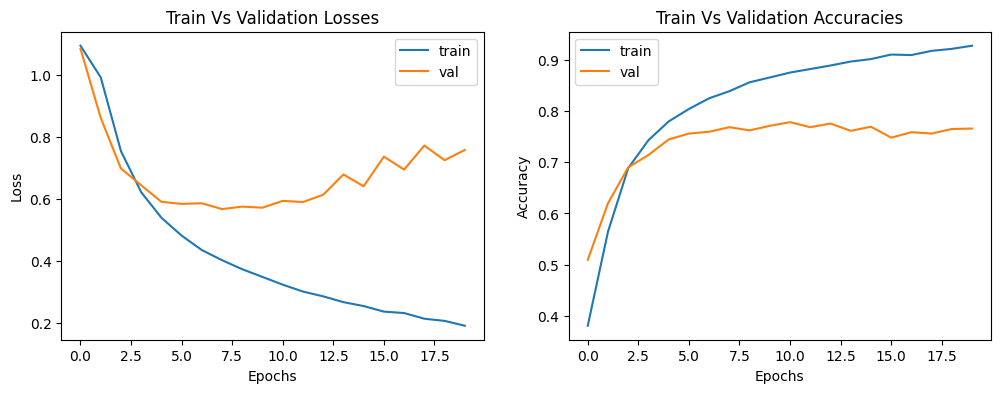

num_epochs = 20
Test correct = 475

Test total dataitem = 750

Test Accuracy = 0.6333333253860474

              precision    recall  f1-score   support

    negative       0.72      0.51      0.60       250
     neutral       0.61      0.68      0.65       250
    positive       0.60      0.70      0.65       250

    accuracy                           0.63       750
   macro avg       0.64      0.63      0.63       750
weighted avg       0.64      0.63      0.63       750



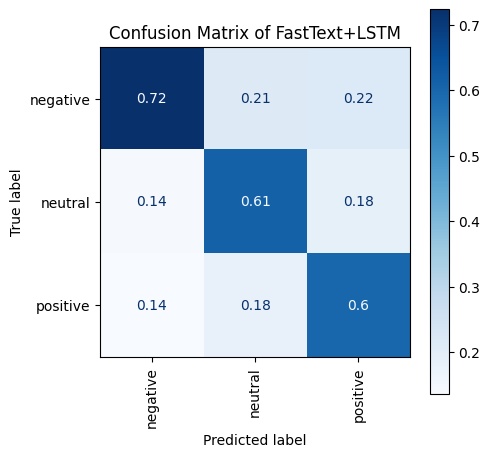

In [ ]:
bidirectional=True
num_layers=1
hidden_size1=256
hidden_size2=256
droprate=0.5
freeze_embedding=False
learning_rate=0.0001
num_epochs=[2,3,4,5,6,7,8,10,12,15,18,20]
for num_epoch in num_epochs:
  model=LSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  model_name='FastText+LSTM'
  print(f'num_epochs = {num_epoch}')
  test_and_report(model,test_loader,model_name)

Epoch 1: 100%|██████████| 118/118 [00:01<00:00, 109.58it/s]


loss = 1.092767389988432, accuracy = 0.41035908460617065


Epoch 2: 100%|██████████| 118/118 [00:00<00:00, 123.01it/s]


loss = 0.9683020633709812, accuracy = 0.5769590139389038


Epoch 3: 100%|██████████| 118/118 [00:01<00:00, 80.28it/s]


loss = 0.7146796668523453, accuracy = 0.7105860114097595


Epoch 4: 100%|██████████| 118/118 [00:00<00:00, 133.32it/s]


loss = 0.5926477680352182, accuracy = 0.7569082975387573


Epoch 5: 100%|██████████| 118/118 [00:00<00:00, 128.63it/s]


loss = 0.5184226579329727, accuracy = 0.7880122661590576


Epoch 6: 100%|██████████| 118/118 [00:00<00:00, 127.81it/s]


loss = 0.4685627169713401, accuracy = 0.810038685798645


Epoch 7: 100%|██████████| 118/118 [00:00<00:00, 127.00it/s]


loss = 0.4250862367511892, accuracy = 0.8311306834220886


Epoch 8: 100%|██████████| 118/118 [00:00<00:00, 124.49it/s]


loss = 0.3908611834339806, accuracy = 0.8431450724601746


Epoch 9: 100%|██████████| 118/118 [00:00<00:00, 131.03it/s]


loss = 0.3657067033915655, accuracy = 0.852890133857727


Epoch 10: 100%|██████████| 118/118 [00:00<00:00, 133.24it/s]
<ipython-input-27-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.3444163190291078, accuracy = 0.8634361028671265


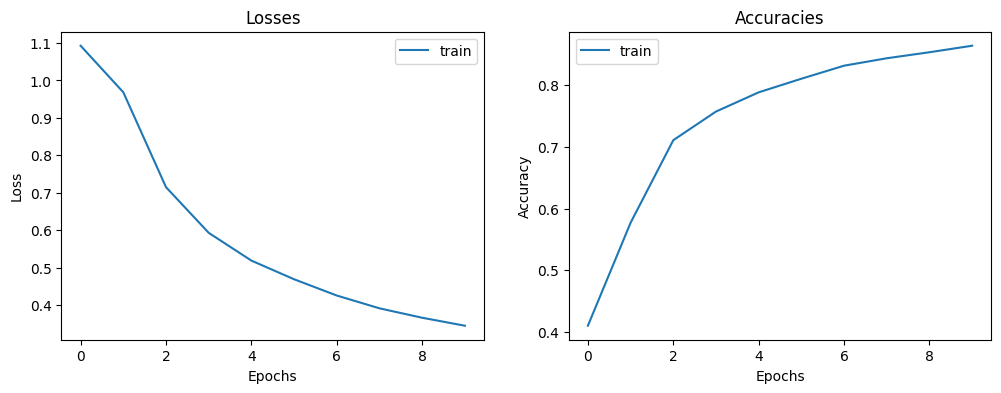

Test correct = 484

Test total dataitem = 750

Test Accuracy = 0.6453333497047424

              precision    recall  f1-score   support

    negative       0.74      0.54      0.62       250
     neutral       0.60      0.74      0.66       250
    positive       0.64      0.66      0.65       250

    accuracy                           0.65       750
   macro avg       0.66      0.65      0.64       750
weighted avg       0.66      0.65      0.64       750



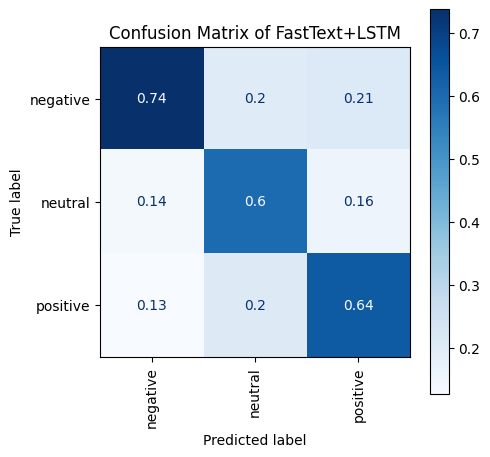

In [46]:
bidirectional= False
num_layers=1
hidden_size1=256
hidden_size2=256
droprate=0.5
freeze_embedding= False
epoch=10
learning_rate = 0.0001
model=LSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
optimizer=optim.Adam(model.parameters(),lr=learning_rate) # play around this also
criterion=nn.CrossEntropyLoss()
train(model,epoch,optimizer,criterion,full_dataloader)
model_name='FastText+LSTM'
test_and_report(model,test_loader,model_name)

In [47]:
torch.save(model.state_dict(),'/content/drive/MyDrive/SeniorProject1/models/FastText+LSTM.pth')

<ipython-input-49-44488abada4f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/FastText+LSTM

Test correct = 484

Test total dataitem = 750

Test Accuracy = 0.6453333497047424

              precision    recall  f1-score   support

    negative       0.74      0.54      0.62       250
     neutral       0.60      0.74      0.66       250
    positive       0.64      0.66      0.65       250

    accuracy                           0.65       750
   macro avg       0.66      0.65      0.64       750
weighted avg       0.66      0.65      0.64       750



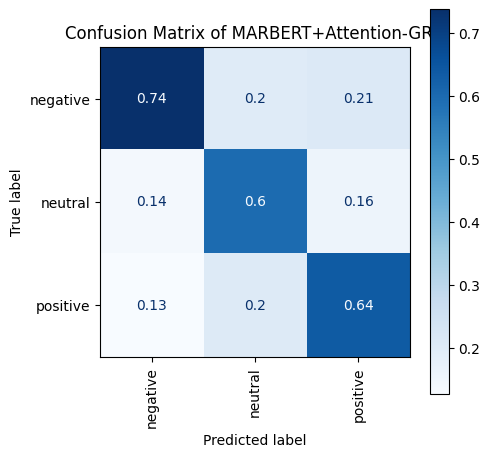

In [49]:
model=LSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/FastText+LSTM.pth'))
model_name='MARBERT+Attention-GRU'
test_and_report(model,test_loader,model_name)

##Attention

In [50]:
class AttentionLayer(nn.Module):
    def __init__(self, rnn_size):
        super(AttentionLayer, self).__init__()
        self.U = nn.Linear(rnn_size, 1,bias=False) # for the learnable paramter u
        torch.nn.init.xavier_normal_(self.U.weight)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden_states):
        # α = softmax(u_t^T U)
        attention_weights = self.U(hidden_states) # (batch_size, seq_len ,1)
        attention_weights = self.softmax(attention_weights.squeeze(2))  # (batch_size, seq_len)

        # eq.11: v = sum( α * hidden_states )
        attention_output = hidden_states * attention_weights.unsqueeze(2)  # (batch_size, seq_len, rnn_size)
        attention_output = attention_output.sum(dim = 1)  # (batch_size, rnn_size)

        return attention_output, attention_weights

In [51]:
class AttentionLSTM(nn.Module):
  def __init__(self,fasttext_weights,hidden_size1,hidden_size2,freeze_embedding=True,droprate=0.5,num_layers=1,num_classes=3,dider=True):
    super(AttentionLSTM,self).__init__()
    self.embedding=nn.Embedding.from_pretrained(torch.FloatTensor(fasttext_weights),freeze=freeze_embedding)
    self.rnn=nn.LSTM(self.embedding.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    self.attention=AttentionLayer(hidden_size1*self.d)
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

    #torch.nn.init.xavier_uniform_(self.fc1.weight)
    #torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self,x):
    x=self.embedding(x)
    x,h=self.rnn(x)
    x,attention_weights=self.attention(x)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x,attention_weights

You're on a cuda


Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 94.02it/s]


loss = 1.0983363067731262, val_loss =1.0970280140756614, accuracy = 0.34170854091644287, val_accuracy = 0.32680320739746094


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 112.43it/s]


loss = 1.072636631236528, val_loss =1.023828599459514, accuracy = 0.42870602011680603, val_accuracy = 0.4737311005592346


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 114.08it/s]


loss = 0.9772449800334289, val_loss =0.9001430996353663, accuracy = 0.5169597864151001, val_accuracy = 0.5761353373527527


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 124.63it/s]


loss = 0.798098945978054, val_loss =0.7457891735512975, accuracy = 0.6422738432884216, val_accuracy = 0.6731967926025391


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 123.74it/s]


loss = 0.6718783434466968, val_loss =0.6973787623584883, accuracy = 0.720634400844574, val_accuracy = 0.6910062432289124


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 122.18it/s]


loss = 0.5944102502744499, val_loss =0.7280381613782314, accuracy = 0.7572236061096191, val_accuracy = 0.690115749835968


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 118.57it/s]


loss = 0.5390008567849827, val_loss =0.655842912458701, accuracy = 0.7806218266487122, val_accuracy = 0.7141585350036621


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 118.53it/s]
<ipython-input-27-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


loss = 0.4870841357774214, val_loss =0.695190800053724, accuracy = 0.8043341636657715, val_accuracy = 0.7132680416107178


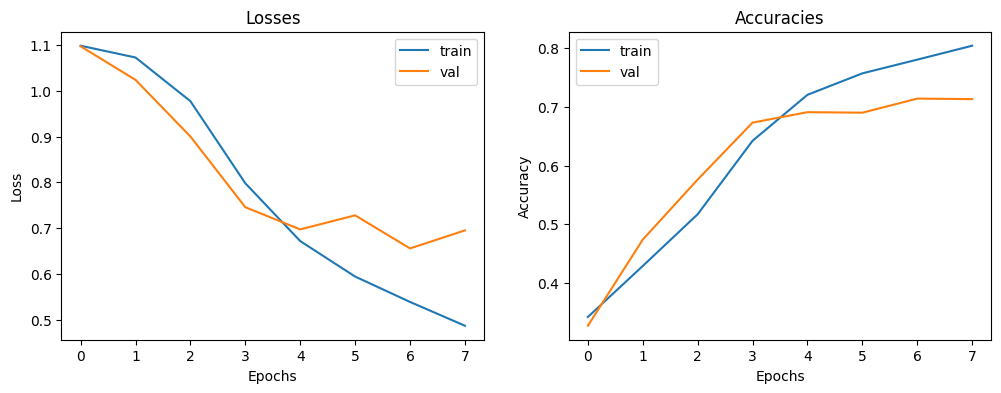

Test correct = 498

Test total dataitem = 750

Test Accuracy = 0.6639999747276306

              precision    recall  f1-score   support

    negative       0.63      0.78      0.70       250
     neutral       0.68      0.65      0.66       250
    positive       0.69      0.56      0.62       250

    accuracy                           0.66       750
   macro avg       0.67      0.66      0.66       750
weighted avg       0.67      0.66      0.66       750



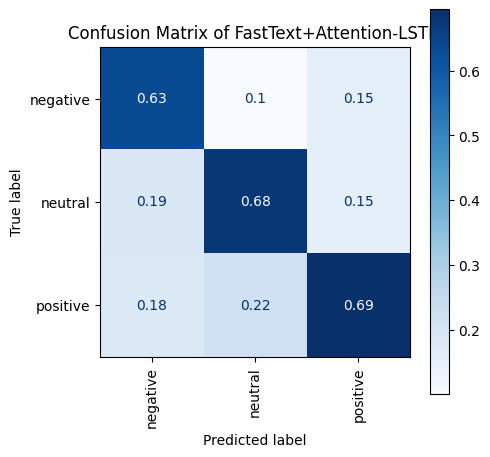

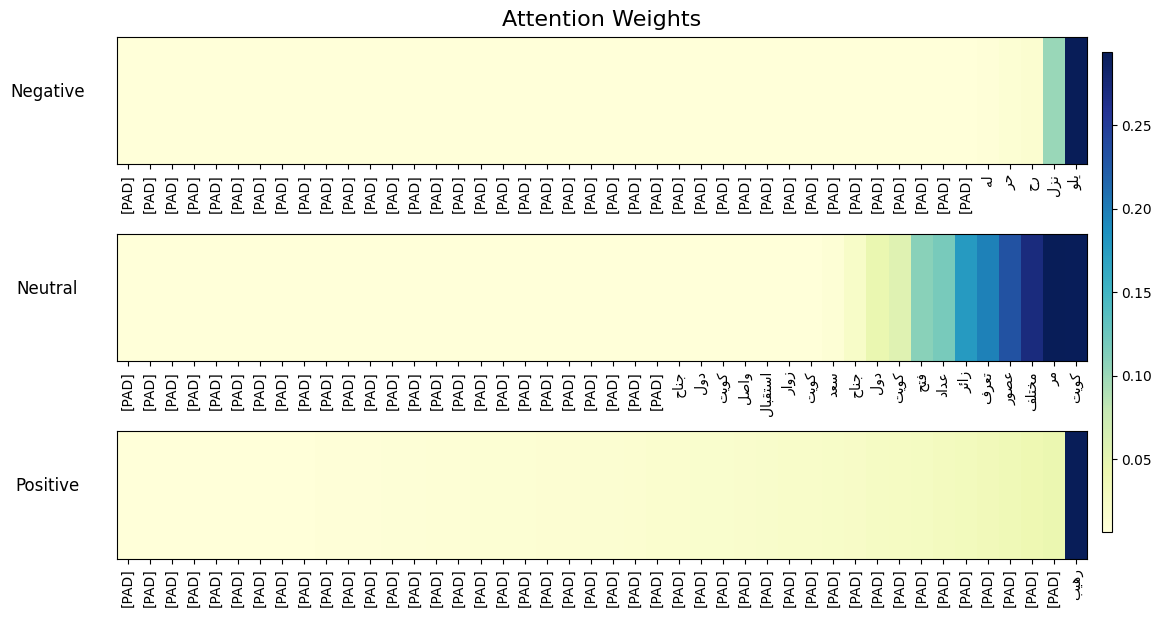

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You're on a {device}")
#hyperparameter
bidirectional= False
num_layers=1
hidden_size1=256
hidden_size2=256
droprate=0.5
freeze_embedding= False
epoch=8
learning_rate = 0.0001
model=AttentionLSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
optimizer=optim.Adam(model.parameters(),lr=learning_rate) # play around this also
criterion=nn.CrossEntropyLoss()
train(model,epoch,optimizer,criterion,train_loader,val_loader,attention_added=True)
model_name='FastText+Attention-LSTM'
test_and_report(model,test_loader,model_name,attention_added=True)

In [54]:
torch.save(model.state_dict(),'/content/drive/MyDrive/SeniorProject1/models/FastText+Attention-LSTM.pth')

<ipython-input-56-c7e0fa9f96b1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/FastText+Atte

Test correct = 498

Test total dataitem = 750

Test Accuracy = 0.6639999747276306

              precision    recall  f1-score   support

    negative       0.63      0.78      0.70       250
     neutral       0.68      0.65      0.66       250
    positive       0.69      0.56      0.62       250

    accuracy                           0.66       750
   macro avg       0.67      0.66      0.66       750
weighted avg       0.67      0.66      0.66       750



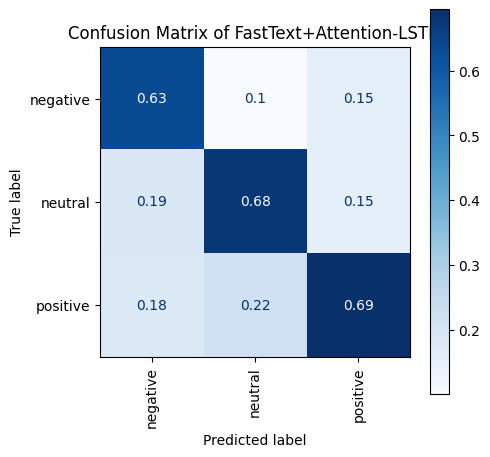

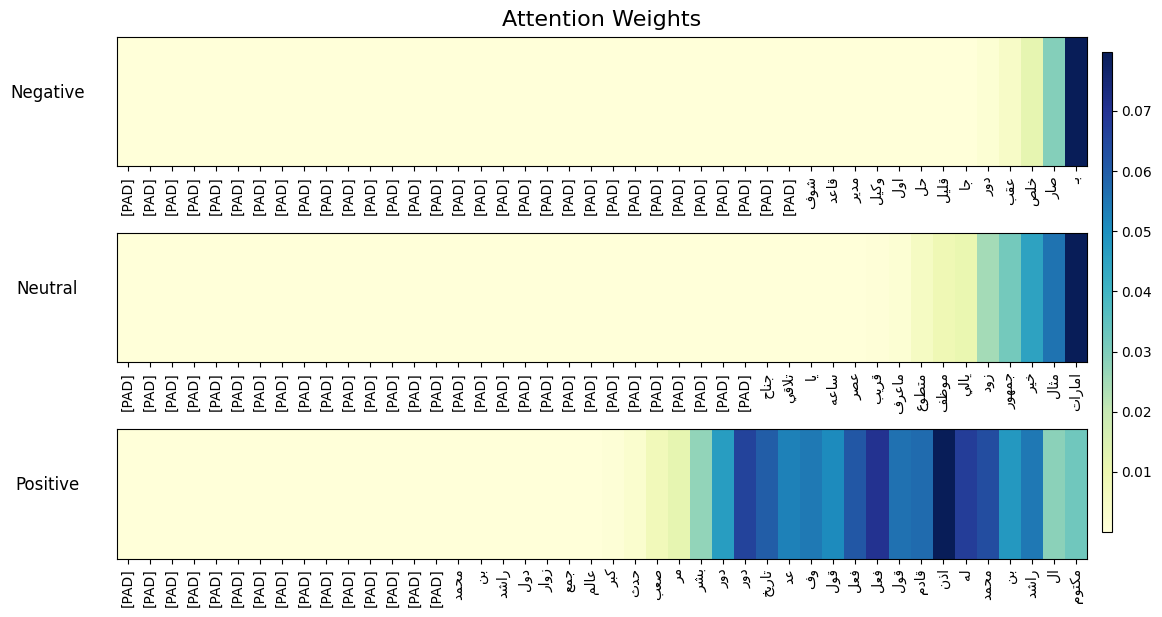

In [56]:
model=AttentionLSTM(fasttext_weights,hidden_size1,hidden_size2,freeze_embedding,droprate,num_layers,dider=bidirectional).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/FastText+Attention-LSTM.pth'))
model_name='FastText+Attention-LSTM'
test_and_report(model,test_loader,model_name,attention_added=True)